In [1]:
import matplotlib.pyplot as plt
import os
import xarray as xr
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import dask


In [3]:
# Paths for the Berkeley dataset and the model dataset
berkeley_reduced_file = "/Applications/historical/reduced_berkeley_dataset.nc"
model_file = "/Applications/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def construct_time_from_components(berkeley_ds):
    try:
        print("Constructing 'time' coordinate from 'year', 'month', and 'day'...")
        time_values = xr.cftime_range(
            start=f"{int(berkeley_ds['year'][0].values)}-01-01", 
            periods=len(berkeley_ds['year']), 
            freq='D'
        )
        berkeley_ds = berkeley_ds.assign_coords(time=time_values)
    except Exception as e:
        print(f"Error constructing 'time': {e}")
    return berkeley_ds

In [6]:
def convert_kelvin_to_celsius(ds, var_name):
    if ds[var_name].attrs.get('units', '') == 'K':
        print(f"Converting {var_name} from Kelvin to Celsius...")
        ds[var_name] -= 273.15
        ds[var_name].attrs['units'] = 'degree C'
    return ds

def print_temperature_statistics(model_data, berkeley_data):
    model_mean = model_data.mean().compute()
    model_min = model_data.min().compute()
    model_max = model_data.max().compute()
    berkeley_mean = berkeley_data.mean().compute()
    berkeley_min = berkeley_data.min().compute()
    berkeley_max = berkeley_data.max().compute()
    
    print("Model temperature statistics (1980):")
    print(f"Mean: {model_mean}, Min: {model_min}, Max: {model_max}")
    
    print("Berkeley temperature statistics (1980):")
    print(f"Mean: {berkeley_mean}, Min: {berkeley_min}, Max: {berkeley_max}")


In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

def calculate_model_vs_berkeley_metrics(model_data, berkeley_data):
    # Flatten the arrays after ensuring they are aligned
    model_flat = model_data.values.flatten()
    berkeley_flat = berkeley_data.values.flatten()
    
    # Remove NaNs from both datasets
    valid_mask = ~np.isnan(model_flat) & ~np.isnan(berkeley_flat)
    model_flat = model_flat[valid_mask]
    berkeley_flat = berkeley_flat[valid_mask]
    
    # Calculate RMSE and R²
    rmse = np.sqrt(mean_squared_error(berkeley_flat, model_flat))
    r2 = r2_score(berkeley_flat, model_flat)
    
    return rmse, r2

try:
    print("Loading and processing Berkeley dataset for 1980...")
    reduced_ds = xr.open_dataset(berkeley_reduced_file, chunks={'time': 50, 'latitude': 50, 'longitude': 50})
    reduced_ds = construct_time_from_components(reduced_ds)
    reduced_ds = reduced_ds.sel(time='1980')
    
    print("Loading and processing model dataset...")
    model_ds = xr.open_dataset(model_file, chunks={'lat': 20, 'lon': 20})
    model_ds = convert_kelvin_to_celsius(model_ds, 'tasmax')
    
    # Standardize coordinate names to match across datasets
    reduced_ds = reduced_ds.rename({'latitude': 'lat', 'longitude': 'lon'})

    # Ensure both datasets have compatible time dimensions
    if 'time' in reduced_ds.dims and 'year' in model_ds.dims:
        reduced_ds = reduced_ds.mean(dim='time')  # Average Berkeley data if it has multiple time steps
    
    # Align Berkeley and model data on spatial dimensions and interpolate
    adjusted_berkeley = (reduced_ds['temperature'] - reduced_ds['temperature'].mean(dim=('lat', 'lon')) + 
                         model_ds['tasmax'].mean(dim=('lat', 'lon')))
    interpolated_berkeley = adjusted_berkeley.interp(lat=model_ds['lat'], lon=model_ds['lon'], method='linear')
    
    # Print dimensions to confirm alignment
    print("Model data dimensions:", model_ds['tasmax'].shape)
    print("Interpolated Berkeley data dimensions:", interpolated_berkeley.shape)
    
    # Calculate and print temperature statistics
    print_temperature_statistics(model_ds['tasmax'], interpolated_berkeley)
    
    # Calculate and print RMSE and R² metrics
    rmse_val, r2_val = calculate_model_vs_berkeley_metrics(
        model_ds['tasmax'], 
        interpolated_berkeley
    )
    print(f"Model vs Berkeley RMSE: {rmse_val}")
    print(f"Model vs Berkeley R²: {r2_val}")

except Exception as e:
    print(f"Error loading datasets or calculating metrics: {e}")


Loading and processing Berkeley dataset for 1980...
Constructing 'time' coordinate from 'year', 'month', and 'day'...
Loading and processing model dataset...
Converting tasmax from Kelvin to Celsius...
Model data dimensions: (150, 144, 192)
Interpolated Berkeley data dimensions: (144, 192, 150)


/Applications/anaconda3/envs/ClimateExtremes_Nick/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/Applications/anaconda3/envs/ClimateExtremes_Nick/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/Applications/anaconda3/envs/ClimateExtremes_Nick/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


Model temperature statistics (1980):
Mean: <xarray.DataArray 'tasmax' ()> Size: 4B
array(-255.17525, dtype=float32)
Coordinates:
    height   float64 8B 2.0, Min: <xarray.DataArray 'tasmax' ()> Size: 4B
array(-296.123, dtype=float32)
Coordinates:
    height   float64 8B 2.0, Max: <xarray.DataArray 'tasmax' ()> Size: 4B
array(-218.1557, dtype=float32)
Coordinates:
    height   float64 8B 2.0
Berkeley temperature statistics (1980):
Mean: <xarray.DataArray ()> Size: 4B
array(-255.24007, dtype=float32)
Coordinates:
    height   float64 8B 2.0, Min: <xarray.DataArray ()> Size: 8B
array(-257.98706889)
Coordinates:
    height   float64 8B 2.0, Max: <xarray.DataArray ()> Size: 8B
array(-252.7298671)
Coordinates:
    height   float64 8B 2.0
Model vs Berkeley RMSE: 14.207440614586005
Model vs Berkeley R²: -352.1828451696159


In [21]:
# Calculate and print temperature statistics without saving to disk
print("Calculating and printing temperature statistics:")
model_mean = model_ds['tasmax'].mean().compute()
model_min = model_ds['tasmax'].min().compute()
model_max = model_ds['tasmax'].max().compute()
berkeley_mean = interpolated_berkeley.mean().compute()
berkeley_min = interpolated_berkeley.min().compute()
berkeley_max = interpolated_berkeley.max().compute()

print("\nModel Temperature Statistics:")
print(f"Mean: {model_mean:.2f}, Min: {model_min:.2f}, Max: {model_max:.2f}")

print("\nBerkeley Temperature Statistics:")
print(f"Mean: {berkeley_mean:.2f}, Min: {berkeley_min:.2f}, Max: {berkeley_max:.2f}")


Calculating and printing temperature statistics:

Model Temperature Statistics:
Mean: -255.18, Min: -296.12, Max: -218.16

Berkeley Temperature Statistics:
Mean: -255.24, Min: -257.99, Max: -252.73


In [22]:
# Make sure interpolated_berkeley matches model grid dimensions exactly
if 'time' in interpolated_berkeley.dims:
    interpolated_berkeley = interpolated_berkeley.isel(time=0)  # Select the first time slice if multiple times exist

# Ensure both datasets are flattened for valid comparisons
model_flat = model_ds['tasmax'].values.flatten()
berkeley_flat = interpolated_berkeley.values.flatten()

# Remove NaNs from both datasets
valid_mask = ~np.isnan(model_flat) & ~np.isnan(berkeley_flat)
model_flat = model_flat[valid_mask]
berkeley_flat = berkeley_flat[valid_mask]

# Calculate RMSE and R²
rmse_val = np.sqrt(mean_squared_error(berkeley_flat, model_flat))
r2_val = r2_score(berkeley_flat, model_flat)

print("\nModel vs Berkeley Metrics:")
print(f"RMSE: {rmse_val:.2f}")
print(f"R²: {r2_val:.2f}")



Model vs Berkeley Metrics:
RMSE: 14.21
R²: -352.18


In [16]:
# Calculate overall mean and range after interpolation
model_mean = model_ds['tasmax'].mean().compute()
berkeley_mean = interpolated_berkeley.mean().compute()

model_range = (model_ds['tasmax'].min().compute(), model_ds['tasmax'].max().compute())
berkeley_range = (interpolated_berkeley.min().compute(), interpolated_berkeley.max().compute())

print(f"Model Mean: {model_mean}, Range: {model_range}")
print(f"Interpolated Berkeley Mean: {berkeley_mean}, Range: {berkeley_range}")


Model Mean: <xarray.DataArray 'tasmax' ()> Size: 4B
array(-255.17525, dtype=float32)
Coordinates:
    height   float64 8B 2.0, Range: (<xarray.DataArray 'tasmax' ()> Size: 4B
array(-296.123, dtype=float32)
Coordinates:
    height   float64 8B 2.0, <xarray.DataArray 'tasmax' ()> Size: 4B
array(-218.1557, dtype=float32)
Coordinates:
    height   float64 8B 2.0)
Interpolated Berkeley Mean: <xarray.DataArray ()> Size: 4B
array(-255.24007, dtype=float32)
Coordinates:
    height   float64 8B 2.0, Range: (<xarray.DataArray ()> Size: 8B
array(-257.98706889)
Coordinates:
    height   float64 8B 2.0, <xarray.DataArray ()> Size: 8B
array(-252.7298671)
Coordinates:
    height   float64 8B 2.0)


In [28]:
import xarray as xr
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Load model data
model_path = "/Applications/historical_total/ACCESS-CM2_dailymax_temps_record.nc"
model_ds = xr.open_dataset(model_path)

# Ensure temperature is in Celsius (convert if needed)
model_ds = convert_kelvin_to_celsius(model_ds, 'tasmax')

# Step 1: Calculate model climatology (e.g., 1980–1999)
model_baseline = model_ds['tasmax'].sel(year=slice(1980, 1999)).mean(dim='year')

# Step 2: Convert model data to anomalies
model_anomalies = model_ds['tasmax'] - model_baseline

# Step 3: Compare model anomalies with Berkeley anomalies
# Load Berkeley anomalies for the same period (assuming it's already loaded in reduced_ds)
berkeley_anomalies = reduced_ds['temperature']

# Interpolate Berkeley anomalies to match the model grid
interpolated_berkeley_anomalies = berkeley_anomalies.interp(lat=model_ds['lat'], lon=model_ds['lon'], method='linear')

# Function to calculate RMSE and R²
def calculate_metrics(data1, data2):
    data1_flat = data1.values.flatten()
    data2_flat = data2.values.flatten()
    valid_mask = ~np.isnan(data1_flat) & ~np.isnan(data2_flat)
    data1_flat = data1_flat[valid_mask]
    data2_flat = data2_flat[valid_mask]
    rmse = np.sqrt(mean_squared_error(data1_flat, data2_flat))
    r2 = r2_score(data1_flat, data2_flat)
    return rmse, r2



Converting tasmax from Kelvin to Celsius...


In [29]:
# Expand and repeat Berkeley anomalies along the 'year' dimension
expanded_berkeley_anomalies = interpolated_berkeley_anomalies.expand_dims(year=model_anomalies['year']).broadcast_like(model_anomalies)

# Proceed with metrics calculation
rmse_val, r2_val = calculate_metrics(model_anomalies, expanded_berkeley_anomalies)
print(f"Model vs Berkeley Anomalies RMSE: {rmse_val}")
print(f"Model vs Berkeley Anomalies R²: {r2_val}")


Model vs Berkeley Anomalies RMSE: 1.937231609087502
Model vs Berkeley Anomalies R²: -0.25551122684438754


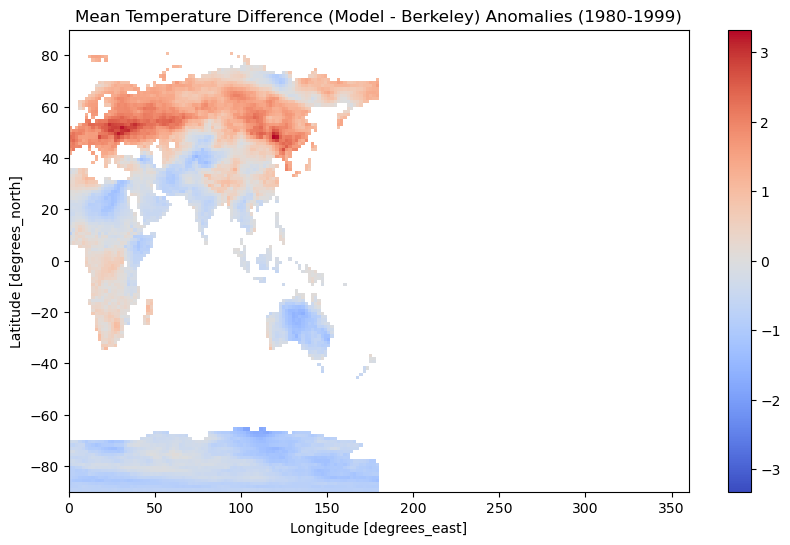

In [31]:
import matplotlib.pyplot as plt

# Calculate the mean difference over the 1980-1999 period
mean_difference = (model_anomalies.mean(dim='year') - expanded_berkeley_anomalies.mean(dim='year'))

# Plot the mean difference
plt.figure(figsize=(10, 6))
mean_difference.plot(cmap="coolwarm")
plt.title("Mean Temperature Difference (Model - Berkeley) Anomalies (1980-1999)")
plt.show()


In [33]:
# Calculate the mean offset
bias = model_global_mean.mean() - berkeley_global_mean.mean()
print(f"Mean bias (Model - Berkeley): {bias.values:.2f} °C")


Mean bias (Model - Berkeley): 0.03 °C


In [32]:
print("Time coordinate values after assignment:", berkeley_annual['time'].values)


Time coordinate values after assignment: []


Preprocessing model data...
Converting model longitudes from 0–360 to -180–180...
Preprocessing Berkeley data...
Constructing the 'time' coordinate from year, month, and day variables...
Adding climatology to anomalies to calculate absolute temperatures...
Creating `day_number` coordinate in climatology...


/home/a4wilson/anaconda3/envs/climate_nick/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Calculating metrics...
Averaging model data over the year dimension...
Subsetting to lat_range=(30, 60) and lon_range=(-180, 180)...
Averaging model data over the year dimension...
Subsetting to lat_range=(30, 60) and lon_range=(-180, 180)...
Averaging model data over the year dimension...
Subsetting to lat_range=(30, 60) and lon_range=(-180, 180)...

Metrics for Midlatitudes (90th, 98th, and 99th Percentiles):
percentile_90: RMSE = 3.29, R² = 0.71, Bias = 3.91
percentile_98: RMSE = 3.15, R² = 0.71, Bias = 0.39
percentile_99: RMSE = 3.14, R² = 0.70, Bias = -0.60
Creating maps...
Subsetting data to latitudes: (30, 60)


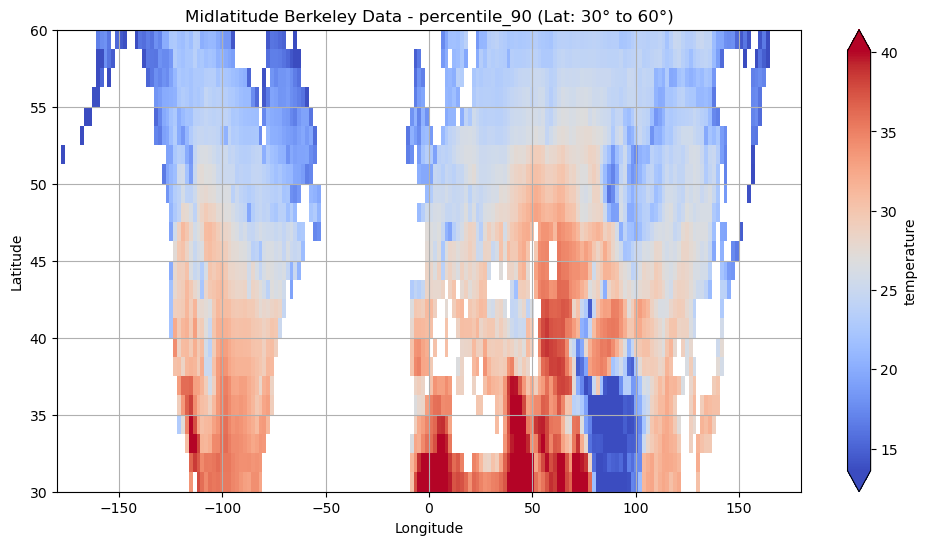

Subsetting data to latitudes: (30, 60)


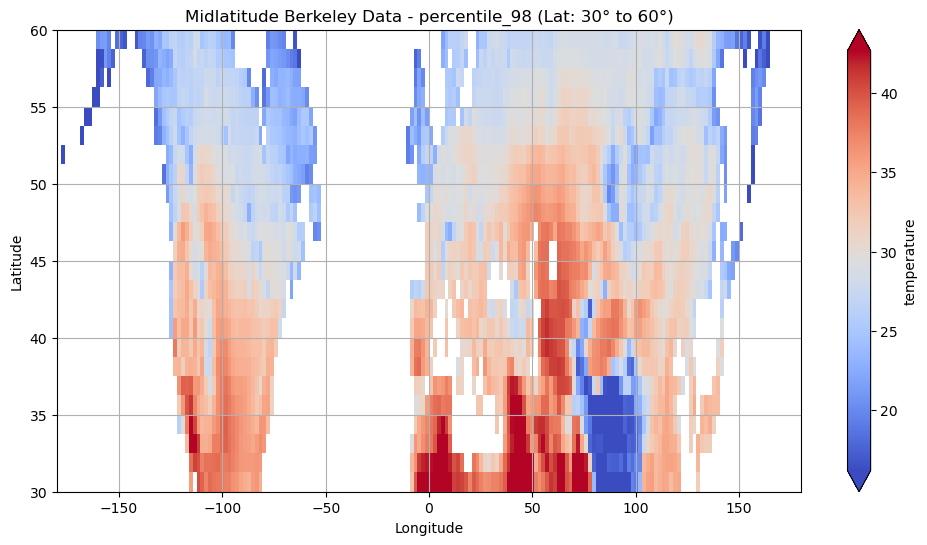

Subsetting data to latitudes: (30, 60)


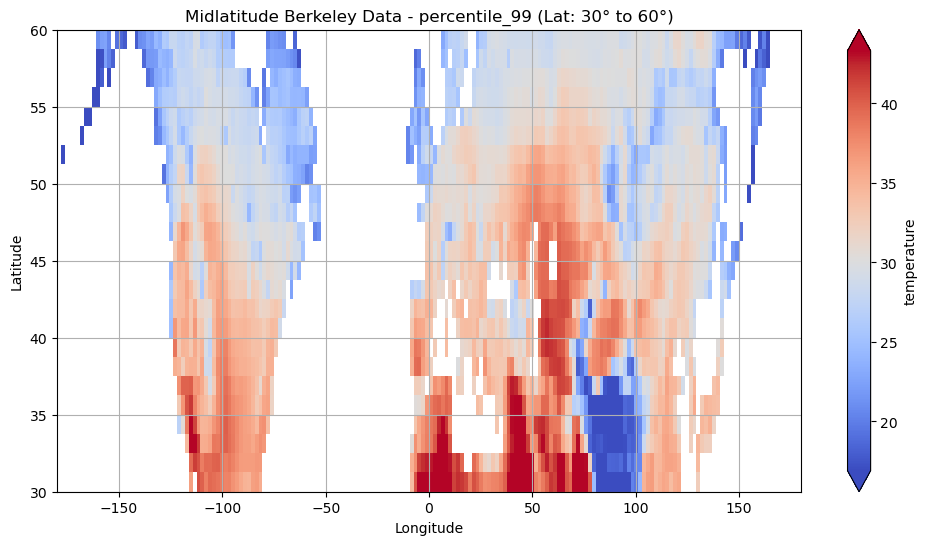

In [132]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# File paths
berkeley_file_with_climatology = "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc"
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def preprocess_model(model_filepath):
    print("Preprocessing model data...")
    model_ds = xr.open_dataset(model_filepath)

    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)

    model_ds = model_ds.sortby("lon")
    return model_ds


def preprocess_berkeley(berkeley_filepath, model_ds):
    print("Preprocessing Berkeley data...")
    berkeley_ds = xr.open_dataset(berkeley_filepath)
    berkeley_ds = berkeley_ds.rename({"latitude": "lat", "longitude": "lon"})

    if berkeley_ds["lon"].max() > 180:
        print("Converting Berkeley longitudes from 0–360 to -180–180...")
        berkeley_ds = berkeley_ds.assign_coords(lon=((berkeley_ds["lon"] + 180) % 360) - 180)

    berkeley_ds = berkeley_ds.sortby("lon")

    if "time" not in berkeley_ds.coords:
        print("Constructing the 'time' coordinate from year, month, and day variables...")
        time_values = pd.to_datetime(
            {
                "year": berkeley_ds["year"].values,
                "month": berkeley_ds["month"].values,
                "day": berkeley_ds["day"].values,
            }
        )
        berkeley_ds = berkeley_ds.assign_coords(time=("time", time_values))

    if "climatology" in berkeley_ds:
        print("Adding climatology to anomalies to calculate absolute temperatures...")
        if "day_number" not in berkeley_ds["climatology"].coords:
            print("Creating `day_number` coordinate in climatology...")
            day_dim = list(berkeley_ds["climatology"].dims)[0]
            berkeley_ds["climatology"] = berkeley_ds["climatology"].assign_coords(
                day_number=(day_dim, np.arange(1, berkeley_ds["climatology"].sizes[day_dim] + 1))
            )
        day_of_year = berkeley_ds["time"].dt.dayofyear
        day_of_year = day_of_year.where(day_of_year <= 365, 365)
        climatology_expanded = berkeley_ds["climatology"].sel(day_number=day_of_year, method="nearest")
        berkeley_ds["temperature"] = berkeley_ds["temperature"] + climatology_expanded

    percentiles = [0.9, 0.98, 0.99]
    results = {
        f"percentile_{int(p * 100)}": berkeley_ds["temperature"].quantile(p, dim="time", skipna=True)
        for p in percentiles
    }

    regridded_results = {
        k: v.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="nearest")
        for k, v in results.items()
    }

    return regridded_results


def calculate_metrics(berkeley_results, model_ds, lat_range=(30, 60), lon_range=(-180, 180)):
    print("Calculating metrics...")
    metrics = {}

    for key, berkeley_data in berkeley_results.items():
        model_data = model_ds["tasmax"]

        if "time" in model_data.dims:
            print("Averaging model data over the time dimension...")
            model_data = model_data.mean(dim="time")
        elif "year" in model_data.dims:
            print("Averaging model data over the year dimension...")
            model_data = model_data.mean(dim="year")

        print(f"Subsetting to lat_range={lat_range} and lon_range={lon_range}...")
        model_data = model_data.sel(lat=slice(*lat_range), lon=slice(*lon_range))
        berkeley_data = berkeley_data.sel(lat=slice(*lat_range), lon=slice(*lon_range))

        berkeley_data, model_data = xr.align(berkeley_data, model_data, join="inner")

        cos_lat_weights = np.cos(np.deg2rad(model_data["lat"])).values
        cos_lat_weights /= cos_lat_weights.sum()

        model_flat = model_data.values.ravel()
        berkeley_flat = berkeley_data.values.ravel()

        mask = np.isfinite(model_flat) & np.isfinite(berkeley_flat)
        model_flat = model_flat[mask]
        berkeley_flat = berkeley_flat[mask]

        if model_flat.size > 0:
            lat_weights_2d = np.tile(cos_lat_weights[:, np.newaxis], (1, model_data.shape[-1]))
            lat_weights_flat = lat_weights_2d.ravel()[mask]
            spatial_bias = np.average(model_flat - berkeley_flat, weights=lat_weights_flat)
            model_flat -= spatial_bias
            rmse = np.sqrt(mean_squared_error(berkeley_flat, model_flat))
            r2 = r2_score(berkeley_flat, model_flat)

            metrics[key] = {"Bias": spatial_bias, "RMSE": rmse, "R²": r2}

    return metrics


def plot_global_maps(data_dict, title_prefix="Percentile Map", lat_range=None):
    """
    Plot maps for global or restricted latitude data for each percentile result.
    
    Parameters:
    - data_dict: Dictionary of xarray DataArrays to plot.
    - title_prefix: Title prefix for each plot.
    - lat_range: Latitude range to restrict the data (tuple, e.g., (30, 60)).
    """
    print("Creating maps...")
    for key, data in data_dict.items():
        if lat_range:
            print(f"Subsetting data to latitudes: {lat_range}")
            data = data.sel(lat=slice(*lat_range))

        plt.figure(figsize=(12, 6))
        data.plot(cmap="coolwarm", robust=True)
        plt.title(f"{title_prefix} - {key}" + (f" (Lat: {lat_range[0]}° to {lat_range[1]}°)" if lat_range else ""))
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid()
        plt.show()


if __name__ == "__main__":
    # Preprocess model and Berkeley datasets
    model_ds = preprocess_model(model_file)
    berkeley_results = preprocess_berkeley(berkeley_file_with_climatology, model_ds)

    # Define lat/lon ranges for midlatitudes
    lat_range = (30, 60)  # Northern Hemisphere midlatitudes
    lon_range = (-180, 180)  # Global (both hemispheres)

    # Calculate metrics
    metrics = calculate_metrics(berkeley_results, model_ds, lat_range=lat_range, lon_range=lon_range)

    # Print metrics
    print("\nMetrics for Midlatitudes (90th, 98th, and 99th Percentiles):")
    for percentile, vals in metrics.items():
        print(f"{percentile}: RMSE = {vals['RMSE']:.2f}, R² = {vals['R²']:.2f}, Bias = {vals['Bias']:.2f}")

    # Plot maps for midlatitudes
    plot_global_maps(berkeley_results, title_prefix="Midlatitude Berkeley Data", lat_range=lat_range)


Preprocessing model data...
Converting model longitudes from 0–360 to -180–180...
Preprocessing Berkeley data...
Constructing the 'time' coordinate from year, month, and day variables...
Adding climatology to anomalies to calculate absolute temperatures...
Creating `day_number` coordinate in climatology...


/home/a4wilson/anaconda3/envs/climate_nick/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Calculating metrics...
Averaging model data over the year dimension...
Subsetting to lat_range=(-60, 60) and lon_range=(-180, 180)...
Averaging model data over the year dimension...
Subsetting to lat_range=(-60, 60) and lon_range=(-180, 180)...
Averaging model data over the year dimension...
Subsetting to lat_range=(-60, 60) and lon_range=(-180, 180)...

Metrics for Global Data Excluding Poles (90th, 98th, and 99th Percentiles):
percentile_90: RMSE = 3.24, R² = 0.78, Bias = 3.08
percentile_98: RMSE = 2.95, R² = 0.78, Bias = 0.66
percentile_99: RMSE = 2.95, R² = 0.78, Bias = -0.04
Creating maps...
Subsetting data to latitudes: (-60, 60)


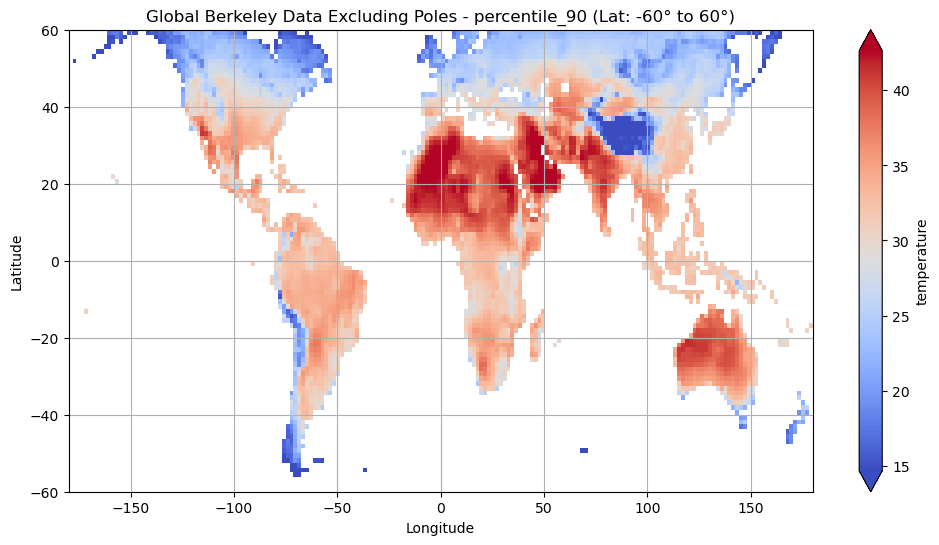

Subsetting data to latitudes: (-60, 60)


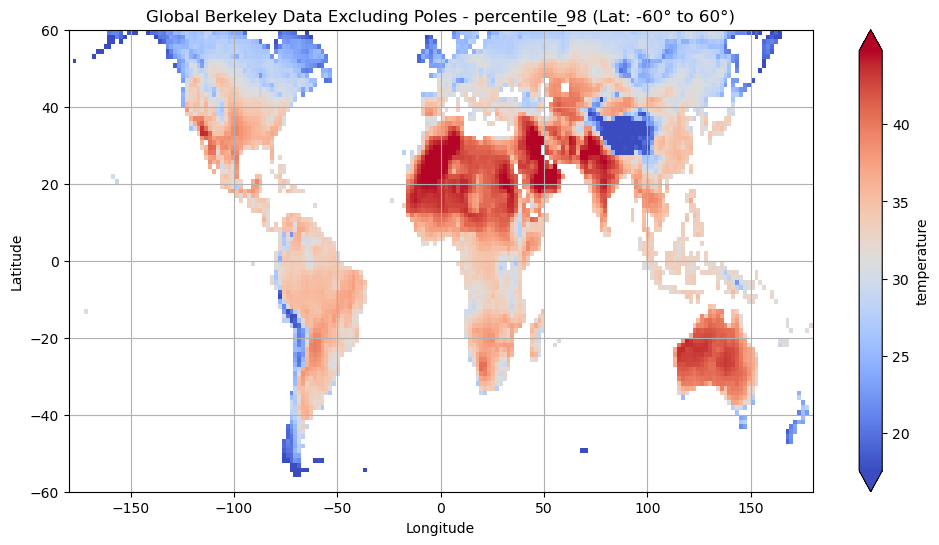

Subsetting data to latitudes: (-60, 60)


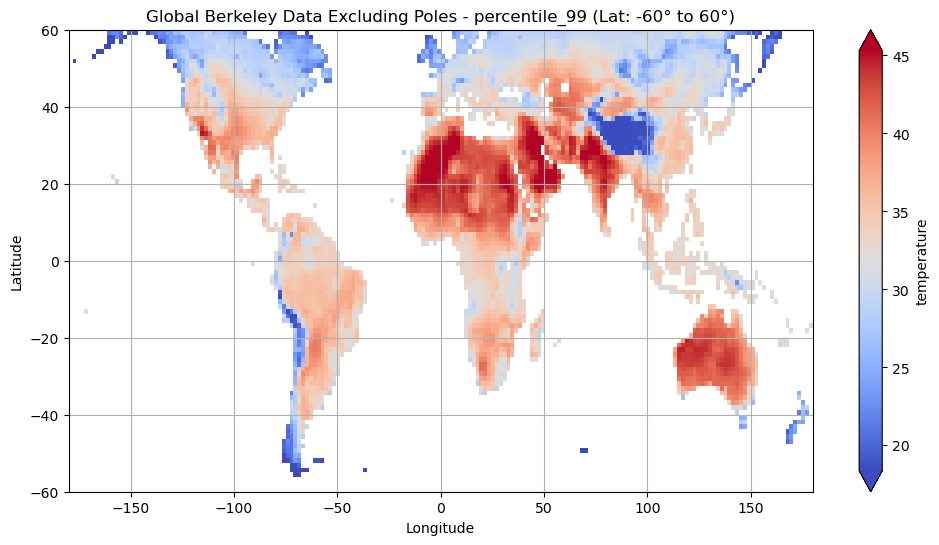

In [139]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

# File paths
berkeley_file_with_climatology = "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc"
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def preprocess_model(model_filepath):
    print("Preprocessing model data...")
    model_ds = xr.open_dataset(model_filepath)

    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)

    model_ds = model_ds.sortby("lon")
    return model_ds


def preprocess_berkeley(berkeley_filepath, model_ds):
    print("Preprocessing Berkeley data...")
    berkeley_ds = xr.open_dataset(berkeley_filepath)
    berkeley_ds = berkeley_ds.rename({"latitude": "lat", "longitude": "lon"})

    if berkeley_ds["lon"].max() > 180:
        print("Converting Berkeley longitudes from 0–360 to -180–180...")
        berkeley_ds = berkeley_ds.assign_coords(lon=((berkeley_ds["lon"] + 180) % 360) - 180)

    berkeley_ds = berkeley_ds.sortby("lon")

    if "time" not in berkeley_ds.coords:
        print("Constructing the 'time' coordinate from year, month, and day variables...")
        time_values = pd.to_datetime(
            {
                "year": berkeley_ds["year"].values,
                "month": berkeley_ds["month"].values,
                "day": berkeley_ds["day"].values,
            }
        )
        berkeley_ds = berkeley_ds.assign_coords(time=("time", time_values))

    if "climatology" in berkeley_ds:
        print("Adding climatology to anomalies to calculate absolute temperatures...")
        if "day_number" not in berkeley_ds["climatology"].coords:
            print("Creating `day_number` coordinate in climatology...")
            day_dim = list(berkeley_ds["climatology"].dims)[0]
            berkeley_ds["climatology"] = berkeley_ds["climatology"].assign_coords(
                day_number=(day_dim, np.arange(1, berkeley_ds["climatology"].sizes[day_dim] + 1))
            )
        day_of_year = berkeley_ds["time"].dt.dayofyear
        day_of_year = day_of_year.where(day_of_year <= 365, 365)
        climatology_expanded = berkeley_ds["climatology"].sel(day_number=day_of_year, method="nearest")
        berkeley_ds["temperature"] = berkeley_ds["temperature"] + climatology_expanded

    percentiles = [0.9, 0.98, 0.99]
    results = {
        f"percentile_{int(p * 100)}": berkeley_ds["temperature"].quantile(p, dim="time", skipna=True)
        for p in percentiles
    }

    regridded_results = {
        k: v.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="nearest")
        for k, v in results.items()
    }

    return regridded_results

def plot_global_maps(data_dict, title_prefix="Percentile Map", lat_range=(-60, 60), save_dir=None):
    """
    Plot maps for global data excluding the poles for each percentile result, with an option to save images.

    Parameters:
    - data_dict: Dictionary of xarray DataArrays to plot.
    - title_prefix: Title prefix for each plot.
    - lat_range: Latitude range to restrict the data (tuple, e.g., (-60, 60)).
    - save_dir: Directory to save the images. If None, images are not saved.
    """
    print("Creating maps...")
    for key, data in data_dict.items():
        print(f"Subsetting data to latitudes: {lat_range}")
        subset_data = data.sel(lat=slice(*lat_range))

        plt.figure(figsize=(12, 6))
        subset_data.plot(cmap="coolwarm", robust=True)
        region = f" (Lat: {lat_range[0]}° to {lat_range[1]}°)"
        plt.title(f"{title_prefix} - {key}{region}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.grid()

        # Save plot if save_dir is specified
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            file_name = f"{title_prefix.replace(' ', '_')}_{key}.png"
            file_path = os.path.join(save_dir, file_name)
            plt.savefig(file_path, dpi=300)
            print(f"Saved plot to {file_path}")

        plt.show()


if __name__ == "__main__":
    # Preprocess model and Berkeley datasets
    model_ds = preprocess_model(model_file)
    berkeley_results = preprocess_berkeley(berkeley_file_with_climatology, model_ds)

    # Define latitude and longitude range for global data excluding poles
    lat_range = (-60, 60)  # Global excluding poles
    lon_range = (-180, 180)  # Full longitude range

    # Calculate metrics
    metrics = calculate_metrics(berkeley_results, model_ds, lat_range=lat_range, lon_range=lon_range)

    # Print metrics
    print("\nMetrics for Global Data Excluding Poles (90th, 98th, and 99th Percentiles):")
    for percentile, vals in metrics.items():
        print(f"{percentile}: RMSE = {vals['RMSE']:.2f}, R² = {vals['R²']:.2f}, Bias = {vals['Bias']:.2f}")

    # Specify directory to save plots
    save_dir = "/home/a4wilson/historical/"

    # Plot and save maps excluding the poles
    plot_global_maps(berkeley_results, title_prefix="Global Berkeley Data Excluding Poles", lat_range=lat_range,)


Preprocessing model data...
Converting model longitudes from 0–360 to -180–180...
Preprocessing Berkeley data...
Constructing the 'time' coordinate from year, month, and day variables...
Adding climatology to anomalies to calculate absolute temperatures...
Creating `day_number` coordinate in climatology...


/home/a4wilson/anaconda3/envs/climate_nick/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Regridding Berkeley data to match model grid...


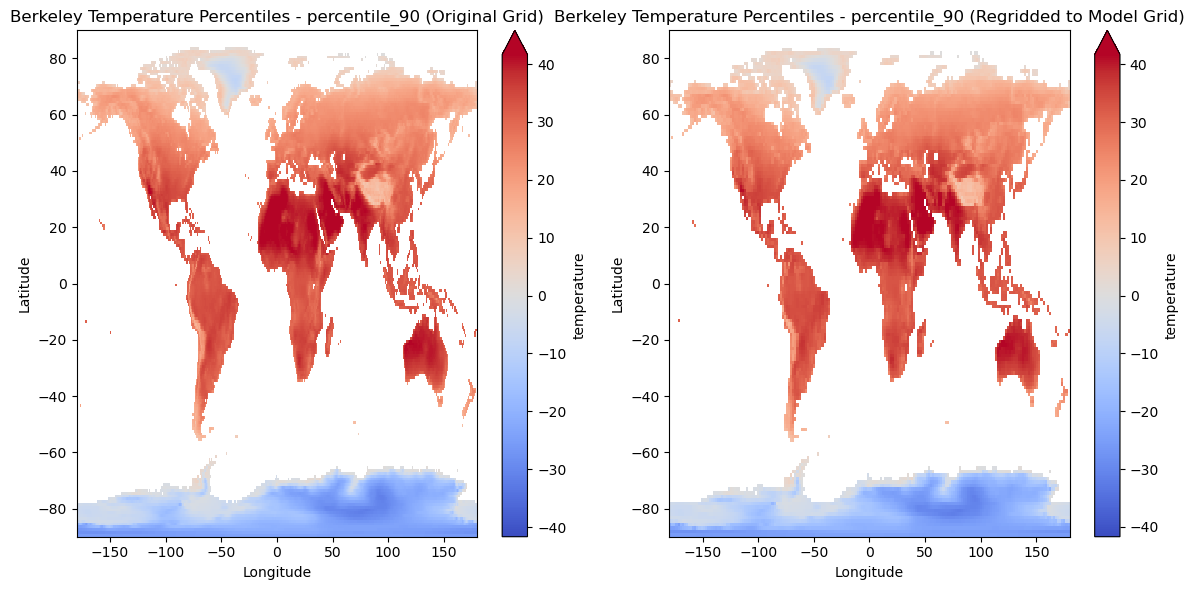

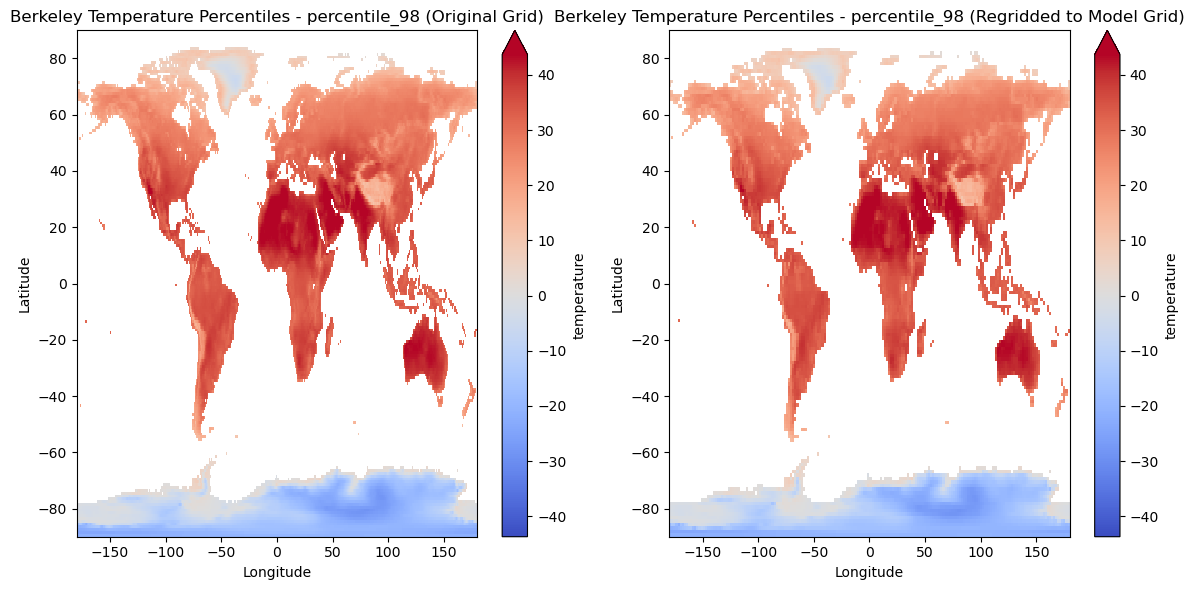

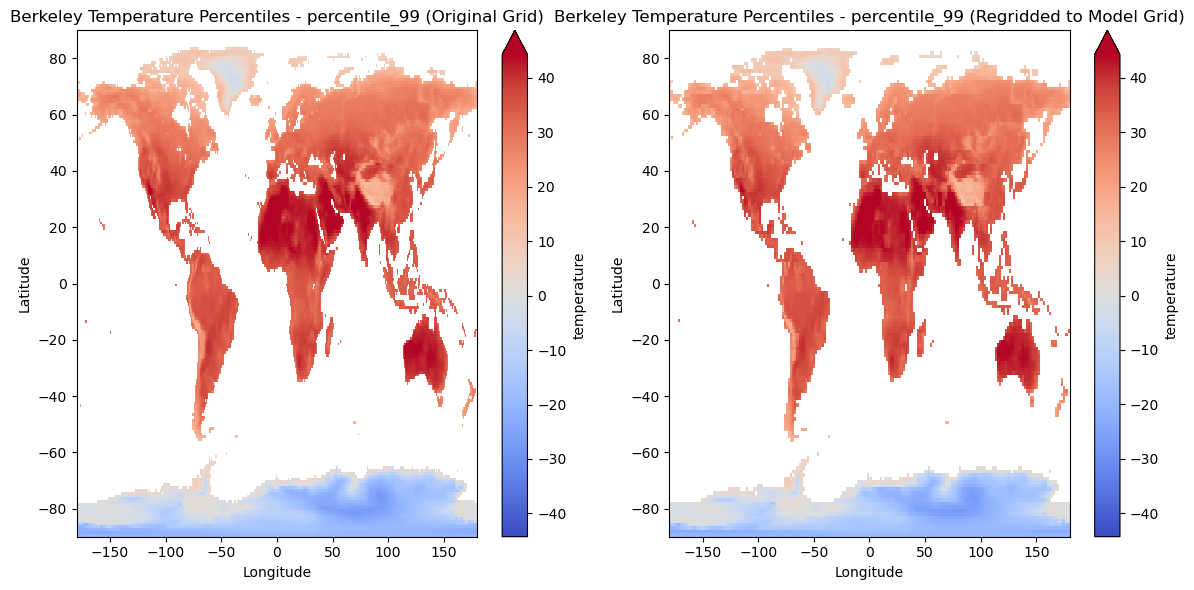

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os

# File paths
berkeley_file_with_climatology = "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc"
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def preprocess_model(model_filepath):
    print("Preprocessing model data...")
    model_ds = xr.open_dataset(model_filepath)

    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)

    model_ds = model_ds.sortby("lon")
    return model_ds

def preprocess_berkeley(berkeley_filepath):
    print("Preprocessing Berkeley data...")
    berkeley_ds = xr.open_dataset(berkeley_filepath)
    berkeley_ds = berkeley_ds.rename({"latitude": "lat", "longitude": "lon"})

    if berkeley_ds["lon"].max() > 180:
        print("Converting Berkeley longitudes from 0–360 to -180–180...")
        berkeley_ds = berkeley_ds.assign_coords(lon=((berkeley_ds["lon"] + 180) % 360) - 180)

    berkeley_ds = berkeley_ds.sortby("lon")

    if "time" not in berkeley_ds.coords:
        print("Constructing the 'time' coordinate from year, month, and day variables...")
        time_values = pd.to_datetime(
            {
                "year": berkeley_ds["year"].values,
                "month": berkeley_ds["month"].values,
                "day": berkeley_ds["day"].values,
            }
        )
        berkeley_ds = berkeley_ds.assign_coords(time=("time", time_values))

    if "climatology" in berkeley_ds:
        print("Adding climatology to anomalies to calculate absolute temperatures...")
        if "day_number" not in berkeley_ds["climatology"].coords:
            print("Creating `day_number` coordinate in climatology...")
            day_dim = list(berkeley_ds["climatology"].dims)[0]
            berkeley_ds["climatology"] = berkeley_ds["climatology"].assign_coords(
                day_number=(day_dim, np.arange(1, berkeley_ds["climatology"].sizes[day_dim] + 1))
            )
        day_of_year = berkeley_ds["time"].dt.dayofyear
        day_of_year = day_of_year.where(day_of_year <= 365, 365)
        climatology_expanded = berkeley_ds["climatology"].sel(day_number=day_of_year, method="nearest")
        berkeley_ds["temperature"] = berkeley_ds["temperature"] + climatology_expanded

    percentiles = [0.9, 0.98, 0.99]
    results = {
        f"percentile_{int(p * 100)}": berkeley_ds["temperature"].quantile(p, dim="time", skipna=True)
        for p in percentiles
    }

    return results, berkeley_ds

def plot_comparison(original_data, regridded_data, title_prefix="Percentile Map"):
    """
    Plot original and regridded data for comparison.

    Parameters:
    - original_data: Dictionary of original Berkeley data (percentiles).
    - regridded_data: Dictionary of regridded Berkeley data (percentiles).
    - title_prefix: Title prefix for each plot.
    """
    for key in original_data.keys():
        plt.figure(figsize=(12, 6))

        # Original data
        plt.subplot(1, 2, 1)
        original_data[key].plot(cmap="coolwarm", robust=True)
        plt.title(f"{title_prefix} - {key} (Original Grid)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")

        # Regridded data
        plt.subplot(1, 2, 2)
        regridded_data[key].plot(cmap="coolwarm", robust=True)
        plt.title(f"{title_prefix} - {key} (Regridded to Model Grid)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Preprocess model and Berkeley datasets
    model_ds = preprocess_model(model_file)
    berkeley_results_original, berkeley_ds_original = preprocess_berkeley(berkeley_file_with_climatology)

    # Regrid Berkeley data to match the model grid
    print("Regridding Berkeley data to match model grid...")
    berkeley_results_regridded = {
        k: v.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="nearest")
        for k, v in berkeley_results_original.items()
    }

    # Plot comparison of original and regridded data
    plot_comparison(berkeley_results_original, berkeley_results_regridded, title_prefix="Berkeley Temperature Percentiles")


Preprocessing model data...
Converting model longitudes from 0–360 to -180–180...
Preprocessing Berkeley data...
Constructing the 'time' coordinate from year, month, and day variables...
Adding climatology to anomalies to calculate absolute temperatures...
Creating `day_number` coordinate in climatology...


/home/a4wilson/anaconda3/envs/climate_nick/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Regridding Berkeley data to match model grid...
Saved plot to /home/a4wilson/historical/Berkeley_Temperature_Percentiles_percentile_90.png


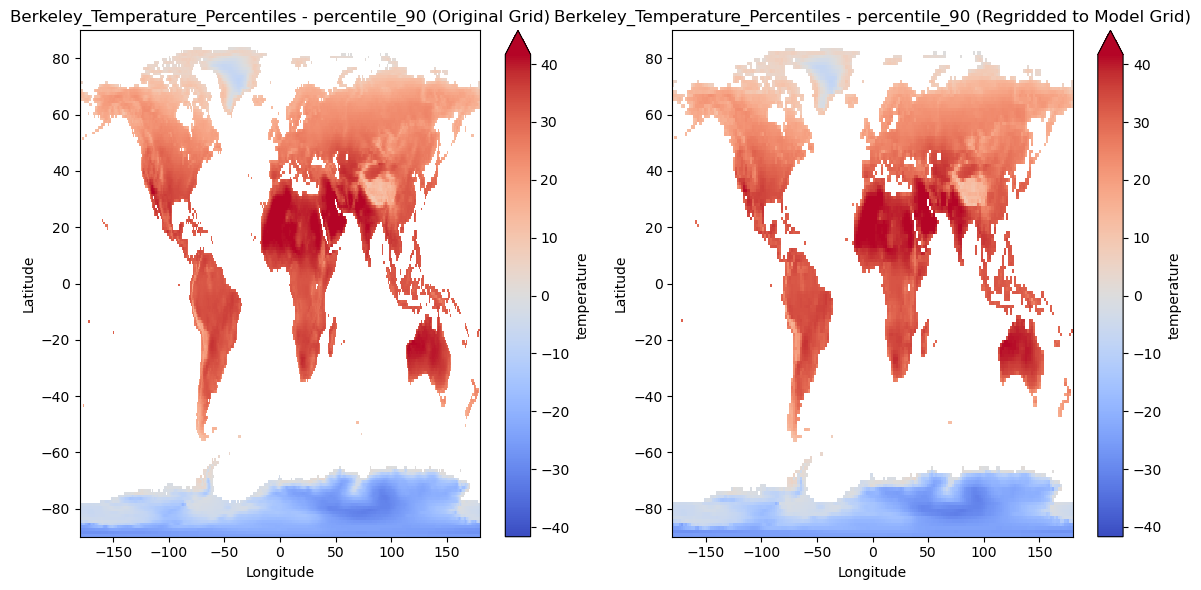

Saved plot to /home/a4wilson/historical/Berkeley_Temperature_Percentiles_percentile_98.png


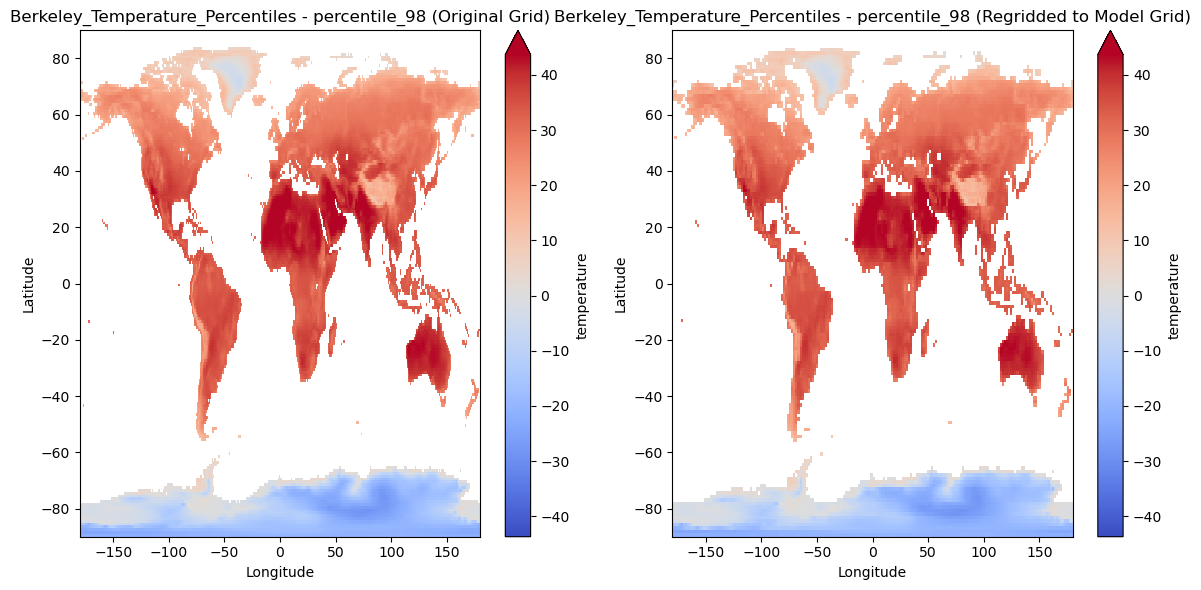

Saved plot to /home/a4wilson/historical/Berkeley_Temperature_Percentiles_percentile_99.png


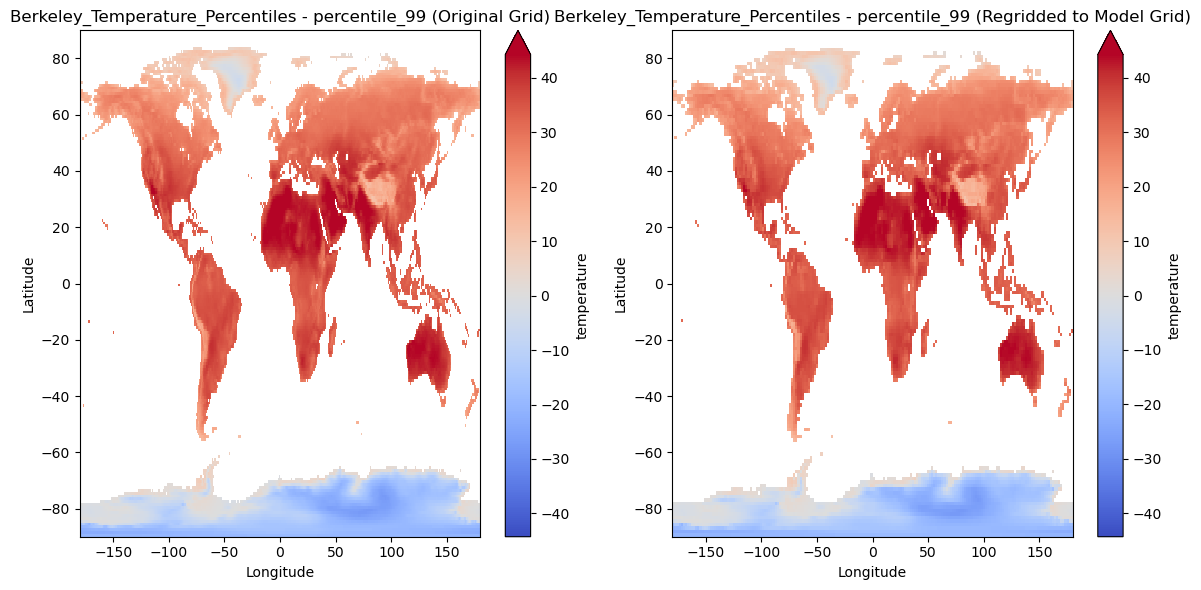

In [8]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs 

# File paths
berkeley_file_with_climatology = "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc"
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def preprocess_model(model_filepath):
    print("Preprocessing model data...")
    model_ds = xr.open_dataset(model_filepath)

    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)

    model_ds = model_ds.sortby("lon")
    return model_ds

def preprocess_berkeley(berkeley_filepath):
    print("Preprocessing Berkeley data...")
    berkeley_ds = xr.open_dataset(berkeley_filepath)
    berkeley_ds = berkeley_ds.rename({"latitude": "lat", "longitude": "lon"})

    if berkeley_ds["lon"].max() > 180:
        print("Converting Berkeley longitudes from 0–360 to -180–180...")
        berkeley_ds = berkeley_ds.assign_coords(lon=((berkeley_ds["lon"] + 180) % 360) - 180)

    berkeley_ds = berkeley_ds.sortby("lon")

    if "time" not in berkeley_ds.coords:
        print("Constructing the 'time' coordinate from year, month, and day variables...")
        time_values = pd.to_datetime(
            {
                "year": berkeley_ds["year"].values,
                "month": berkeley_ds["month"].values,
                "day": berkeley_ds["day"].values,
            }
        )
        berkeley_ds = berkeley_ds.assign_coords(time=("time", time_values))

    if "climatology" in berkeley_ds:
        print("Adding climatology to anomalies to calculate absolute temperatures...")
        if "day_number" not in berkeley_ds["climatology"].coords:
            print("Creating `day_number` coordinate in climatology...")
            day_dim = list(berkeley_ds["climatology"].dims)[0]
            berkeley_ds["climatology"] = berkeley_ds["climatology"].assign_coords(
                day_number=(day_dim, np.arange(1, berkeley_ds["climatology"].sizes[day_dim] + 1))
            )
        day_of_year = berkeley_ds["time"].dt.dayofyear
        day_of_year = day_of_year.where(day_of_year <= 365, 365)
        climatology_expanded = berkeley_ds["climatology"].sel(day_number=day_of_year, method="nearest")
        berkeley_ds["temperature"] = berkeley_ds["temperature"] + climatology_expanded

    percentiles = [0.9, 0.98, 0.99]
    results = {
        f"percentile_{int(p * 100)}": berkeley_ds["temperature"].quantile(p, dim="time", skipna=True)
        for p in percentiles
    }

    return results, berkeley_ds

def plot_comparison(original_data, regridded_data, save_dir, title_prefix="Percentile Map"):
    """
    Plot original and regridded data for comparison, and save the plots.

    Parameters:
    - original_data: Dictionary of original Berkeley data (percentiles).
    - regridded_data: Dictionary of regridded Berkeley data (percentiles).
    - save_dir: Directory to save the plots.
    - title_prefix: Title prefix for each plot.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists

    for key in original_data.keys():
        plt.figure(figsize=(12, 6))

        # Original data
        plt.subplot(1, 2, 1)
        original_data[key].plot(cmap="coolwarm", robust=True)
        plt.title(f"{title_prefix} - {key} (Original Grid)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")

        # Regridded data
        plt.subplot(1, 2, 2)
        regridded_data[key].plot(cmap="coolwarm", robust=True)
        plt.title(f"{title_prefix} - {key} (Regridded to Model Grid)")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")

        plt.tight_layout()

        # Save plot
        save_path = os.path.join(save_dir, f"{title_prefix.replace(' ', '_')}_{key}.png")
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot to {save_path}")

        plt.show()

if __name__ == "__main__":
    # Preprocess model and Berkeley datasets
    model_ds = preprocess_model(model_file)
    berkeley_results_original, berkeley_ds_original = preprocess_berkeley(berkeley_file_with_climatology)

    # Regrid Berkeley data to match the model grid
    print("Regridding Berkeley data to match model grid...")
    berkeley_results_regridded = {
        k: v.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="nearest")
        for k, v in berkeley_results_original.items()
    }

    # Directory to save plots
    save_dir = os.path.dirname(berkeley_file_with_climatology)

    # Plot and save comparison of original and regridded data
    plot_comparison(berkeley_results_original, berkeley_results_regridded, save_dir, title_prefix="Berkeley_Temperature_Percentiles")


In [3]:
def describe_model_grid(model_ds):
    """
    Describe the grid used for regridding from the model dataset.

    Parameters:
    - model_ds: xarray.Dataset representing the model data.

    Returns:
    - A dictionary with grid specifications.
    """
    grid_info = {
        "Longitude Range": (model_ds["lon"].min().item(), model_ds["lon"].max().item()),
        "Latitude Range": (model_ds["lat"].min().item(), model_ds["lat"].max().item()),
        "Longitude Resolution": abs(np.diff(model_ds["lon"].values).mean().item()),
        "Latitude Resolution": abs(np.diff(model_ds["lat"].values).mean().item()),
        "Grid Size": (len(model_ds["lat"]), len(model_ds["lon"])),
    }
    return grid_info

# Print the model grid details
model_grid = describe_model_grid(model_ds)
print("\nModel Grid Details (Used for Regridding):")
for key, value in model_grid.items():
    print(f"{key}: {value}")



Model Grid Details (Used for Regridding):
Longitude Range: (-179.0625, 179.0625)
Latitude Range: (-89.375, 89.375)
Longitude Resolution: 1.875
Latitude Resolution: 1.25
Grid Size: (144, 192)


Preprocessing model data...
Converting model longitudes from 0–360 to -180–180...
Preprocessing Berkeley data...
Constructing the 'time' coordinate from year, month, and day variables...
Adding climatology to anomalies to calculate absolute temperatures...
Creating `day_number` coordinate in climatology...


/home/a4wilson/anaconda3/envs/climate_nick/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Performing box averaging to regrid Berkeley data to match model grid...
Saved plot to /home/a4wilson/historical/Berkeley_Temperature_Percentiles_Box_Averaged_percentile_90.png


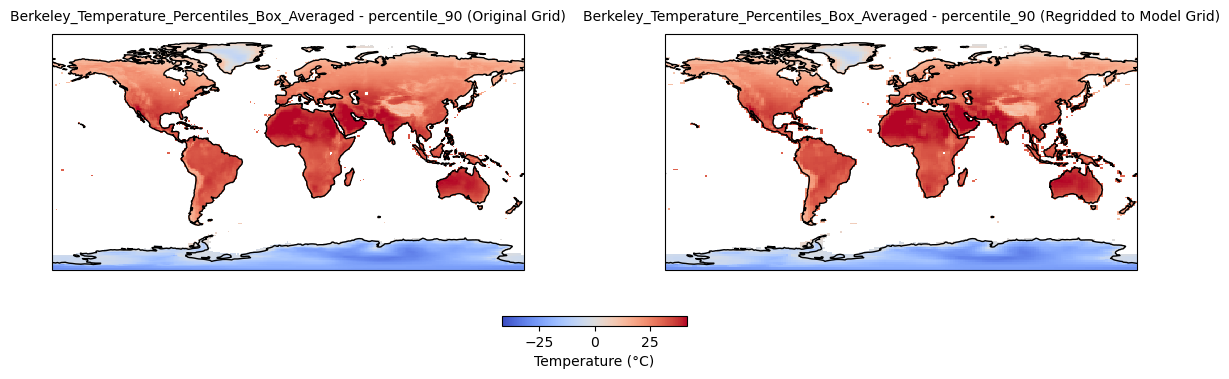

Saved plot to /home/a4wilson/historical/Berkeley_Temperature_Percentiles_Box_Averaged_percentile_98.png


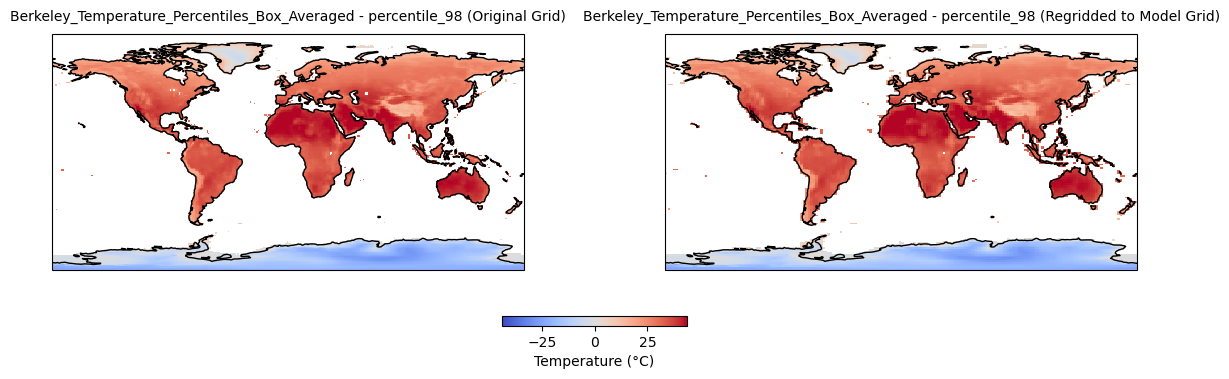

Saved plot to /home/a4wilson/historical/Berkeley_Temperature_Percentiles_Box_Averaged_percentile_99.png


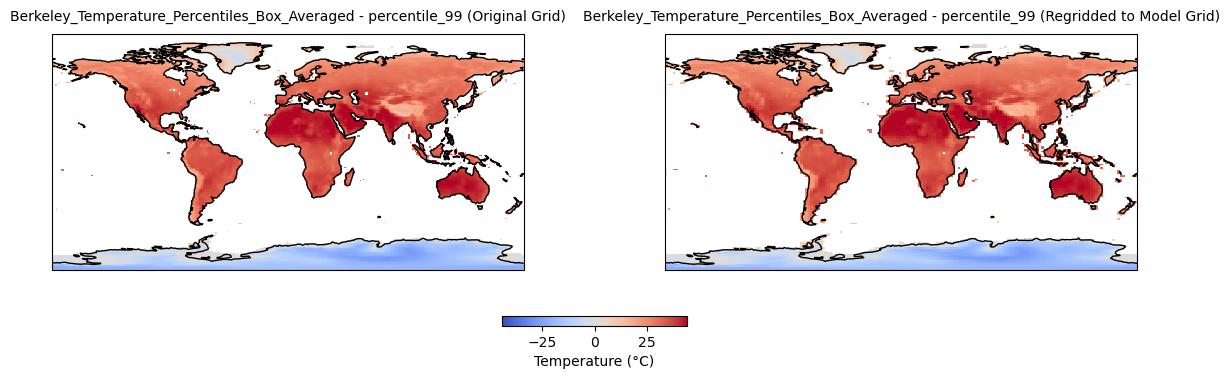

In [14]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs 

# File paths
berkeley_file_with_climatology = "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc"
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def preprocess_model(model_filepath):
    print("Preprocessing model data...")
    model_ds = xr.open_dataset(model_filepath)

    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)

    model_ds = model_ds.sortby("lon")
    return model_ds

def preprocess_berkeley(berkeley_filepath):
    print("Preprocessing Berkeley data...")
    berkeley_ds = xr.open_dataset(berkeley_filepath)
    berkeley_ds = berkeley_ds.rename({"latitude": "lat", "longitude": "lon"})

    if berkeley_ds["lon"].max() > 180:
        print("Converting Berkeley longitudes from 0–360 to -180–180...")
        berkeley_ds = berkeley_ds.assign_coords(lon=((berkeley_ds["lon"] + 180) % 360) - 180)

    berkeley_ds = berkeley_ds.sortby("lon")

    if "time" not in berkeley_ds.coords:
        print("Constructing the 'time' coordinate from year, month, and day variables...")
        time_values = pd.to_datetime(
            {
                "year": berkeley_ds["year"].values,
                "month": berkeley_ds["month"].values,
                "day": berkeley_ds["day"].values,
            }
        )
        berkeley_ds = berkeley_ds.assign_coords(time=("time", time_values))

    if "climatology" in berkeley_ds:
        print("Adding climatology to anomalies to calculate absolute temperatures...")
        if "day_number" not in berkeley_ds["climatology"].coords:
            print("Creating `day_number` coordinate in climatology...")
            day_dim = list(berkeley_ds["climatology"].dims)[0]
            berkeley_ds["climatology"] = berkeley_ds["climatology"].assign_coords(
                day_number=(day_dim, np.arange(1, berkeley_ds["climatology"].sizes[day_dim] + 1))
            )
        day_of_year = berkeley_ds["time"].dt.dayofyear
        day_of_year = day_of_year.where(day_of_year <= 365, 365)
        climatology_expanded = berkeley_ds["climatology"].sel(day_number=day_of_year, method="nearest")
        berkeley_ds["temperature"] = berkeley_ds["temperature"] + climatology_expanded

    percentiles = [0.9, 0.98, 0.99]
    results = {
        f"percentile_{int(p * 100)}": berkeley_ds["temperature"].quantile(p, dim="time", skipna=True)
        for p in percentiles
    }

    return results, berkeley_ds

def plot_comparison(original_data, regridded_data, save_dir, title_prefix="Percentile Map"):
    """
    Plot original and regridded data for comparison, and save the plots.

    Parameters:
    - original_data: Dictionary of original Berkeley data (percentiles).
    - regridded_data: Dictionary of regridded Berkeley data (percentiles).
    - save_dir: Directory to save the plots.
    - title_prefix: Title prefix for each plot.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists

    for key in original_data.keys():
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        plt.subplots_adjust(wspace=0.3)  # Add horizontal space between plots

        # Original data
        ax1 = axes[0]
        original_data[key].plot(
            ax=ax1,
            cmap="coolwarm",
            robust=True,
            add_colorbar=False,
        )
        ax1.coastlines()
        ax1.set_title(f"{title_prefix} - {key} (Original Grid)")
        ax1.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
        
        # Regridded data
        ax2 = axes[1]
        regridded_data[key].plot(
            ax=ax2,
            cmap="coolwarm",
            robust=True,
            add_colorbar=False,
        )
        ax2.coastlines()
        ax2.set_title(f"{title_prefix} - {key} (Regridded to Model Grid)")
        gl = ax2.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
        gl.right_labels = False  # Disable right labels
        gl.top_labels = False  # Disable top labels
        
        # Adjust gridline labels to prevent overlap
        gl.xlabel_style = {'size': 8, 'rotation': 45}  # Rotate and resize x-axis labels
        gl.ylabel_style = {'size': 8}  # Resize y-axis labels

        # Add a shared colorbar
        cbar = fig.colorbar(
            ax1.get_images()[0], ax=axes, orientation='horizontal', pad=0.1, fraction=0.02
        )
        cbar.set_label("Temperature (°C)")

        # Save plot
        save_path = os.path.join(save_dir, f"{title_prefix.replace(' ', '_')}_{key}.png")
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved plot to {save_path}")

        plt.show()

def plot_comparison(original_data, regridded_data, save_dir, title_prefix="Percentile Map"):
    """
    Plot original and regridded data for comparison, and save the plots.

    Parameters:
    - original_data: Dictionary of original Berkeley data (percentiles).
    - regridded_data: Dictionary of regridded Berkeley data (percentiles).
    - save_dir: Directory to save the plots.
    - title_prefix: Title prefix for each plot.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists

    for key in original_data.keys():
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        plt.subplots_adjust(wspace=0.3)  # Add horizontal space between plots

        valid_plot = False  # Track if any valid plot is created

        # Original data
        ax1 = axes[0]
        ax1.coastlines()
        try:
            img1 = original_data[key].plot(
                ax=ax1,
                cmap="coolwarm",
                robust=True,
                add_colorbar=False,
            )
            ax1.set_title(f"{title_prefix} - {key} (Original Grid)", fontsize=10, pad=10)
            valid_plot = True
        except Exception as e:
            print(f"Error plotting original data for {key}: {e}")

        # Regridded data
        ax2 = axes[1]
        ax2.coastlines()
        try:
            img2 = regridded_data[key].plot(
                ax=ax2,
                cmap="coolwarm",
                robust=True,
                add_colorbar=False,
            )
            ax2.set_title(f"{title_prefix} - {key} (Regridded to Model Grid)", fontsize=10, pad=10)
            valid_plot = True
        except Exception as e:
            print(f"Error plotting regridded data for {key}: {e}")

        # Add shared colorbar
        if valid_plot:
            try:
                cbar = fig.colorbar(
                    img1, ax=axes, orientation='horizontal', pad=0.1, fraction=0.02
                )
                cbar.set_label("Temperature (°C)")
            except Exception as e:
                print(f"Error adding colorbar for {key}: {e}")

        # Save plot if valid
        if valid_plot:
            save_path = os.path.join(save_dir, f"{title_prefix.replace(' ', '_')}_{key}.png")
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"Saved plot to {save_path}")

        plt.show()


if __name__ == "__main__":
    # Preprocess model and Berkeley datasets
    model_ds = preprocess_model(model_file)
    berkeley_results_original, berkeley_ds_original = preprocess_berkeley(berkeley_file_with_climatology)

    # Perform box averaging to regrid Berkeley data to model grid
    print("Performing box averaging to regrid Berkeley data to match model grid...")
    berkeley_results_regridded = {
        key: box_average_regrid(val, model_ds["lat"].values, model_ds["lon"].values)
        for key, val in berkeley_results_original.items()
    }

    # Directory to save plots
    save_dir = os.path.dirname(berkeley_file_with_climatology)

    # Plot and save comparison of original and box-averaged data
    plot_comparison(berkeley_results_original, berkeley_results_regridded, save_dir, title_prefix="Berkeley_Temperature_Percentiles_Box_Averaged")


Starting workflow...
Preprocessing model data...
Converting model longitudes from 0–360 to -180–180...
Preprocessing Berkeley data...
Constructing the 'time' coordinate from year, month, and day variables...
Adding climatology to anomalies to calculate absolute temperatures...
Creating `day_number` coordinate in climatology...
Calculating percentiles...


/home/a4wilson/anaconda3/envs/climate_nick/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Performing box averaging using coarsen...
Performing box averaging using coarsen...
Performing box averaging using coarsen...
Intercomparison Results:
90th vs. 98th Percentile Metrics: {'RMSE': 3.4526471117333197, 'R²': 0.9737143831383971, 'Bias': -3.1526982102252044}
90th vs. 99th Percentile Metrics: {'RMSE': 4.413973287914279, 'R²': 0.9570391178897095, 'Bias': -4.0431461070349775}
98th vs. 99th Percentile Metrics: {'RMSE': 0.977218074195722, 'R²': 0.9978331062549394, 'Bias': -0.8904478968097725}
Plot saved to 90_vs_98_percentile.png
Plot saved to 90_vs_99_percentile.png
Plot saved to 98_vs_99_percentile.png


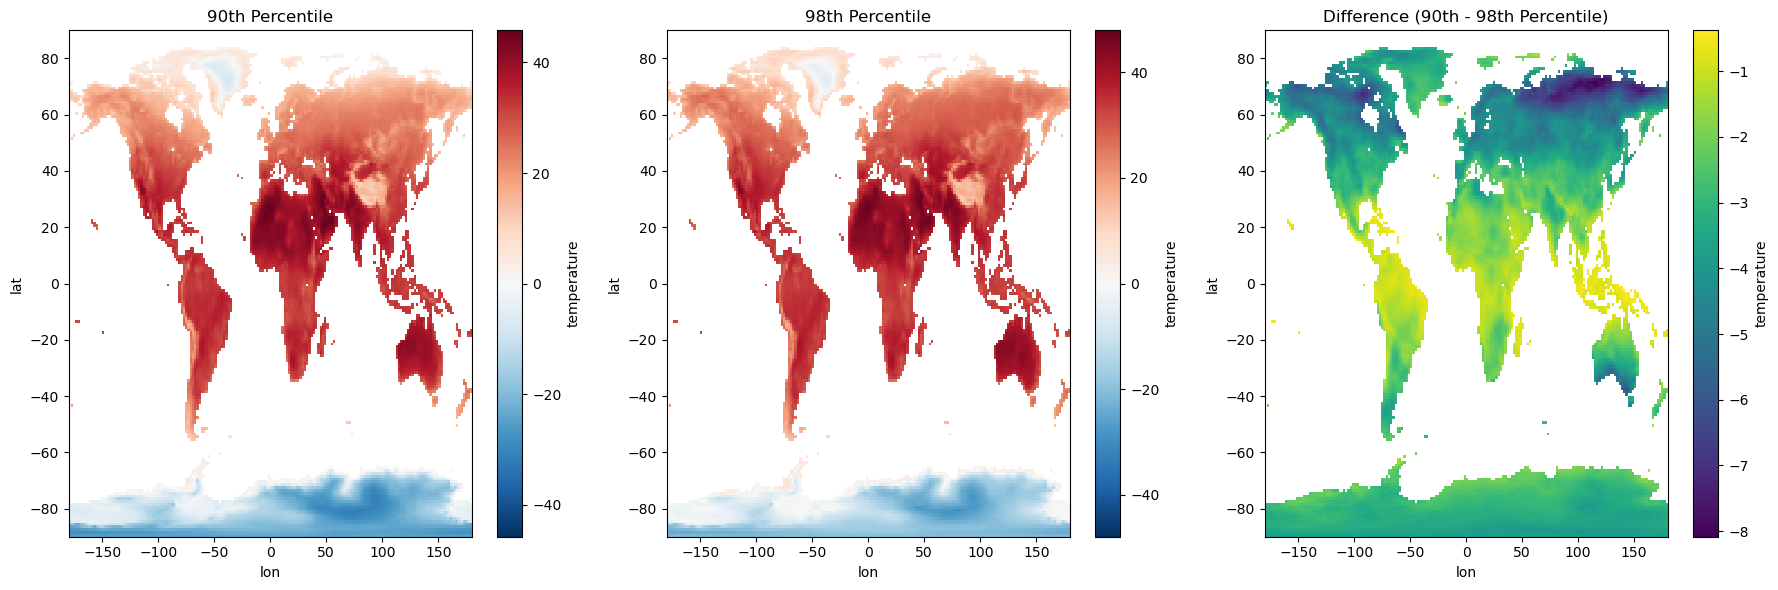

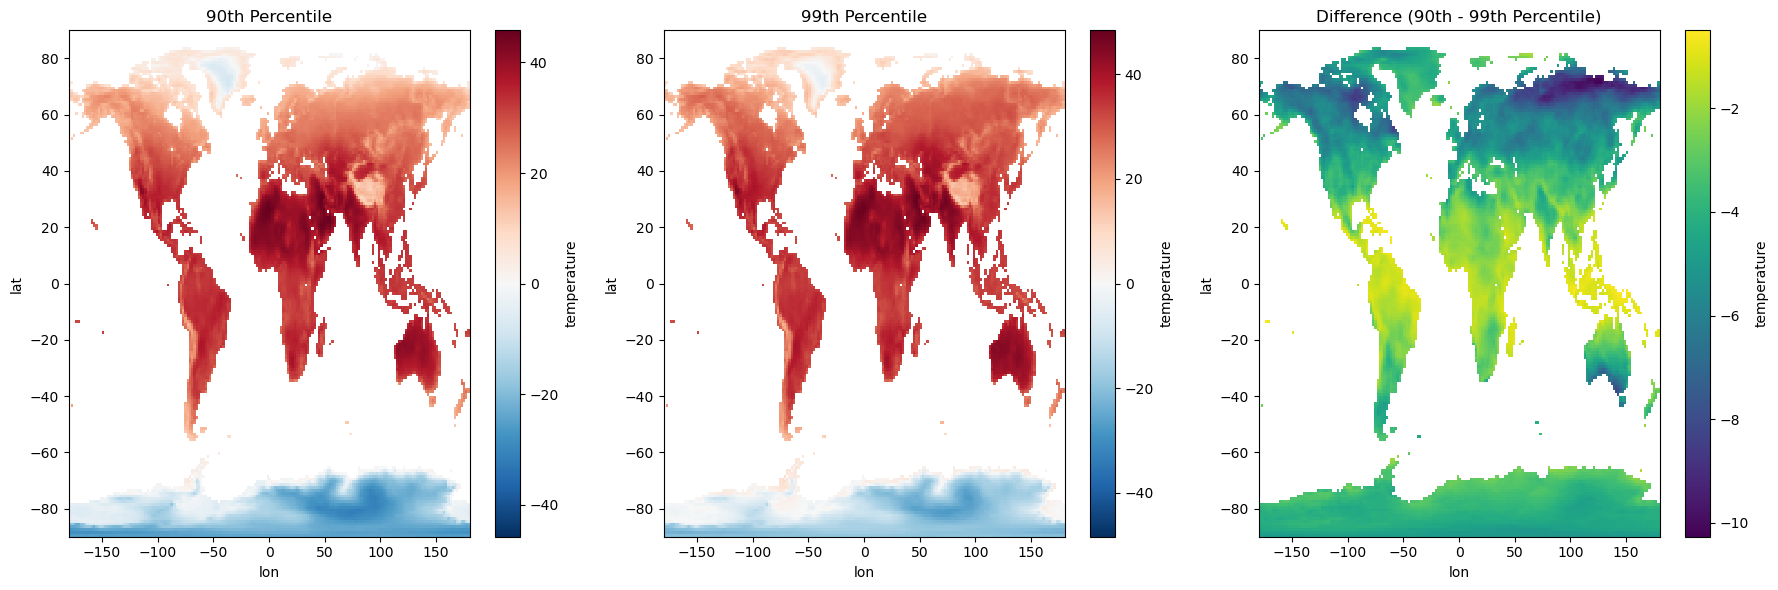

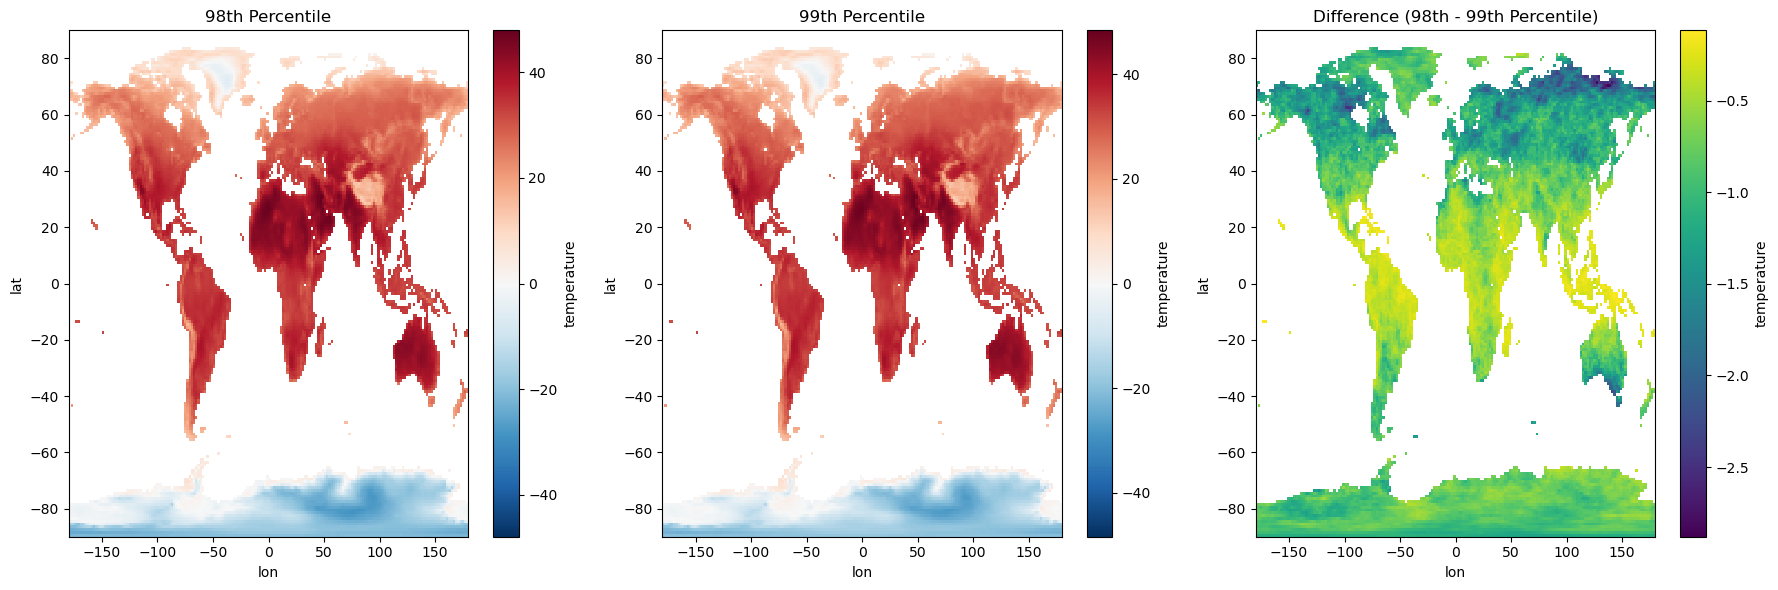

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.metrics import mean_squared_error, r2_score

# File paths
berkeley_file_with_climatology = "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc"
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def preprocess_model(model_filepath):
    print("Preprocessing model data...")
    model_ds = xr.open_dataset(model_filepath)

    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)

    model_ds = model_ds.sortby("lon")
    return model_ds

def preprocess_berkeley(berkeley_filepath):
    print("Preprocessing Berkeley data...")
    berkeley_ds = xr.open_dataset(berkeley_filepath)
    berkeley_ds = berkeley_ds.rename({"latitude": "lat", "longitude": "lon"})

    if berkeley_ds["lon"].max() > 180:
        print("Converting Berkeley longitudes from 0–360 to -180–180...")
        berkeley_ds = berkeley_ds.assign_coords(lon=((berkeley_ds["lon"] + 180) % 360) - 180)

    berkeley_ds = berkeley_ds.sortby("lon")

    if "time" not in berkeley_ds.coords:
        print("Constructing the 'time' coordinate from year, month, and day variables...")
        time_values = pd.to_datetime(
            {
                "year": berkeley_ds["year"].values,
                "month": berkeley_ds["month"].values,
                "day": berkeley_ds["day"].values,
            }
        )
        berkeley_ds = berkeley_ds.assign_coords(time=("time", time_values))

    if "climatology" in berkeley_ds:
        print("Adding climatology to anomalies to calculate absolute temperatures...")
        if "day_number" not in berkeley_ds["climatology"].coords:
            print("Creating `day_number` coordinate in climatology...")
            day_dim = list(berkeley_ds["climatology"].dims)[0]
            berkeley_ds["climatology"] = berkeley_ds["climatology"].assign_coords(
                day_number=(day_dim, np.arange(1, berkeley_ds["climatology"].sizes[day_dim] + 1))
            )
        day_of_year = berkeley_ds["time"].dt.dayofyear
        day_of_year = day_of_year.where(day_of_year <= 365, 365)
        climatology_expanded = berkeley_ds["climatology"].sel(day_number=day_of_year, method="nearest")
        berkeley_ds["temperature"] = berkeley_ds["temperature"] + climatology_expanded

    return berkeley_ds

def calculate_percentiles(data):
    print("Calculating percentiles...")
    percentiles = [0.9, 0.98, 0.99]
    return {
        f"percentile_{int(p * 100)}": data["temperature"].quantile(p, dim="time", skipna=True)
        for p in percentiles
    }

def box_average_regrid(original_data, target_lat, target_lon):
    print("Performing box averaging using coarsen...")
    lat_res = abs(target_lat[1] - target_lat[0])
    lon_res = abs(target_lon[1] - target_lon[0])

    lat_factor = int(np.round(lat_res / abs(original_data.lat.diff(dim="lat").mean().values)))
    lon_factor = int(np.round(lon_res / abs(original_data.lon.diff(dim="lon").mean().values)))

    coarsened_data = original_data.coarsen(lat=lat_factor, lon=lon_factor, boundary="trim").mean()
    coarsened_lat = coarsened_data.lat.values
    coarsened_lon = coarsened_data.lon.values

    regridded_data = coarsened_data.assign_coords(lat=coarsened_lat, lon=coarsened_lon)
    return regridded_data

def calculate_metrics(field1, field2):
    field1_flat = field1.values.ravel()
    field2_flat = field2.values.ravel()
    mask = np.isfinite(field1_flat) & np.isfinite(field2_flat)
    field1_flat = field1_flat[mask]
    field2_flat = field2_flat[mask]

    bias = np.mean(field1_flat - field2_flat)
    rmse = np.sqrt(mean_squared_error(field1_flat, field2_flat))
    r2 = r2_score(field1_flat, field2_flat)

    return {"RMSE": rmse, "R²": r2, "Bias": bias}

def plot_comparison(data1, data2, diff, title1, title2, diff_title, save_path=None):
    plt.figure(figsize=(18, 6))

    # Plot first dataset
    plt.subplot(1, 3, 1)
    data1.plot()
    plt.title(title1)

    # Plot second dataset
    plt.subplot(1, 3, 2)
    data2.plot()
    plt.title(title2)

    # Plot difference
    plt.subplot(1, 3, 3)
    diff.plot()
    plt.title(diff_title)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

# Main workflow
print("Starting workflow...")
model_ds = preprocess_model(model_file)
berkeley_ds = preprocess_berkeley(berkeley_file_with_climatology)

# Calculate percentiles on original Berkeley data
berkeley_results_original = calculate_percentiles(berkeley_ds)

# Perform box averaging to regrid Berkeley data
berkeley_results_regridded = {
    key: box_average_regrid(val, model_ds["lat"].values, model_ds["lon"].values)
    for key, val in berkeley_results_original.items()
}

# Calculate metrics
metrics_90_98 = calculate_metrics(berkeley_results_regridded["percentile_90"], berkeley_results_regridded["percentile_98"])
metrics_90_99 = calculate_metrics(berkeley_results_regridded["percentile_90"], berkeley_results_regridded["percentile_99"])
metrics_98_99 = calculate_metrics(berkeley_results_regridded["percentile_98"], berkeley_results_regridded["percentile_99"])

print("Intercomparison Results:")
print("90th vs. 98th Percentile Metrics:", metrics_90_98)
print("90th vs. 99th Percentile Metrics:", metrics_90_99)
print("98th vs. 99th Percentile Metrics:", metrics_98_99)

# Plotting comparisons
plot_comparison(
    berkeley_results_regridded["percentile_90"],
    berkeley_results_regridded["percentile_98"],
    berkeley_results_regridded["percentile_90"] - berkeley_results_regridded["percentile_98"],
    "90th Percentile",
    "98th Percentile",
    "Difference (90th - 98th Percentile)",
    save_path="90_vs_98_percentile.png"
)

plot_comparison(
    berkeley_results_regridded["percentile_90"],
    berkeley_results_regridded["percentile_99"],
    berkeley_results_regridded["percentile_90"] - berkeley_results_regridded["percentile_99"],
    "90th Percentile",
    "99th Percentile",
    "Difference (90th - 99th Percentile)",
    save_path="90_vs_99_percentile.png"
)

plot_comparison(
    berkeley_results_regridded["percentile_98"],
    berkeley_results_regridded["percentile_99"],
    berkeley_results_regridded["percentile_98"] - berkeley_results_regridded["percentile_99"],
    "98th Percentile",
    "99th Percentile",
    "Difference (98th - 99th Percentile)",
    save_path="98_vs_99_percentile.png"
)


/tmp/ipykernel_2150859/4209576404.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  total_days = sum(xr.open_dataset(fp).dims["time"] for fp in file_paths)


Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc
Fixing 'time' coordinate...
Assigning 'day_number' as a coordinate...
Min/Max Climatology: -64.43389892578125, 46.363525390625
Min/Max Temperature: -29.085803985595703, 29.766633987426758
NaNs in Climatology Expanded: 147865828
NaNs in Temperature Absolute: 148310820
Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2000.nc
Fixing 'time' coordinate...
Assigning 'day_number' as a coordinate...
Min/Max Climatology: -64.43389892578125, 46.363525390625
Min/Max Temperature: -33.55406951904297, 30.364940643310547
NaNs in Climatology Expanded: 147906317
NaNs in Temperature Absolute: 147937618
Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2010.nc
Fixing 'time' coordinate...
Assigning 'day_number' as a coordinate...
Min/Max Climatology: -64.43389892578125, 46.363525390625
Min/Max Temperature: -28.709741592407227, 30.52278709411621
NaNs in Climatology Expanded: 14786582

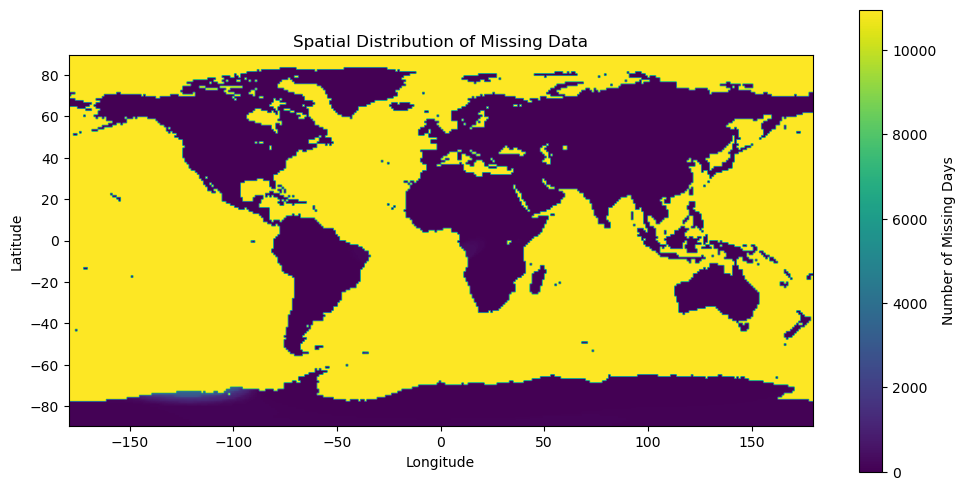

In [12]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define file paths
file_paths = [
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc",
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2000.nc",
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2010.nc"
]

# Calculate the total number of days dynamically
total_days = sum(xr.open_dataset(fp).dims["time"] for fp in file_paths)

# Initialize the temporary array for all data
temps = np.zeros((total_days, 180, 360), dtype=np.float32)

# Temporary pointer to manage indices in the array
current_index = 0

# Process each file sequentially
for i, file_path in enumerate(file_paths):
    print(f"Processing file: {file_path}")
    ds = xr.open_dataset(file_path)
    
    # Fix 'time' coordinate if not present
    if "time" not in ds.coords:
        print("Fixing 'time' coordinate...")
        time_values = pd.to_datetime(
            {"year": ds["year"].values, "month": ds["month"].values, "day": ds["day"].values}
        )
        ds = ds.assign_coords(time=("time", time_values))
    
    # Ensure 'day_number' is a coordinate
    if "day_number" not in ds["climatology"].coords:
        print("Assigning 'day_number' as a coordinate...")
        ds["climatology"] = ds["climatology"].assign_coords(
            day_number=("day_number", np.arange(1, 366))
        )
    
    # Add climatology to temperature
    climatology = ds["climatology"]
    day_of_year = ds["time"].dt.dayofyear.where(ds["time"].dt.dayofyear <= 365, 365)
    climatology_expanded = climatology.sel(day_number=day_of_year, method="nearest")
    temperature_absolute = ds["temperature"] + climatology_expanded

    # Diagnostics
    print(f"Min/Max Climatology: {climatology.min().values}, {climatology.max().values}")
    print(f"Min/Max Temperature: {ds['temperature'].min().values}, {ds['temperature'].max().values}")
    print(f"NaNs in Climatology Expanded: {np.isnan(climatology_expanded).sum().values}")
    print(f"NaNs in Temperature Absolute: {np.isnan(temperature_absolute).sum().values}")

    # Save temperature_absolute to temps
    num_days = temperature_absolute.shape[0]
    temps[current_index:current_index + num_days] = temperature_absolute.values
    current_index += num_days
    
    # Close the file to save memory
    ds.close()

# Plot NaN locations
nan_map = np.isnan(temps).sum(axis=0)
plt.figure(figsize=(12, 6))
plt.imshow(nan_map, origin="lower", extent=(-179.5, 179.5, -89.5, 89.5), cmap="viridis")
plt.colorbar(label="Number of Missing Days")
plt.title("Spatial Distribution of Missing Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


/tmp/ipykernel_2150859/3400041680.py:22: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  total_days = sum(xr.open_dataset(fp).dims["time"] for fp in file_paths)


Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc
Fixing 'time' coordinate...
Assigning 'day_number' as a coordinate...
NaNs in Climatology Expanded: <xarray.DataArray 'climatology' ()> Size: 8B
array(147865828)
NaNs in Temperature Absolute: <xarray.DataArray ()> Size: 8B
array(148310820)
Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2000.nc
Fixing 'time' coordinate...
Assigning 'day_number' as a coordinate...
NaNs in Climatology Expanded: <xarray.DataArray 'climatology' ()> Size: 8B
array(147906317)
NaNs in Temperature Absolute: <xarray.DataArray ()> Size: 8B
array(147937618)
Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2010.nc
Fixing 'time' coordinate...
Assigning 'day_number' as a coordinate...
NaNs in Climatology Expanded: <xarray.DataArray 'climatology' ()> Size: 8B
array(147865828)
NaNs in Temperature Absolute: <xarray.DataArray ()> Size: 8B
array(148133062)
Calculating the 95th percentile...


/home/a4wilson/anaconda3/envs/climate_nick/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Saving the 95th percentile data to /home/a4wilson/historical/temps_95th_percentile.nc...
95th percentile data successfully saved to /home/a4wilson/historical/temps_95th_percentile.nc.


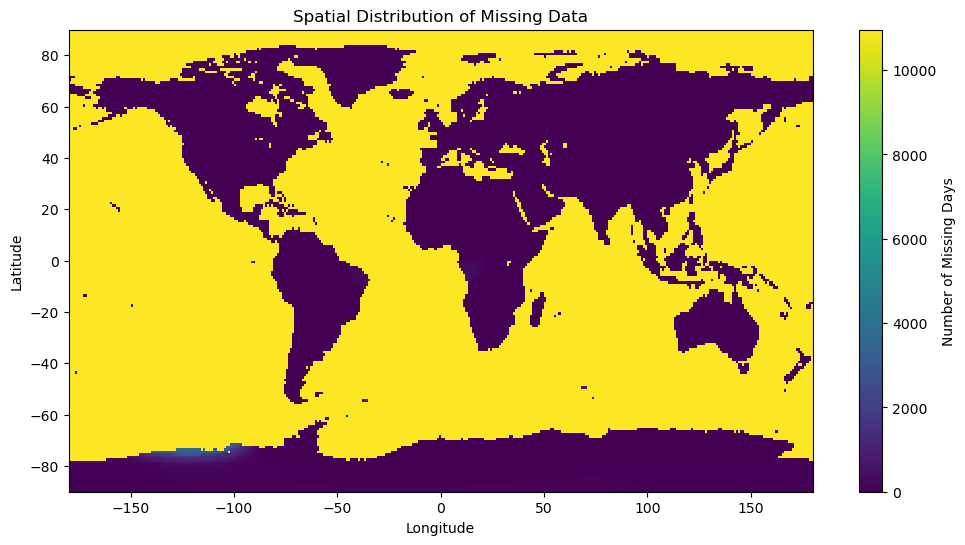

Box-averaged data saved to /home/a4wilson/historical/temps_95th_percentile_box_avg.nc.


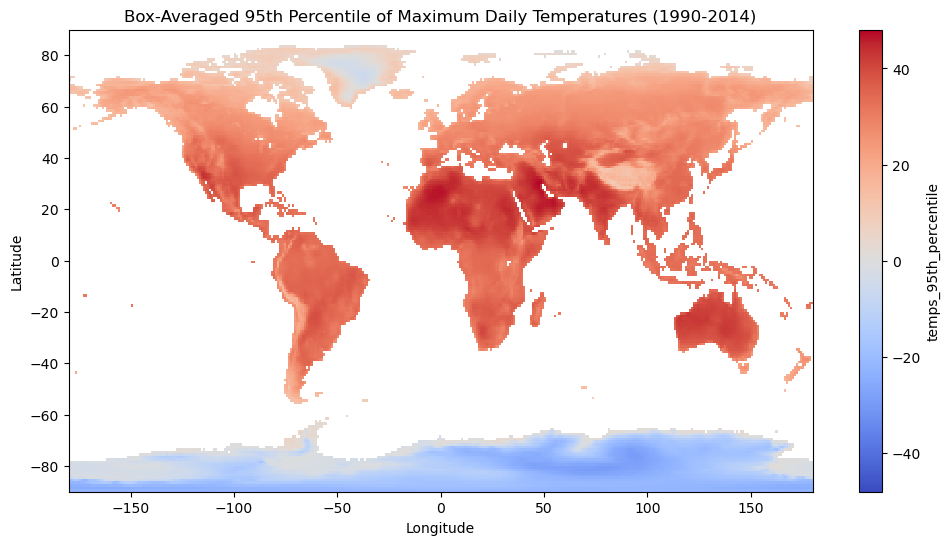

In [14]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Updated file paths
file_paths = [
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc",
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2000.nc",
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2010.nc"
]

# Check if files exist and are accessible
for file_path in file_paths:
    try:
        with open(file_path, 'r') as f:
            pass
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found: {file_path}. Please check the file path.")

# Initialize storage for diagnostics and processing
total_days = sum(xr.open_dataset(fp).dims["time"] for fp in file_paths)
temps = np.full((total_days, 180, 360), np.nan, dtype=np.float32)
current_index = 0

# Process each file
for file_path in file_paths:
    print(f"Processing file: {file_path}")
    
    ds = xr.open_dataset(file_path)
    
    # Ensure time coordinate exists
    if "time" not in ds.coords:
        print("Fixing 'time' coordinate...")
        time_values = pd.to_datetime(
            {
                "year": ds["year"].values,
                "month": ds["month"].values,
                "day": ds["day"].values,
            }
        )
        ds = ds.assign_coords(time=("time", time_values))
    
    # Assign day_number coordinate
    if "day_number" not in ds["climatology"].coords:
        print("Assigning 'day_number' as a coordinate...")
        ds["climatology"] = ds["climatology"].assign_coords(
            day_number=("day_number", np.arange(1, 366))
        )
    
    # Add climatology to temperature
    climatology = ds["climatology"]
    day_of_year = ds["time"].dt.dayofyear.where(ds["time"].dt.dayofyear <= 365, 365)
    climatology_expanded = climatology.sel(day_number=day_of_year, method="nearest")
    temperature_absolute = ds["temperature"] + climatology_expanded
    
    # Diagnostics for missing data
    print(f"NaNs in Climatology Expanded: {np.isnan(climatology_expanded).sum()}")
    print(f"NaNs in Temperature Absolute: {np.isnan(temperature_absolute).sum()}")
    
    # Store data in the temps array
    num_days = temperature_absolute.shape[0]
    temps[current_index:current_index + num_days] = temperature_absolute.values
    current_index += num_days
    
    ds.close()

# Calculate the 95th percentile
print("Calculating the 95th percentile...")
temps_95 = np.nanpercentile(temps, 95, axis=0)

# Save the 95th percentile as a dataset
output_file = "/home/a4wilson/historical/temps_95th_percentile.nc"
print(f"Saving the 95th percentile data to {output_file}...")
ds_output = xr.Dataset(
    {
        "temps_95th_percentile": (("latitude", "longitude"), temps_95)
    },
    coords={
        "latitude": np.linspace(-89.5, 89.5, 180),
        "longitude": np.linspace(-179.5, 179.5, 360),
    },
)
ds_output.to_netcdf(output_file, mode="w")
print(f"95th percentile data successfully saved to {output_file}.")

# Diagnostic Plot: Missing Data
missing_data_map = np.isnan(temps).sum(axis=0)

plt.figure(figsize=(12, 6))
plt.title("Spatial Distribution of Missing Data")
plt.pcolormesh(
    np.linspace(-179.5, 179.5, 360),
    np.linspace(-89.5, 89.5, 180),
    missing_data_map,
    cmap="viridis"
)
plt.colorbar(label="Number of Missing Days")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("/home/a4wilson/historical/missing_data_distribution.png")
plt.show()

# Apply box averaging to smooth missing data
def box_average(data, box_size=1):
    return data.rolling(
        latitude=box_size, longitude=box_size, center=True, min_periods=1
    ).mean()

# Load the saved dataset and smooth it
temps_95_box_avg = box_average(ds_output["temps_95th_percentile"], box_size=1)

# Save the smoothed data
smoothed_file = "/home/a4wilson/historical/temps_95th_percentile_box_avg.nc"
temps_95_box_avg.to_netcdf(smoothed_file, mode="w")
print(f"Box-averaged data saved to {smoothed_file}.")

# Plot the smoothed data
plt.figure(figsize=(12, 6))
temps_95_box_avg.plot(cmap="coolwarm")
plt.title("Box-Averaged 95th Percentile of Maximum Daily Temperatures (1990-2014)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("/home/a4wilson/historical/temps_95th_percentile_box_avg_plot.png")
plt.show()


/tmp/ipykernel_2510294/2480567084.py:17: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  total_days = sum(xr.open_dataset(fp).dims["time"] for fp in file_paths)


Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc
Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2000.nc
Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2010.nc
Calculating percentiles...


/home/a4wilson/anaconda3/envs/climate_nick/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Saved 95th percentile data to /home/a4wilson/historical/temps_95th_percentile.nc
Saved 98th percentile data to /home/a4wilson/historical/temps_98th_percentile.nc
Saved 99th percentile data to /home/a4wilson/historical/temps_99th_percentile.nc
Saved plot to /home/a4wilson/historical/temps_95th_percentile_midlatitudes.png


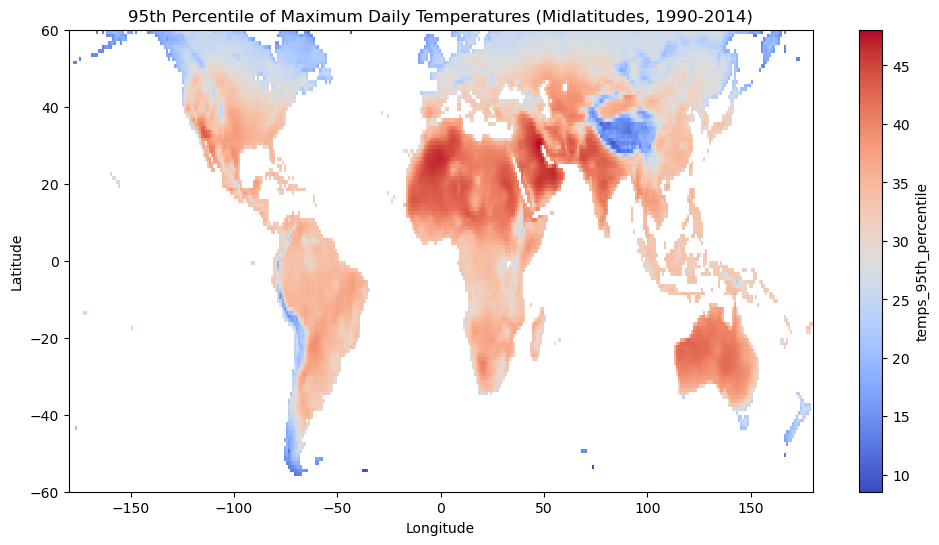

Saved plot to /home/a4wilson/historical/temps_98th_percentile_midlatitudes.png


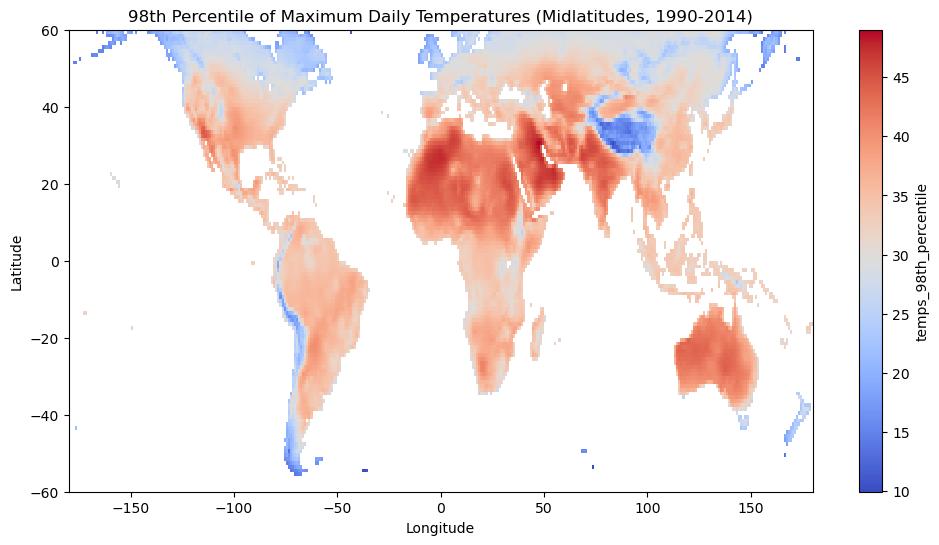

Saved plot to /home/a4wilson/historical/temps_99th_percentile_midlatitudes.png


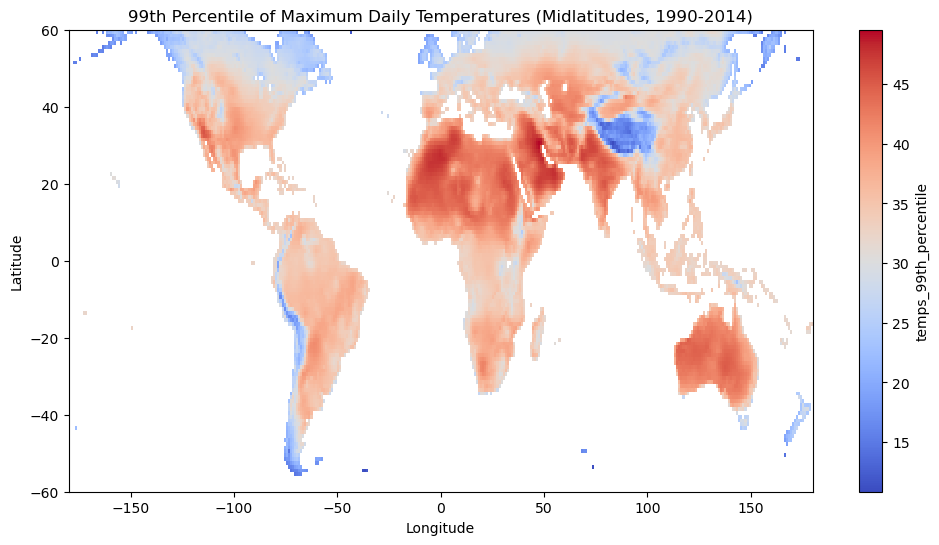

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Define file paths for input and output
file_paths = [
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc",
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2000.nc",
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2010.nc",
]

output_dir = "/home/a4wilson/historical/"

# Initialize empty array to store processed temperature data
total_days = sum(xr.open_dataset(fp).dims["time"] for fp in file_paths)
temps = np.zeros((total_days, 180, 360), dtype=np.float32)

# Temporary index pointer
current_index = 0

# Process files sequentially, adding climatology to absolute temperature
for i, file_path in enumerate(file_paths):
    print(f"Processing file: {file_path}")
    ds = xr.open_dataset(file_path)
    
    # Fix 'time' coordinate if missing
    if "time" not in ds.coords:
        time_values = pd.to_datetime(
            {
                "year": ds["year"].values,
                "month": ds["month"].values,
                "day": ds["day"].values,
            }
        )
        ds = ds.assign_coords(time=("time", time_values))

    # Ensure 'day_number' is a coordinate for climatology
    if "day_number" not in ds["climatology"].coords:
        ds["climatology"] = ds["climatology"].assign_coords(
            day_number=("day_number", np.arange(1, 366))
        )
    
    # Add climatology to temperature
    day_of_year = ds["time"].dt.dayofyear.where(ds["time"].dt.dayofyear <= 365, 365)
    climatology_expanded = ds["climatology"].sel(day_number=day_of_year, method="nearest")
    temperature_absolute = ds["temperature"] + climatology_expanded

    # Store data in temps array
    num_days = temperature_absolute.shape[0]
    temps[current_index:current_index + num_days] = temperature_absolute.values
    current_index += num_days

    # Close dataset to save memory
    ds.close()

# Calculate percentiles
print("Calculating percentiles...")
percentiles = {
    "95th": np.nanpercentile(temps, 95, axis=0),
    "98th": np.nanpercentile(temps, 98, axis=0),
    "99th": np.nanpercentile(temps, 99, axis=0),
}

# Save each percentile to a NetCDF file
def save_to_netcdf(data, name):
    file_path = os.path.join(output_dir, f"temps_{name}_percentile.nc")
    ds = xr.Dataset(
        {
            f"temps_{name}_percentile": (("latitude", "longitude"), data)
        },
        coords={
            "latitude": np.linspace(-89.5, 89.5, 180),
            "longitude": np.linspace(-179.5, 179.5, 360),
        },
    )
    ds.to_netcdf(file_path, mode="w")
    print(f"Saved {name} percentile data to {file_path}")
    return file_path

files = {}
for name, data in percentiles.items():
    files[name] = save_to_netcdf(data, name)

# Plot each percentile for midlatitudes (-60 to 60 degrees latitude)
def plot_percentile(data, title, lat_min=-60, lat_max=60, save_path=None):
    plt.figure(figsize=(12, 6))
    data_subset = data.sel(latitude=slice(lat_min, lat_max))
    data_subset.plot(cmap="coolwarm")
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    if save_path:
        plt.savefig(save_path)
        print(f"Saved plot to {save_path}")
    plt.show()

# Generate and save plots
for name, file in files.items():
    ds = xr.open_dataset(file)
    data = ds[f"temps_{name}_percentile"]
    plot_file = os.path.join(output_dir, f"temps_{name}_percentile_midlatitudes.png")
    plot_title = f"{name.capitalize()} Percentile of Maximum Daily Temperatures (Midlatitudes, 1990-2014)"
    plot_percentile(data, plot_title, lat_min=-60, lat_max=60, save_path=plot_file)


In [30]:
import os
import xarray as xr
import numpy as np

# Paths and files
percentile_files = {
    "95th": "/home/a4wilson/historical_output/temps_95th_percentile.nc",
    "98th": "/home/a4wilson/historical_output/temps_98th_percentile.nc",
    "99th": "/home/a4wilson/historical_output/temps_99th_percentile.nc",
}
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"
regridded_output_dir = "/home/a4wilson/historical_output/regridded/"

# Ensure the regridded directory exists
os.makedirs(regridded_output_dir, exist_ok=True)

# Load model data to use its coordinates for regridding
model_ds = xr.open_dataset(model_file)
model_coords = {"lat": "lat", "lon": "lon"}

# Regrid and save
for name, file in percentile_files.items():
    print(f"Processing {name} percentile...")
    berkeley_ds = xr.open_dataset(file)
    berkeley_data = berkeley_ds[f"temps_{name}_percentile"]
    
    # Transform longitudes if necessary
    if berkeley_data["longitude"].max() > 180:
        berkeley_data = berkeley_data.assign_coords(
            longitude=(((berkeley_data["longitude"] + 180) % 360) - 180)
        ).sortby("longitude")
    
    # Regrid Berkeley data to match the model grid
    regridded_berkeley = berkeley_data.interp(
        latitude=model_ds[model_coords["lat"]],
        longitude=model_ds[model_coords["lon"]],
        method="linear"
    )
    
    # Save the regridded data
    regridded_file_path = os.path.join(regridded_output_dir, f"temps_{name}_percentile_regridded.nc")
    regridded_berkeley.to_netcdf(regridded_file_path)
    print(f"Saved regridded {name} data to {regridded_file_path}")


Processing 95th percentile...
Saved regridded 95th data to /home/a4wilson/historical_output/regridded/temps_95th_percentile_regridded.nc
Processing 98th percentile...
Saved regridded 98th data to /home/a4wilson/historical_output/regridded/temps_98th_percentile_regridded.nc
Processing 99th percentile...
Saved regridded 99th data to /home/a4wilson/historical_output/regridded/temps_99th_percentile_regridded.nc


/tmp/ipykernel_3493219/1056427249.py:18: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  total_days = sum(xr.open_dataset(fp).dims["time"] for fp in file_paths)


Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc
Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2000.nc
Processing file: /home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2010.nc
Calculating percentiles...


/home/a4wilson/anaconda3/envs/climate_nick/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Saved 95th percentile data to /home/a4wilson/historical_output/tmax_95th_percentile.nc
Saved 98th percentile data to /home/a4wilson/historical_output/tmax_98th_percentile.nc
Saved 99th percentile data to /home/a4wilson/historical_output/tmax_99th_percentile.nc
Saved plot to /home/a4wilson/historical_output/tmax_95th_percentile_midlatitudes.png


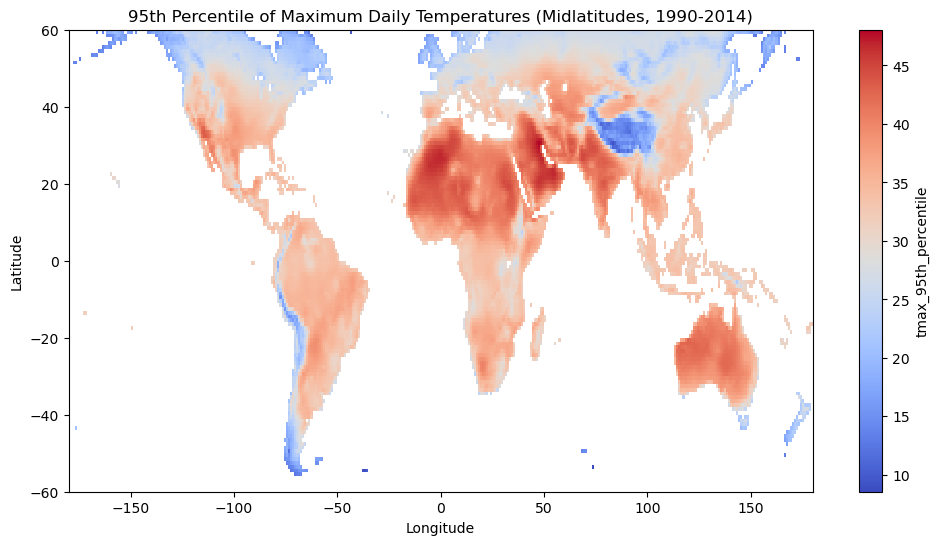

Saved plot to /home/a4wilson/historical_output/tmax_98th_percentile_midlatitudes.png


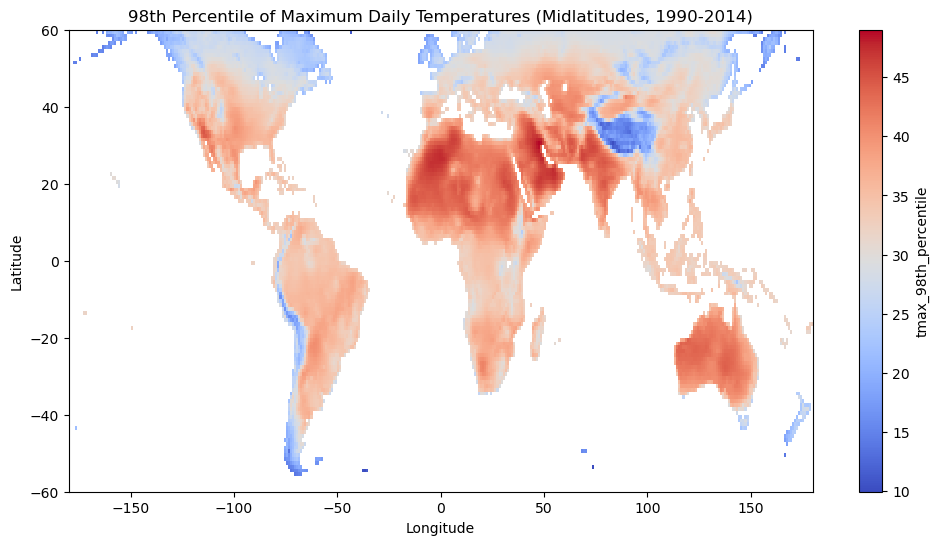

Saved plot to /home/a4wilson/historical_output/tmax_99th_percentile_midlatitudes.png


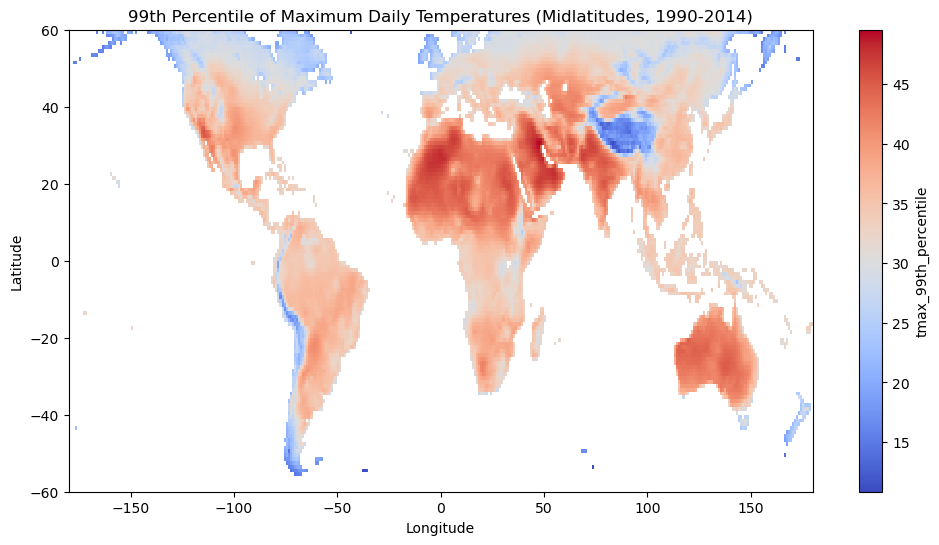

In [47]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Define file paths for input and output
file_paths = [
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_1990.nc",
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2000.nc",
    "/home/a4wilson/historical/Complete_TMAX_Daily_LatLong1_2010.nc",
]

output_dir = "/home/a4wilson/historical_output/"
os.makedirs(output_dir, exist_ok=True)

# Initialize empty array to store processed temperature data
total_days = sum(xr.open_dataset(fp).dims["time"] for fp in file_paths)
temps = np.zeros((total_days, 180, 360), dtype=np.float32)

# Temporary index pointer
current_index = 0

# Process files sequentially, adding climatology to absolute temperature
for file_path in file_paths:
    print(f"Processing file: {file_path}")
    ds = xr.open_dataset(file_path)
    
    # Fix 'time' coordinate if missing
    if "time" not in ds.coords:
        time_values = pd.to_datetime(
            {
                "year": ds["year"].values,
                "month": ds["month"].values,
                "day": ds["day"].values,
            }
        )
        ds = ds.assign_coords(time=("time", time_values))

    # Ensure 'day_number' is a coordinate for climatology
    if "day_number" not in ds["climatology"].coords:
        ds["climatology"] = ds["climatology"].assign_coords(
            day_number=("day_number", np.arange(1, 366))
        )
    
    # Add climatology to temperature
    day_of_year = ds["time"].dt.dayofyear.where(ds["time"].dt.dayofyear <= 365, 365)
    climatology_expanded = ds["climatology"].sel(day_number=day_of_year, method="nearest")
    temperature_absolute = ds["temperature"] + climatology_expanded

    # Store data in temps array
    num_days = temperature_absolute.shape[0]
    temps[current_index:current_index + num_days] = temperature_absolute.values
    current_index += num_days

    # Close dataset to save memory
    ds.close()

# Calculate percentiles
print("Calculating percentiles...")
percentiles = {
    "95th": np.nanpercentile(temps, 90, axis=0),
    "98th": np.nanpercentile(temps, 98, axis=0),
    "99th": np.nanpercentile(temps, 99, axis=0),
}

# Save each percentile to a NetCDF file
def save_to_netcdf(data, name):
    file_path = os.path.join(output_dir, f"tmax_{name}_percentile.nc")
    ds = xr.Dataset(
        {
            f"tmax_{name}_percentile": (("latitude", "longitude"), data)
        },
        coords={
            "latitude": np.linspace(-89.5, 89.5, 180),
            "longitude": np.linspace(-179.5, 179.5, 360),
        },
    )
    ds.to_netcdf(file_path, mode="w")
    print(f"Saved {name} percentile data to {file_path}")
    return file_path

files = {}
for name, data in percentiles.items():
    files[name] = save_to_netcdf(data, name)

# Plot each percentile for midlatitudes (-60 to 60 degrees latitude)
def plot_percentile(data, title, lat_min=-60, lat_max=60, save_path=None):
    plt.figure(figsize=(12, 6))
    data_subset = data.sel(latitude=slice(lat_min, lat_max))
    data_subset.plot(cmap="coolwarm")
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    if save_path:
        plt.savefig(save_path)
        print(f"Saved plot to {save_path}")
    plt.show()

# Generate and save plots
for name, file in files.items():
    ds = xr.open_dataset(file)
    data = ds[f"tmax_{name}_percentile"]
    plot_file = os.path.join(output_dir, f"tmax_{name}_percentile_midlatitudes.png")
    plot_title = f"{name.capitalize()} Percentile of Maximum Daily Temperatures (Midlatitudes, 1990-2014)"
    plot_percentile(data, plot_title, lat_min=-60, lat_max=60, save_path=plot_file)


In [ ]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# File paths
percentile_files = {
    "percentile_95": "/home/a4wilson/historical_output/tmax_95th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
}
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def preprocess_model(filepath):
    """
    Preprocess model data to ensure longitudes are in the correct range,
    filter by time range (1990-2014), and convert from Kelvin to Celsius if needed.
    """
    print("Preprocessing model data...")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    # Filter for the time range 1990–2014
    model_ds = model_ds.sel(year=slice(1990, 2014))

    # Debugging: Check units and initial range
    tasmax_units = model_ds["tasmax"].attrs.get("units", "Not specified")
    tasmax_min = model_ds["tasmax"].min().values
    tasmax_max = model_ds["tasmax"].max().values
    print(f"Model Data Units (tasmax): {tasmax_units}")
    print(f"Model Data Range (tasmax): min={tasmax_min}, max={tasmax_max}")

    # Convert model data to Celsius if in Kelvin
    if tasmax_units.lower() in ["k", "kelvin"] and tasmax_max > 273.15:
        print("Converting model data from Kelvin to Celsius...")
        model_ds["tasmax"] -= 273.15
        model_ds["tasmax"].attrs["units"] = "degree_Celsius"
    elif tasmax_units.lower() in ["k", "kelvin"]:
        print("WARNING: Units are marked as Kelvin, but data range suggests Celsius. Fixing metadata only...")
        model_ds["tasmax"].attrs["units"] = "degree_Celsius"

    # Debugging: Check final range after conversion
    tasmax_min = model_ds["tasmax"].min().values
    tasmax_max = model_ds["tasmax"].max().values
    print(f"Model Data Range After Conversion (tasmax): min={tasmax_min}, max={tasmax_max}")

    return model_ds

def plot_map(data, title, vmin=None, vmax=None, save_path=None):
    """
    Function to plot and optionally save maps.
    """
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -60, 60], crs=ccrs.PlateCarree())  # Midlatitudes
    im = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.7},
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=14)
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot: {save_path}")
    plt.close()

def debug_units_and_ranges(berkeley_data, model_data, key):
    """
    Debugging function to print data units and ranges.
    """
    print(f"\n--- Debugging {key} ---")
    print(f"Berkeley Data Units: {berkeley_data.attrs.get('units', 'Not specified')}")
    print(f"Berkeley Data Range: min={berkeley_data.min().values}, max={berkeley_data.max().values}")
    print(f"Model Data Units: {model_data.attrs.get('units', 'Not specified')}")
    print(f"Model Data Range: min={model_data.min().values}, max={model_data.max().values}")

def plot_berkeley_and_model_with_saving(percentile_files, model_ds, output_dir="output_maps"):
    """
    Processes Berkeley and model data, calculates differences, and saves the plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    for key, filepath in percentile_files.items():
        print(f"Processing {key} from file: {filepath}...")

        # Load Berkeley data
        berkeley_ds = xr.open_dataset(filepath)
        variable_name = f"tmax_{key.split('_')[-1]}th_percentile"
        berkeley_data = berkeley_ds[variable_name]

        # Rename coordinates if necessary
        if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
            print("Renaming coordinates: latitude -> 'lat', longitude -> 'lon'")
            berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})

        # Subset to global midlatitudes
        berkeley_data = berkeley_data.sel(lat=slice(-60, 60))

        # Regrid Berkeley data to match model grid
        berkeley_data = berkeley_data.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="linear")

        # Select the variable from the model dataset and subset to midlatitudes
        if "tasmax" in model_ds.data_vars:
            model_data = model_ds["tasmax"].mean(dim="year").sel(lat=slice(-60, 60))
        else:
            raise ValueError("Model dataset does not contain the expected variable 'tasmax'.")

        # Debugging: Check units and ranges
        debug_units_and_ranges(berkeley_data, model_data, key)

        # Calculate difference
        difference = model_data - berkeley_data

        # File paths for saving
        berkeley_plot_path = os.path.join(output_dir, f"{key}_berkeley.png")
        model_plot_path = os.path.join(output_dir, f"{key}_model.png")
        difference_plot_path = os.path.join(output_dir, f"{key}_difference.png")

        # Plot maps
        plot_map(
            berkeley_data,
            f"Berkeley Data (Midlatitudes) - {key}",
            vmin=-20,
            vmax=60,
            save_path=berkeley_plot_path,
        )
        plot_map(
            model_data,
            f"Model Data (Midlatitudes) - {key}",
            vmin=-20,
            vmax=60,
            save_path=model_plot_path,
        )
        plot_map(
            difference,
            f"Difference (Model - Berkeley) (Midlatitudes) - {key}",
            vmin=-10,
            vmax=10,
            save_path=difference_plot_path,
        )

# Main Execution
if __name__ == "__main__":
    # Preprocess model data
    model_ds = preprocess_model(model_file)

    # Plot Berkeley and model data
    plot_berkeley_and_model_with_saving(percentile_files, model_ds, output_dir="output_maps")


Preprocessing model data...
Converting model longitudes from 0–360 to -180–180...
Model Data Units (tasmax): K
Model Data Range (tasmax): min=-21.349945068359375, max=54.994293212890625
Model Data Range After Conversion (tasmax): min=-21.349945068359375, max=54.994293212890625
Processing percentile_95 from file: /home/a4wilson/historical_output/tmax_95th_percentile.nc...
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'

--- Debugging percentile_95 ---
Berkeley Data Units: Not specified
Berkeley Data Range: min=9.930723856389521, max=47.79911748170852
Model Data Units: Not specified
Model Data Range: min=4.108014106750488, max=50.65503692626953
Saved plot: output_maps/percentile_95_berkeley.png
Saved plot: output_maps/percentile_95_model.png
Saved plot: output_maps/percentile_95_difference.png
Processing percentile_98 from file: /home/a4wilson/historical_output/tmax_98th_percentile.nc...
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'

--- Debugging percentile_98 

In [25]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# File paths
percentile_files = {
    "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
}
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def preprocess_model(filepath):
    """
    Preprocess model data to ensure longitudes are in the correct range,
    filter by time range (1990-2014), and convert from Kelvin to Celsius if needed.
    """
    print("Preprocessing model data...")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    # Filter for the time range 1990–2014
    model_ds = model_ds.sel(year=slice(1990, 2014))

    # Debugging: Check units and initial range
    tasmax_units = model_ds["tasmax"].attrs.get("units", "Not specified")
    tasmax_min = model_ds["tasmax"].min().values
    tasmax_max = model_ds["tasmax"].max().values
    print(f"Model Data Units (tasmax): {tasmax_units}")
    print(f"Model Data Range (tasmax): min={tasmax_min}, max={tasmax_max}")

    # Convert model data to Celsius if in Kelvin
    if tasmax_units.lower() in ["k", "kelvin"] and tasmax_max > 273.15:
        print("Converting model data from Kelvin to Celsius...")
        model_ds["tasmax"] -= 273.15
        model_ds["tasmax"].attrs["units"] = "degree_Celsius"

    # Debugging: Check final range after conversion
    tasmax_min = model_ds["tasmax"].min().values
    tasmax_max = model_ds["tasmax"].max().values
    print(f"Model Data Range After Conversion (tasmax): min={tasmax_min}, max={tasmax_max}")

    return model_ds

def plot_map(data, title, vmin=None, vmax=None, save_path=None):
    """
    Function to plot and optionally save maps.
    """
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -60, 60], crs=ccrs.PlateCarree())  # Midlatitudes
    im = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.7},
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=14)
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot: {save_path}")
    plt.close()

def debug_units_and_ranges(berkeley_data, model_data, key):
    """
    Debugging function to print data units and ranges.
    """
    print(f"\n--- Debugging {key} ---")
    print(f"Berkeley Data Units: {berkeley_data.attrs.get('units', 'Not specified')}")
    print(f"Berkeley Data Range: min={berkeley_data.min().values}, max={berkeley_data.max().values}")
    print(f"Model Data Units: {model_data.attrs.get('units', 'Not specified')}")
    print(f"Model Data Range: min={model_data.min().values}, max={model_data.max().values}")

def plot_berkeley_and_model_with_saving(percentile_files, model_ds, output_dir="output_maps"):
    """
    Processes Berkeley and model data, calculates differences, and saves the plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    for key, filepath in percentile_files.items():
        print(f"Processing {key} from file: {filepath}...")

        # Load Berkeley data
        berkeley_ds = xr.open_dataset(filepath)
        variable_name = f"tmax_{key.split('_')[-1]}th_percentile"  # Adjusting to match correct naming
        berkeley_data = berkeley_ds[variable_name]

        # Rename coordinates if necessary
        if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
            print("Renaming coordinates: latitude -> 'lat', longitude -> 'lon'")
            berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})

        # Subset to global midlatitudes
        berkeley_data = berkeley_data.sel(lat=slice(-60, 60))

        # Regrid Berkeley data to match model grid
        berkeley_data = berkeley_data.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="linear")

        # Select the variable from the model dataset and subset to midlatitudes
        if "tasmax" in model_ds.data_vars:
            model_data = model_ds["tasmax"].mean(dim="year").sel(lat=slice(-60, 60))
        else:
            raise ValueError("Model dataset does not contain the expected variable 'tasmax'.")

        # Debugging: Check units and ranges
        debug_units_and_ranges(berkeley_data, model_data, key)

        # Calculate difference
        difference = model_data - berkeley_data

        # File paths for saving
        berkeley_plot_path = os.path.join(output_dir, f"{key}_berkeley.png")
        model_plot_path = os.path.join(output_dir, f"{key}_model.png")
        difference_plot_path = os.path.join(output_dir, f"{key}_difference.png")

        # Plot maps
        plot_map(
            berkeley_data,
            f"Berkeley Data (Midlatitudes) - {key}",
            vmin=-20,
            vmax=60,
            save_path=berkeley_plot_path,
        )
        plot_map(
            model_data,
            f"Model Data (Midlatitudes) - {key}",
            vmin=-20,
            vmax=60,
            save_path=model_plot_path,
        )
        plot_map(
            difference,
            f"Difference (Model - Berkeley) (Midlatitudes) - {key}",
            vmin=-10,
            vmax=10,
            save_path=difference_plot_path,
        )

# Main Execution
if __name__ == "__main__":
    # Preprocess model data
    model_ds = preprocess_model(model_file)

    # Plot Berkeley and model data
    plot_berkeley_and_model_with_saving(percentile_files, model_ds, output_dir="output_maps")


Preprocessing model data...
Converting model longitudes from 0–360 to -180–180...
Model Data Units (tasmax): K
Model Data Range (tasmax): min=-21.349945068359375, max=54.994293212890625
Model Data Range After Conversion (tasmax): min=-21.349945068359375, max=54.994293212890625
Processing percentile_90 from file: /home/a4wilson/historical_output/tmax_90th_percentile.nc...
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'

--- Debugging percentile_90 ---
Berkeley Data Units: Not specified
Berkeley Data Range: min=9.054685828089713, max=46.780989331007
Model Data Units: Not specified
Model Data Range: min=4.108014106750488, max=50.65503692626953
Saved plot: output_maps/percentile_90_berkeley.png
Saved plot: output_maps/percentile_90_model.png
Saved plot: output_maps/percentile_90_difference.png
Processing percentile_98 from file: /home/a4wilson/historical_output/tmax_98th_percentile.nc...
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'

--- Debugging percentile_98 --

In [24]:
import os
import numpy as np
import pandas as pd
import xarray as xr

# File paths
percentile_files = {
    "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
}
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"


def preprocess_berkeley_data(filepath, key):
    """
    Preprocess Berkeley data: rename dimensions and ensure metadata consistency.
    """
    berkeley_ds = xr.open_dataset(filepath)
    variable_suffix = key.split('_')[-1]
    variable_name = f"tmax_{variable_suffix}th_percentile"
    berkeley_data = berkeley_ds[variable_name]

    # Rename coordinates if necessary
    if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
        print("Renaming coordinates: latitude -> 'lat', longitude -> 'lon'")
        berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})

    # Debugging: Check units and shape
    print(f"Berkeley Data Units: {berkeley_data.attrs.get('units', 'Not specified')}")
    print(f"Berkeley Data Shape Before Subsetting: {berkeley_data.shape}")

    # Subset to global midlatitudes
    berkeley_data = berkeley_data.sel(lat=slice(-60, 60))
    print(f"Berkeley Data Shape After Subsetting: {berkeley_data.shape}")

    return berkeley_data


def preprocess_model(filepath):
    """
    Preprocess model data to ensure longitudes are in the correct range,
    filter by time range (1990-2014), and convert from Kelvin to Celsius.
    """
    print("Preprocessing model data...")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    # Debugging: Check units and range
    tasmax_units = model_ds["tasmax"].attrs.get("units", "Not specified")
    print(f"Model Data Units (tasmax): {tasmax_units}")
    print(f"Model Data Range (tasmax): min={model_ds['tasmax'].min().values}, max={model_ds['tasmax'].max().values}")

    # Convert model data to Celsius if in Kelvin
    if tasmax_units.lower() in ["k", "kelvin"] and model_ds["tasmax"].max() > 273.15:
        print("Converting model data from Kelvin to Celsius...")
        model_ds["tasmax"] -= 273.15
        model_ds["tasmax"].attrs["units"] = "degree_Celsius"

    # Ensure midlatitude consistency
    model_ds = model_ds.sel(lat=slice(-60, 60))

    print(f"Model Data Lat/Lon Shape: {model_ds['lat'].shape}, {model_ds['lon'].shape}")

    return model_ds


def calculate_metrics(berkeley_data, model_data):
    """
    Calculate Bias, RMSE, and R² metrics between Berkeley and model data.
    """
    print(f"Berkeley Data Shape: {berkeley_data.shape}")
    print(f"Model Data Shape: {model_data.shape}")

    if berkeley_data.shape != model_data.shape:
        raise ValueError(
            f"Shape mismatch: Berkeley data {berkeley_data.shape} and model data {model_data.shape}"
        )

    berkeley_flat = berkeley_data.values.ravel()
    model_flat = model_data.values.ravel()

    mask = np.isfinite(berkeley_flat) & np.isfinite(model_flat)
    berkeley_flat = berkeley_flat[mask]
    model_flat = model_flat[mask]

    bias = np.mean(model_flat - berkeley_flat)
    rmse = np.sqrt(np.mean((model_flat - berkeley_flat) ** 2))
    r_squared = np.corrcoef(berkeley_flat, model_flat)[0, 1] ** 2

    return {"Bias": bias, "RMSE": rmse, "R²": r_squared}


def compute_and_save_metrics(percentile_files, model_ds, output_file="metrics_output.csv"):
    """
    Compute metrics (Bias, RMSE, R²) and save results to a CSV file.
    """
    results = []

    for key, filepath in percentile_files.items():
        print(f"Processing {key} from file: {filepath}...")

        # Preprocess Berkeley data
        berkeley_data = preprocess_berkeley_data(filepath, key)

        # Regrid Berkeley data to match model grid
        berkeley_data = berkeley_data.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="linear")
        print(f"Berkeley Data Shape After Regridding: {berkeley_data.shape}")

        # Select model data and average over years
        model_data = model_ds["tasmax"].mean(dim="year")
        print(f"Model Data Shape After Averaging: {model_data.shape}")

        # Calculate metrics
        metrics = calculate_metrics(berkeley_data, model_data)
        metrics["Percentile"] = key
        results.append(metrics)

    # Convert results to a DataFrame
    metrics_df = pd.DataFrame(results)
    print(metrics_df)

    # Save to CSV
    metrics_df.to_csv(output_file, index=False)
    print(f"Metrics saved to {output_file}")

    return metrics_df


if __name__ == "__main__":
    model_ds = preprocess_model(model_file)
    metrics_df = compute_and_save_metrics(percentile_files, model_ds)
    print(metrics_df)


Preprocessing model data...
Converting model longitudes from 0–360 to -180–180...
Model Data Units (tasmax): K
Model Data Range (tasmax): min=-22.972991943359375, max=54.994293212890625
Model Data Lat/Lon Shape: (96,), (192,)
Processing percentile_90 from file: /home/a4wilson/historical_output/tmax_90th_percentile.nc...
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'
Berkeley Data Units: Not specified
Berkeley Data Shape Before Subsetting: (180, 360)
Berkeley Data Shape After Subsetting: (120, 360)
Berkeley Data Shape After Regridding: (96, 192)
Model Data Shape After Averaging: (96, 192)
Berkeley Data Shape: (96, 192)
Model Data Shape: (96, 192)
Processing percentile_98 from file: /home/a4wilson/historical_output/tmax_98th_percentile.nc...
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'
Berkeley Data Units: Not specified
Berkeley Data Shape Before Subsetting: (180, 360)
Berkeley Data Shape After Subsetting: (120, 360)
Berkeley Data Shape After Regridding: (96, 

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def preprocess_model(filepath):
    """
    Preprocess model data to ensure longitudes are in the correct range
    and filter by time range (1990-2014). No unit conversion is applied.
    """
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    # Filter for the time range 1990–2014
    model_ds = model_ds.sel(year=slice(1990, 2014))

    print(f"Finished preprocessing: {filepath}")
    return model_ds

def plot_map(data, title, vmin=None, vmax=None, save_path=None):
    """
    Function to plot and optionally save maps.
    """
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -60, 60], crs=ccrs.PlateCarree())  # Midlatitudes
    im = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.7},
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=14)
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved plot: {save_path}")
    plt.close()


def plot_berkeley_and_model_with_saving(percentile_files, model_files, output_dir="output_maps"):
    """
    Processes Berkeley and model data, calculates differences for each model, and saves the plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    for key, filepath in percentile_files.items():
        print(f"Processing {key} from file: {filepath}...")

        # Load Berkeley data
        berkeley_ds = xr.open_dataset(filepath)
        variable_name = f"tmax_{key.split('_')[-1]}th_percentile"
        berkeley_data = berkeley_ds[variable_name]

        # Rename coordinates if necessary
        if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
            print("Renaming coordinates: latitude -> 'lat', longitude -> 'lon'")
            berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})

        # Subset to global midlatitudes
        berkeley_data = berkeley_data.sel(lat=slice(-60, 60))

        for model_file in model_files:
            model_name = os.path.basename(model_file).replace("_dailymax_temps_record.nc", "")
            print(f"Processing model: {model_name}")

            # Preprocess model data
            model_ds = preprocess_model(model_file)

            # Select the variable from the model dataset and subset to midlatitudes
            if "tasmax" in model_ds.data_vars:
                model_data = model_ds["tasmax"].mean(dim="year").sel(lat=slice(-60, 60))
            else:
                raise ValueError("Model dataset does not contain the expected variable 'tasmax'.")

            # Regrid Berkeley data to match the model grid
            regridded_berkeley = berkeley_data.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="linear")

            # Calculate the difference
            difference = model_data - regridded_berkeley

            # Debugging: Check ranges
            print(f"Model Data ({model_name}) Range: min={model_data.min().values}, max={model_data.max().values}")
            print(f"Regridded Berkeley Data ({key}) Range: min={regridded_berkeley.min().values}, max={regridded_berkeley.max().values}")
            print(f"Difference ({model_name}, {key}) Range: min={difference.min().values}, max={difference.max().values}")

            # File paths for saving
            berkeley_plot_path = os.path.join(output_dir, f"{key}_{model_name}_berkeley.png")
            model_plot_path = os.path.join(output_dir, f"{key}_{model_name}_model.png")
            difference_plot_path = os.path.join(output_dir, f"{key}_{model_name}_difference.png")

            # Plot and save maps
            plot_map(
                regridded_berkeley,
                f"Berkeley Data (Midlatitudes) - {key} - {model_name}",
                vmin=-20,
                vmax=60,
                save_path=berkeley_plot_path,
            )
            plot_map(
                model_data,
                f"Model Data (Midlatitudes) - {key} - {model_name}",
                vmin=-20,
                vmax=60,
                save_path=model_plot_path,
            )
            plot_map(
                difference,
                f"Difference (Model - Berkeley) (Midlatitudes) - {key} - {model_name}",
                vmin=-10,
                vmax=10,
                save_path=difference_plot_path,
            )


if __name__ == "__main__":
    # Input data paths
    percentile_files = {
        "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
        "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
        "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
    }
    model_directory = "/home/a4wilson/historical_total/"
    model_files = [
        os.path.join(model_directory, f)
        for f in os.listdir(model_directory)
        if f.endswith("_dailymax_temps_record.nc")
    ]
    output_dir = "output_maps"

    # Process Berkeley and model data, and calculate differences
    plot_berkeley_and_model_with_saving(percentile_files, model_files, output_dir)


Processing percentile_90 from file: /home/a4wilson/historical_output/tmax_90th_percentile.nc...
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'
Processing model: CNRM-CM6-1-HR
Preprocessing model data: /home/a4wilson/historical_total/CNRM-CM6-1-HR_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/CNRM-CM6-1-HR_dailymax_temps_record.nc
Model Data (CNRM-CM6-1-HR) Range: min=nan, max=nan
Regridded Berkeley Data (percentile_90) Range: min=8.885893220128292, max=46.89549560168697
Difference (CNRM-CM6-1-HR, percentile_90) Range: min=nan, max=nan
Saved plot: output_maps/percentile_90_CNRM-CM6-1-HR_berkeley.png
Saved plot: output_maps/percentile_90_CNRM-CM6-1-HR_model.png
Saved plot: output_maps/percentile_90_CNRM-CM6-1-HR_difference.png
Processing model: ACCESS-ESM1-5
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Converting model longitudes from 0

In [42]:
import matplotlib.pyplot as plt

def create_combined_difference_plots(percentile_files, model_files, output_dir="output_maps"):
    """
    Creates combined difference plots for all models and percentiles.
    """
    os.makedirs(output_dir, exist_ok=True)

    for key, filepath in percentile_files.items():
        print(f"Processing combined difference plot for: {key}...")

        # Load Berkeley data
        berkeley_ds = xr.open_dataset(filepath)
        variable_name = f"tmax_{key.split('_')[-1]}th_percentile"
        berkeley_data = berkeley_ds[variable_name]

        # Rename coordinates if necessary
        if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
            print("Renaming coordinates: latitude -> 'lat', longitude -> 'lon'")
            berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})

        # Subset to global midlatitudes
        berkeley_data = berkeley_data.sel(lat=slice(-60, 60))

        # Prepare the figure
        num_models = len(model_files)
        ncols = 3  # Number of columns for subplots
        nrows = (num_models + ncols - 1) // ncols  # Number of rows based on number of models
        fig, axs = plt.subplots(
            nrows=nrows, ncols=ncols, figsize=(15, nrows * 5), subplot_kw={"projection": ccrs.PlateCarree()}
        )
        axs = axs.flatten()

        for i, model_file in enumerate(model_files):
            model_name = os.path.basename(model_file).replace("_dailymax_temps_record.nc", "")
            print(f"Processing model for combined plot: {model_name}")

            # Preprocess model data
            model_ds = preprocess_model(model_file)

            # Select the variable from the model dataset and subset to midlatitudes
            if "tasmax" in model_ds.data_vars:
                model_data = model_ds["tasmax"].mean(dim="year").sel(lat=slice(-60, 60))
            else:
                raise ValueError("Model dataset does not contain the expected variable 'tasmax'.")

            # Regrid Berkeley data to match the model grid
            regridded_berkeley = berkeley_data.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="linear")

            # Calculate the difference
            difference = model_data - regridded_berkeley

            # Plot the difference
            ax = axs[i]
            im = difference.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=-10,
                vmax=10,
                add_colorbar=False,
            )
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.set_title(model_name, fontsize=12)

        # Hide any unused subplots
        for j in range(i + 1, len(axs)):
            axs[j].axis("off")

        # Add a single colorbar
        cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])  # [left, bottom, width, height]
        fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Temperature Difference (°C)")

        # Save the combined plot
        combined_plot_path = os.path.join(output_dir, f"combined_{key}_difference.png")
        plt.savefig(combined_plot_path, dpi=300, bbox_inches="tight")
        print(f"Saved combined difference plot: {combined_plot_path}")
        plt.close()


# Main Execution
if __name__ == "__main__":
    # Input data paths
    percentile_files = {
        "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
        "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
        "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
    }
    model_directory = "/home/a4wilson/historical_total/"
    model_files = [
        os.path.join(model_directory, f)
        for f in os.listdir(model_directory)
        if f.endswith("_dailymax_temps_record.nc")
    ]
    output_dir = "output_maps"

    # Create combined difference plots for all models and percentiles
    create_combined_difference_plots(percentile_files, model_files, output_dir)


Processing combined difference plot for: percentile_90...
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'
Processing model for combined plot: CNRM-CM6-1-HR
Preprocessing model data: /home/a4wilson/historical_total/CNRM-CM6-1-HR_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/CNRM-CM6-1-HR_dailymax_temps_record.nc
Processing model for combined plot: ACCESS-ESM1-5
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Processing model for combined plot: CanESM5
Preprocessing model data: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Processing m

In [43]:
def create_difference_plot_for_percentile(berkeley_data, model_files, key, output_dir):
    """
    Creates a single plot for the given percentile with subplots showing differences for all models.
    """
    print(f"Creating difference plot for {key}...")

    # Prepare output path
    os.makedirs(output_dir, exist_ok=True)
    plot_path = os.path.join(output_dir, f"{key}_difference_across_models.png")

    # Prepare the figure
    num_models = len(model_files)
    ncols = 3  # Number of columns for subplots
    nrows = (num_models + ncols - 1) // ncols  # Calculate rows dynamically
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(15, nrows * 5), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    axs = axs.flatten()

    for i, model_file in enumerate(model_files):
        model_name = os.path.basename(model_file).replace("_dailymax_temps_record.nc", "")
        print(f"Processing model: {model_name}")

        # Preprocess model data
        model_ds = preprocess_model(model_file)

        # Select the variable from the model dataset and subset to midlatitudes
        if "tasmax" in model_ds.data_vars:
            model_data = model_ds["tasmax"].mean(dim="year").sel(lat=slice(-60, 60))
        else:
            raise ValueError(f"Model dataset {model_name} does not contain 'tasmax'.")

        # Regrid Berkeley data to match the model grid
        regridded_berkeley = berkeley_data.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="linear")

        # Calculate the difference
        difference = model_data - regridded_berkeley

        # Plot the difference
        ax = axs[i]
        im = difference.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="coolwarm",
            vmin=-10,
            vmax=10,
            add_colorbar=False,
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_title(model_name, fontsize=12)

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    # Add a single colorbar
    cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Temperature Difference (°C)")

    # Save the plot
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    print(f"Saved difference plot for {key}: {plot_path}")
    plt.close()


def create_all_difference_plots(percentile_files, model_files, output_dir="output_maps"):
    """
    Generates and saves separate difference plots for each percentile.
    """
    for key, filepath in percentile_files.items():
        print(f"Processing percentile: {key}")

        # Load Berkeley data
        berkeley_ds = xr.open_dataset(filepath)
        variable_name = f"tmax_{key.split('_')[-1]}th_percentile"
        berkeley_data = berkeley_ds[variable_name]

        # Rename coordinates if necessary
        if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
            print("Renaming coordinates: latitude -> 'lat', longitude -> 'lon'")
            berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})

        # Subset to global midlatitudes
        berkeley_data = berkeley_data.sel(lat=slice(-60, 60))

        # Create a difference plot for this percentile
        create_difference_plot_for_percentile(berkeley_data, model_files, key, output_dir)


# Main Execution
if __name__ == "__main__":
    # Input data paths
    percentile_files = {
        "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
        "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
        "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
    }
    model_directory = "/home/a4wilson/historical_total/"
    model_files = [
        os.path.join(model_directory, f)
        for f in os.listdir(model_directory)
        if f.endswith("_dailymax_temps_record.nc")
    ]
    output_dir = "output_maps"

    # Create separate difference plots for each percentile
    create_all_difference_plots(percentile_files, model_files, output_dir)


Processing percentile: percentile_90
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'
Creating difference plot for percentile_90...
Processing model: CNRM-CM6-1-HR
Preprocessing model data: /home/a4wilson/historical_total/CNRM-CM6-1-HR_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/CNRM-CM6-1-HR_dailymax_temps_record.nc
Processing model: ACCESS-ESM1-5
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Processing model: CanESM5
Preprocessing model data: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Processing model: CMCC-CM2-SR5
Preprocess

In [2]:
def create_difference_plot_for_percentile(berkeley_data, model_files, key, output_dir):
    """
    Creates a single plot for the given percentile with subplots showing differences for all models.
    """
    print(f"Creating difference plot for {key}...")

    # Prepare output path
    os.makedirs(output_dir, exist_ok=True)
    plot_path = os.path.join(output_dir, f"{key}_difference_across_models.png")

    # Prepare the figure
    num_models = len(model_files)
    ncols = 3  # Number of columns for subplots
    nrows = (num_models + ncols - 1) // ncols  # Calculate rows dynamically
    fig, axs = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(15, nrows * 5), subplot_kw={"projection": ccrs.PlateCarree()}
    )
    axs = axs.flatten()

    for i, model_file in enumerate(model_files):
        model_name = os.path.basename(model_file).replace("_dailymax_temps_record.nc", "")
        print(f"Processing model: {model_name}")

        try:
            # Preprocess model data
            model_ds = preprocess_model(model_file)

            # Select the variable from the model dataset and subset to midlatitudes
            if "tasmax" in model_ds.data_vars:
                model_data = model_ds["tasmax"].mean(dim="year").sel(lat=slice(-60, 60))
            else:
                raise ValueError(f"Model dataset {model_name} does not contain 'tasmax'.")

            # Regrid Berkeley data to match the model grid
            regridded_berkeley = berkeley_data.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="linear")

            # Calculate the difference
            difference = model_data - regridded_berkeley

            # Plot the difference
            ax = axs[i]
            im = difference.plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=-10,
                vmax=10,
                add_colorbar=False,
            )
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)
            ax.set_title(model_name, fontsize=12)

        except Exception as e:
            # Log the error for the problematic model
            print(f"Error processing model {model_name}: {e}")
            ax = axs[i]
            ax.axis("off")
            ax.set_title(f"Error: {model_name}", fontsize=12)

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    # Add a single colorbar
    cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Temperature Difference (°C)")

    # Save the plot
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    print(f"Saved difference plot for {key}: {plot_path}")
    plt.close()


# Main Execution
if __name__ == "__main__":
    # Input data paths
    percentile_files = {
        "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
        "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
        "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
    }
    model_directory = "/home/a4wilson/historical_total/"
    model_files = [
        os.path.join(model_directory, f)
        for f in os.listdir(model_directory)
        if f.endswith("_dailymax_temps_record.nc")
    ]
    output_dir = "output_maps"

    for key, filepath in percentile_files.items():
        print(f"Processing percentile: {key}")

        # Load Berkeley data
        berkeley_ds = xr.open_dataset(filepath)
        variable_name = f"tmax_{key.split('_')[-1]}th_percentile"
        berkeley_data = berkeley_ds[variable_name]

        # Rename coordinates if necessary
        if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
            print("Renaming coordinates: latitude -> 'lat', longitude -> 'lon'")
            berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})

        # Subset to global midlatitudes
        berkeley_data = berkeley_data.sel(lat=slice(-60, 60))

        # Create a difference plot for this percentile
        create_difference_plot_for_percentile(berkeley_data, model_files, key, output_dir)


Processing percentile: percentile_90
Renaming coordinates: latitude -> 'lat', longitude -> 'lon'
Creating difference plot for percentile_90...
Processing model: CNRM-CM6-1-HR
Preprocessing model data: /home/a4wilson/historical_total/CNRM-CM6-1-HR_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/CNRM-CM6-1-HR_dailymax_temps_record.nc
Processing model: ACCESS-ESM1-5
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Processing model: CanESM5
Preprocessing model data: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Processing model: CMCC-CM2-SR5
Preprocess

In [11]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def calculate_metrics(model_data, obs_data):
    """
    Calculates RMSE, R², and Bias between model and observed data.
    Keeps the metrics as spatial fields with dimensions (lat, lon).
    """
    # Ensure the data aligns
    assert model_data.shape == obs_data.shape, "Model and observed data must have the same shape."

    # RMSE (per grid point)
    rmse = np.sqrt(((model_data - obs_data) ** 2).mean(dim=[]))

    # R² (per grid point)
    residual_sum_of_squares = ((model_data - obs_data) ** 2).sum(dim=[])
    total_sum_of_squares = ((obs_data - obs_data.mean(dim=[])) ** 2).sum(dim=[])
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)

    # Bias (per grid point)
    bias = (model_data - obs_data).mean(dim=[])

    # Add coordinates and dimensions to ensure they are DataArray objects
    rmse = xr.DataArray(rmse, coords=model_data.coords, dims=model_data.dims)
    r_squared = xr.DataArray(r_squared, coords=model_data.coords, dims=model_data.dims)
    bias = xr.DataArray(bias, coords=model_data.coords, dims=model_data.dims)

    return rmse, r_squared, bias

def process_and_plot_metrics(berkeley_filepath, model_filepath, output_dir):
    """
    Calculates RMSE, R², and Bias for model vs Berkeley data and generates maps.
    """
    print("Processing metrics...")

    # Load datasets
    obs_ds = xr.open_dataset(berkeley_filepath)
    model_ds = preprocess_model(model_filepath)

    # Load observed and model variables
    obs_data = obs_ds["tmax_90th_percentile"]  # Update for specific percentile
    model_data = model_ds["tasmax"]

    # Rename dimensions in Berkeley data to match the model data
    if "latitude" in obs_data.dims or "longitude" in obs_data.dims:
        print("Renaming dimensions: latitude -> 'lat', longitude -> 'lon'")
        obs_data = obs_data.rename({"latitude": "lat", "longitude": "lon"})

    # Subset data to ensure alignment
    obs_data = obs_data.sel(lat=slice(-60, 60), lon=slice(-180, 180))
    model_data = model_data.sel(lat=slice(-60, 60), lon=slice(-180, 180))

    # Ensure alignment by regridding obs_data to model_data grid
    obs_data = obs_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")

    # Average model data over the year dimension
    model_data_mean = model_data.mean(dim="year")

    # Debugging: Print sizes of latitude and longitude
    print(f"Model lat size: {model_data_mean['lat'].size}, Model lon size: {model_data_mean['lon'].size}")
    print(f"Observed lat size: {obs_data['lat'].size}, Observed lon size: {obs_data['lon'].size}")

    # Calculate metrics
    rmse, r_squared, bias = calculate_metrics(model_data_mean, obs_data)

    # Plot and save RMSE map
    rmse_path = f"{output_dir}/rmse_map.png"
    plot_metric_map(rmse, "RMSE (°C)", vmin=0, vmax=10, cmap="viridis", save_path=rmse_path)

    # Plot and save R² map
    r_squared_path = f"{output_dir}/r_squared_map.png"
    plot_metric_map(r_squared, "R²", vmin=0, vmax=1, cmap="Blues", save_path=r_squared_path)

    # Plot and save Bias map
    bias_path = f"{output_dir}/bias_map.png"
    plot_metric_map(bias, "Spatial Bias (°C)", vmin=-5, vmax=5, cmap="coolwarm", save_path=bias_path)


# Main Execution
if __name__ == "__main__":
    # Input data paths
    berkeley_filepath = "/home/a4wilson/historical_output/tmax_90th_percentile.nc"  # Replace with your file
    model_filepath = "/home/a4wilson/historical_total/INM-CM5-0_dailymax_temps_record.nc"  # Replace with your model
    output_dir = "output_maps_metrics"

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process and plot metrics
    process_and_plot_metrics(berkeley_filepath, model_filepath, output_dir)


Processing metrics...
Preprocessing model data: /home/a4wilson/historical_total/INM-CM5-0_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Finished preprocessing: /home/a4wilson/historical_total/INM-CM5-0_dailymax_temps_record.nc
Renaming dimensions: latitude -> 'lat', longitude -> 'lon'
Model lat size: 80, Model lon size: 180
Observed lat size: 80, Observed lon size: 180
Saved plot: output_maps_metrics/rmse_map.png
Saved plot: output_maps_metrics/r_squared_map.png
Saved plot: output_maps_metrics/bias_map.png


In [6]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


def preprocess_model(filepath):
    """
    Preprocess model data: convert longitudes, handle units, and subset by latitude.
    """
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    # Subset to global midlatitudes
    model_ds = model_ds.sel(lat=slice(-60, 60))

    # Debugging: Check variable units and ranges
    tasmax_units = model_ds["tasmax"].attrs.get("units", "Not specified")
    print(f"Model Data Units: {tasmax_units}")
    return model_ds


def plot_all_models_for_percentile(models_data, obs_data, percentile_name, save_path):
    """
    Plot all models for a specific percentile on one map, with observed data as reference.
    """
    num_models = len(models_data)
    ncols = 3  # Set number of columns
    nrows = int(np.ceil((num_models + 1) / ncols))  # +1 for observations
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), subplot_kw={"projection": ccrs.PlateCarree()})
    axs = axs.flatten()

    has_valid_plot = False  # Track if any plot is successfully created

    # Debugging: Print obs_data stats
    print(f"Observed data size: {obs_data.size}, NaN count: {np.isnan(obs_data.values).sum()}")

    # Plot observed data
    try:
        if obs_data.size > 0 and not np.isnan(obs_data.values).all():
            axs[0].set_title("Observed Data")
            img = obs_data.plot(
                ax=axs[0],
                transform=ccrs.PlateCarree(),
                cmap="coolwarm",
                vmin=-20,
                vmax=60,
                add_colorbar=False,
            )
            axs[0].coastlines()
            axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)
            has_valid_plot = True
        else:
            axs[0].set_title("Observed Data (Invalid)")
    except Exception as e:
        axs[0].set_title("Observed Data (Error)")
        print(f"Error plotting observed data: {e}")

    # Plot each model
    for idx, (model_name, model_data) in enumerate(models_data.items(), start=1):
        ax = axs[idx]
        try:
            # Debugging: Print model data stats
            print(f"Model: {model_name}, size: {model_data.size}, NaN count: {np.isnan(model_data.values).sum()}")
            if model_data.size > 0 and not np.isnan(model_data.values).all():
                img = model_data.plot(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap="coolwarm",
                    vmin=-20,
                    vmax=60,
                    add_colorbar=False,
                )
                ax.coastlines()
                ax.add_feature(cfeature.BORDERS, linewidth=0.5)
                ax.set_title(model_name, fontsize=10)
                has_valid_plot = True
            else:
                ax.set_title(f"{model_name} (Invalid)")
        except Exception as e:
            ax.set_title(f"{model_name} (Error)")
            print(f"Error plotting model {model_name}: {e}")

    # Hide unused subplots
    for ax in axs[len(models_data) + 1 :]:
        ax.remove()

    # Add colorbar only if a valid plot exists
    if has_valid_plot and "img" in locals():
        cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.02])  # [left, bottom, width, height]
        cbar = fig.colorbar(img, cax=cbar_ax, orientation="horizontal")
        cbar.set_label(f"{percentile_name} Temperature (°C)")
    else:
        print("No valid plots found; skipping colorbar.")

    # Adjust layout and save
    fig.suptitle(f"Comparison of Models for {percentile_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.savefig(save_path, dpi=300)
    print(f"Saved plot: {save_path}")
    plt.close()


def process_and_plot_combined_maps(model_dir, percentile_files, output_dir):
    """
    Generate combined maps for all models and observed data for each percentile.
    """
    os.makedirs(output_dir, exist_ok=True)
    model_files = [f for f in os.listdir(model_dir) if f.endswith("_dailymax_temps_record.nc")]

    for percentile_name, percentile_filepath in percentile_files.items():
        print(f"\nProcessing Percentile: {percentile_name}")

        # Load observed data
        obs_ds = xr.open_dataset(percentile_filepath)
        obs_data = obs_ds[f"tmax_{percentile_name.split('_')[-1]}th_percentile"]
        obs_data = obs_data.rename({"latitude": "lat", "longitude": "lon"}).sel(lat=slice(-60, 60))

        models_data = {}

        for model_file in model_files:
            print(f"Processing Model: {model_file}")

            # Preprocess model data
            model_ds = preprocess_model(os.path.join(model_dir, model_file))
            model_data = model_ds["tasmax"].mean(dim="year").sel(lat=slice(-60, 60))

            # Store model data
            models_data[model_file] = model_data

        # Save combined plot
        combined_save_path = os.path.join(output_dir, f"{percentile_name}_combined_models.png")
        plot_all_models_for_percentile(models_data, obs_data, percentile_name, combined_save_path)


# Main Execution
if __name__ == "__main__":
    model_directory = "/home/a4wilson/historical_total/"
    percentile_files = {
        "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
        "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
        "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
    }
    output_directory = "output_combined_models"

    # Generate combined maps for all percentiles
    process_and_plot_combined_maps(model_directory, percentile_files, output_directory)



Processing Percentile: percentile_90
Processing Model: ACCESS-ESM1-5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: CanESM5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: CMCC-CM2-SR5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CMCC-CM2-SR5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: CNRM-CM6-1_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CNRM-CM6-1_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: ACCESS-CM2_dailymax_temps_record.nc
Preprocessing mo

/tmp/ipykernel_2562438/2303073525.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_combined_models/percentile_90_combined_models.png

Processing Percentile: percentile_98
Processing Model: ACCESS-ESM1-5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: CanESM5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: CMCC-CM2-SR5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CMCC-CM2-SR5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: CNRM-CM6-1_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CNRM-CM6-1_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
P

/tmp/ipykernel_2562438/2303073525.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_combined_models/percentile_98_combined_models.png

Processing Percentile: percentile_99
Processing Model: ACCESS-ESM1-5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: CanESM5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: CMCC-CM2-SR5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CMCC-CM2-SR5_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
Processing Model: CNRM-CM6-1_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CNRM-CM6-1_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Model Data Units: K
P

/tmp/ipykernel_2562438/2303073525.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_combined_models/percentile_99_combined_models.png


In [24]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.collections import QuadMesh

def preprocess_model(filepath):
    """
    Preprocess model data by converting longitudes and averaging over years.
    """
    model_ds = xr.open_dataset(filepath)
    if model_ds["lon"].max() > 180:
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")
    model_ds["tasmax"] = model_ds["tasmax"].mean(dim="year")
    return model_ds

def calculate_metrics(model_data, obs_data):
    """
    Calculate RMSE, Bias, and a single Spatial R² between model and observed data.
    """
    assert model_data.shape == obs_data.shape, "Model and observed data must have the same shape."

    # RMSE (per grid point)
    rmse = np.sqrt(((model_data - obs_data) ** 2))
    mean_rmse = rmse.mean().values

    # Bias (per grid point)
    bias = model_data - obs_data
    mean_bias = bias.mean().values

    # Flatten data for spatial R² calculation
    model_flat = model_data.values.flatten()
    obs_flat = obs_data.values.flatten()
    valid_mask = ~np.isnan(model_flat) & ~np.isnan(obs_flat)
    model_flat = model_flat[valid_mask]
    obs_flat = obs_flat[valid_mask]

    # Calculate a single R² value for the entire spatial field
    residual_sum_of_squares = np.sum((model_flat - obs_flat) ** 2)
    total_sum_of_squares = np.sum((obs_flat - np.mean(obs_flat)) ** 2)
    spatial_r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)

    return (
        xr.DataArray(rmse, coords=model_data.coords, dims=model_data.dims),
        mean_rmse,
        xr.DataArray(bias, coords=model_data.coords, dims=model_data.dims),
        mean_bias,
        spatial_r_squared
    )

def plot_metrics_across_models(models_data, metric_name, metric_values, title, vmin, vmax, cmap, save_path):
    """
    Plot temperature maps and other metrics for all models with metric values shown in the title.
    """
    models_data = dict(sorted(models_data.items()))
    num_models = len(models_data)
    ncols = 3
    nrows = int(np.ceil(num_models / ncols))

    # Adjusting for centered last row
    if num_models % ncols != 0:
        nrows += 1

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows), subplot_kw={"projection": ccrs.PlateCarree()})
    axs = axs.flatten()

    for idx, (model_name, data) in enumerate(models_data.items()):
        ax = axs[idx]
        im = data.sel(lat=slice(-60, 60)).plot(
            ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False
        )
        ax.coastlines()
        ax.set_title(f"{model_name}\n{metric_name}: {metric_values[model_name]:.3f}")

    # Hide empty plots and center the last row
    for idx in range(num_models, len(axs)):
        axs[idx].axis('off')

    # Adjust spacing and colorbar placement
    cbar_ax = fig.add_axes([0.2, 0.02, 0.6, 0.02])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
    cbar.set_label(title)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"Saved plot: {save_path}")

def process_and_plot_for_percentiles(model_dir, percentile_files, output_dir):
    """
    Process and plot metrics for all models and percentiles.
    """
    os.makedirs(output_dir, exist_ok=True)
    model_files = [f for f in os.listdir(model_dir) if f.endswith("_dailymax_temps_record.nc")]

    for percentile_name, percentile_filepath in percentile_files.items():
        print(f"\nProcessing Percentile: {percentile_name}")

        obs_ds = xr.open_dataset(percentile_filepath)
        obs_data = obs_ds[f"tmax_{percentile_name.split('_')[-1]}th_percentile"]
        obs_data = obs_data.rename({"latitude": "lat", "longitude": "lon"}).sel(lat=slice(-60, 60))

        metrics_data_rmse = {}
        mean_rmse_values = {}
        metrics_data_bias = {}
        mean_bias_values = {}
        metrics_data_temps = {}
        r_squared_values = {}

        for model_file in model_files:
            print(f"Processing Model: {model_file}")
            model_ds = preprocess_model(os.path.join(model_dir, model_file))
            model_data = model_ds["tasmax"]

            obs_data_regridded = obs_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")

            rmse, mean_rmse, bias, mean_bias, r_squared = calculate_metrics(model_data, obs_data_regridded)

            model_name = os.path.splitext(model_file)[0]
            metrics_data_rmse[model_name] = rmse
            mean_rmse_values[model_name] = mean_rmse
            metrics_data_bias[model_name] = bias
            mean_bias_values[model_name] = mean_bias
            metrics_data_temps[model_name] = model_data
            r_squared_values[model_name] = r_squared

        plot_metrics_across_models(metrics_data_temps, "Temperature", r_squared_values, f"{percentile_name} Temperature", -10, 50, "coolwarm", os.path.join(output_dir, f"{percentile_name}_temperature_maps_with_r_squared.png"))
        plot_metrics_across_models(metrics_data_rmse, "RMSE", mean_rmse_values, f"{percentile_name} RMSE", 0, 10, "viridis", os.path.join(output_dir, f"{percentile_name}_rmse_maps.png"))
        plot_metrics_across_models(metrics_data_bias, "Bias", mean_bias_values, f"{percentile_name} Bias", -5, 5, "coolwarm", os.path.join(output_dir, f"{percentile_name}_bias_maps.png"))

if __name__ == "__main__":
    model_directory = "/home/a4wilson/historical_total/"
    percentile_files = {
        "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
        "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
        "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
    }
    output_directory = "output_metrics_combined"

    process_and_plot_for_percentiles(model_directory, percentile_files, output_directory)



Processing Percentile: percentile_90
Processing Model: ACCESS-ESM1-5_dailymax_temps_record.nc
Processing Model: CanESM5_dailymax_temps_record.nc
Processing Model: CMCC-CM2-SR5_dailymax_temps_record.nc
Processing Model: CNRM-CM6-1_dailymax_temps_record.nc
Processing Model: ACCESS-CM2_dailymax_temps_record.nc
Processing Model: HadGEM3-GC31-LL_dailymax_temps_record.nc
Processing Model: CNRM-ESM2-1_dailymax_temps_record.nc
Processing Model: IITM-ESM_dailymax_temps_record.nc
Processing Model: EC-Earth3_dailymax_temps_record.nc
Processing Model: CMCC-ESM2_dailymax_temps_record.nc


/tmp/ipykernel_2023485/185392321.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_metrics_combined/percentile_90_temperature_maps_with_r_squared.png


/tmp/ipykernel_2023485/185392321.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_metrics_combined/percentile_90_rmse_maps.png


/tmp/ipykernel_2023485/185392321.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_metrics_combined/percentile_90_bias_maps.png

Processing Percentile: percentile_98
Processing Model: ACCESS-ESM1-5_dailymax_temps_record.nc
Processing Model: CanESM5_dailymax_temps_record.nc
Processing Model: CMCC-CM2-SR5_dailymax_temps_record.nc
Processing Model: CNRM-CM6-1_dailymax_temps_record.nc
Processing Model: ACCESS-CM2_dailymax_temps_record.nc
Processing Model: HadGEM3-GC31-LL_dailymax_temps_record.nc
Processing Model: CNRM-ESM2-1_dailymax_temps_record.nc
Processing Model: IITM-ESM_dailymax_temps_record.nc
Processing Model: EC-Earth3_dailymax_temps_record.nc
Processing Model: CMCC-ESM2_dailymax_temps_record.nc


/tmp/ipykernel_2023485/185392321.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_metrics_combined/percentile_98_temperature_maps_with_r_squared.png


/tmp/ipykernel_2023485/185392321.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_metrics_combined/percentile_98_rmse_maps.png


/tmp/ipykernel_2023485/185392321.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_metrics_combined/percentile_98_bias_maps.png

Processing Percentile: percentile_99
Processing Model: ACCESS-ESM1-5_dailymax_temps_record.nc
Processing Model: CanESM5_dailymax_temps_record.nc
Processing Model: CMCC-CM2-SR5_dailymax_temps_record.nc
Processing Model: CNRM-CM6-1_dailymax_temps_record.nc
Processing Model: ACCESS-CM2_dailymax_temps_record.nc
Processing Model: HadGEM3-GC31-LL_dailymax_temps_record.nc
Processing Model: CNRM-ESM2-1_dailymax_temps_record.nc
Processing Model: IITM-ESM_dailymax_temps_record.nc
Processing Model: EC-Earth3_dailymax_temps_record.nc
Processing Model: CMCC-ESM2_dailymax_temps_record.nc


/tmp/ipykernel_2023485/185392321.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_metrics_combined/percentile_99_temperature_maps_with_r_squared.png


/tmp/ipykernel_2023485/185392321.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_metrics_combined/percentile_99_rmse_maps.png


/tmp/ipykernel_2023485/185392321.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


Saved plot: output_metrics_combined/percentile_99_bias_maps.png


In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# File paths
percentile_files = {
    "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc",
}
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

def preprocess_model(filepath):
    """
    Preprocess model data to ensure longitudes are in the correct range,
    filter by time range (1990-2014), and convert from Kelvin to Celsius if needed.
    """
    print(f"\nPreprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes from 0-360 to -180 to 180
    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    # Filter for the time range 1990–2014
    model_ds = model_ds.sel(year=slice(1990, 2014))

    # Unit conversion check
    tasmax_units = model_ds["tasmax"].attrs.get("units", "Not specified")
    tasmax_max = model_ds["tasmax"].max().values

    # Convert Kelvin to Celsius if necessary
    if tasmax_units.lower() in ["k", "kelvin"] and tasmax_max > 273.15:
        print("Converting model data from Kelvin to Celsius...")
        model_ds["tasmax"] -= 273.15
        model_ds["tasmax"].attrs["units"] = "degree_Celsius"

    return model_ds


def check_climatology(berkeley_data):
    """
    Check if Berkeley data represents temperature anomalies or absolute temperature.
    """
    if "anomaly" in berkeley_data.attrs.get("long_name", "").lower():
        print("⚠️ Berkeley data appears to be in anomalies. Consider adding a reference climatology.")
    else:
        print("✅ Berkeley data appears to be in absolute temperature.")


def plot_map(data, title, vmin=None, vmax=None, save_path=None):
    """
    Plot map using Matplotlib and Cartopy.
    """
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -60, 60])

    # Plotting
    im = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        add_colorbar=True,
        cbar_kwargs={"shrink": 0.7},
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=14)

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Saved plot: {save_path}")
    plt.close()


def calculate_metrics(model_data, obs_data):
    """
    Calculate RMSE, Bias, and R² between model and observed data.
    Handles time averaging if necessary.
    """
    if "year" in model_data.dims:
        print("Averaging model data over the year dimension...")
        model_data = model_data.mean(dim="year")

    # Align and interpolate if needed
    obs_data = obs_data.interp(lat=model_data.lat, lon=model_data.lon, method="linear")

    # Mask NaNs
    valid_mask = (~np.isnan(model_data) & ~np.isnan(obs_data))
    model_data = model_data.where(valid_mask, drop=False)
    obs_data = obs_data.where(valid_mask, drop=False)

    valid_count = valid_mask.sum().values
    print(f"✅ Valid Points Remaining After Alignment: {valid_count}")

    if valid_count == 0:
        raise ValueError("🚨 No valid data left for calculations!")

    # RMSE Calculation
    rmse = np.sqrt(((model_data - obs_data) ** 2))
    mean_rmse = np.nanmean(rmse.values)

    # Bias Calculation
    bias = model_data - obs_data
    mean_bias = np.nanmean(bias.values)

    # R² Calculation (flattening and ignoring NaNs)
    model_flat = model_data.values.flatten()
    obs_flat = obs_data.values.flatten()
    valid_mask_flat = ~np.isnan(model_flat) & ~np.isnan(obs_flat)
    model_flat = model_flat[valid_mask_flat]
    obs_flat = obs_flat[valid_mask_flat]

    residual_sum_of_squares = np.sum((model_flat - obs_flat) ** 2)
    total_sum_of_squares = np.sum((obs_flat - np.mean(obs_flat)) ** 2)
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)

    return rmse, mean_rmse, bias, mean_bias, r_squared


def plot_berkeley_and_model_with_saving(percentile_files, model_ds, output_dir="output_maps"):
    """
    Processes Berkeley and model data, calculates differences, and saves plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    for key, filepath in percentile_files.items():
        print(f"\nProcessing {key} from file: {filepath}...")

        # Load Berkeley data
        berkeley_ds = xr.open_dataset(filepath)
        variable_name = f"tmax_{key.split('_')[-1]}th_percentile"
        berkeley_data = berkeley_ds[variable_name]

        # Rename coordinates if needed
        if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
            berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})

        # Check if Berkeley data is in anomalies
        check_climatology(berkeley_data)

        # Subset and regrid Berkeley data
        berkeley_data = berkeley_data.sel(lat=slice(-60, 60))
        berkeley_data = berkeley_data.interp(lat=model_ds["lat"], lon=model_ds["lon"], method="linear")

        # Prepare model data
        if "tasmax" in model_ds.data_vars:
            model_data = model_ds["tasmax"].mean(dim="year").sel(lat=slice(-60, 60))
        else:
            raise ValueError("Model dataset does not contain 'tasmax'.")

        # Calculate difference
        difference = model_data - berkeley_data

        # Calculate metrics
        rmse, mean_rmse, bias, mean_bias, r_squared = calculate_metrics(model_data, berkeley_data)
        print(f"\nMetrics for {key}:")
        print(f"Mean RMSE: {mean_rmse:.2f}")
        print(f"Mean Bias: {mean_bias:.2f}")
        print(f"R²: {r_squared:.2f}")

        # Save plots
        plot_map(berkeley_data, f"{key} - Berkeley Data", save_path=os.path.join(output_dir, f"{key}_berkeley.png"))
        plot_map(model_data, f"{key} - Model Data", save_path=os.path.join(output_dir, f"{key}_model.png"))
        plot_map(difference, f"{key} - Difference", vmin=-10, vmax=10, save_path=os.path.join(output_dir, f"{key}_difference.png"))


# Main Execution
if __name__ == "__main__":
    # Preprocess the model data
    model_ds = preprocess_model(model_file)

    # Run the analysis and save plots
    plot_berkeley_and_model_with_saving(percentile_files, model_ds)



Preprocessing model data: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...

Processing percentile_90 from file: /home/a4wilson/historical_output/tmax_90th_percentile.nc...
✅ Berkeley data appears to be in absolute temperature.
✅ Valid Points Remaining After Alignment: 4134

Metrics for percentile_90:
Mean RMSE: 3.82
Mean Bias: 3.57
R²: 0.57
✅ Saved plot: output_maps/percentile_90_berkeley.png
✅ Saved plot: output_maps/percentile_90_model.png
✅ Saved plot: output_maps/percentile_90_difference.png

Processing percentile_98 from file: /home/a4wilson/historical_output/tmax_98th_percentile.nc...
✅ Berkeley data appears to be in absolute temperature.
✅ Valid Points Remaining After Alignment: 4134

Metrics for percentile_98:
Mean RMSE: 2.12
Mean Bias: 0.78
R²: 0.82
✅ Saved plot: output_maps/percentile_98_berkeley.png
✅ Saved plot: output_maps/percentile_98_model.png
✅ Saved plot: output_maps/percentile_98_difference.png

In [17]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def preprocess_model(filepath):
    """
    Preprocess model data without latitude/longitude limits and temperature modifications.
    """
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if model_ds["lon"].max() > 180:
        print("Converting model longitudes from 0–360 to -180–180...")
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    # Filter for the time range 1990–2014
    model_ds = model_ds.sel(year=slice(1990, 2014))
    return model_ds

def preprocess_berkeley(filepath):
    """
    Load and preprocess Berkeley data without latitude or longitude limits.
    """
    berkeley_ds = xr.open_dataset(filepath)
    berkeley_data = berkeley_ds["tmax_90th_percentile"]

    # Rename coordinates if necessary
    if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
        berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})

    print(f"Berkeley Data Range: {berkeley_data.min().values} to {berkeley_data.max().values}")
    return berkeley_data

def regrid_to_model(berkeley_data, model_data):
    """
    Regrid Berkeley data to match the model grid using linear interpolation.
    """
    print("Regridding Berkeley data to match model grid...")
    regridded_berkeley = berkeley_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")
    return regridded_berkeley

def calculate_metrics(model_data, obs_data):
    """
    Calculate RMSE, Bias, and R² between model and observed data.
    """
    assert model_data.shape == obs_data.shape, "Model and observed data must have the same shape!"

    # RMSE and Bias
    rmse = np.sqrt(((model_data - obs_data) ** 2))
    bias = model_data - obs_data

    # Flatten and mask for R² calculation
    model_flat, obs_flat = model_data.values.flatten(), obs_data.values.flatten()
    valid_mask = ~np.isnan(model_flat) & ~np.isnan(obs_flat)
    model_flat, obs_flat = model_flat[valid_mask], obs_flat[valid_mask]

    residual_sum_of_squares = np.sum((model_flat - obs_flat) ** 2)
    total_sum_of_squares = np.sum((obs_flat - np.mean(obs_flat)) ** 2)
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)

    return rmse, rmse.mean().item(), bias, bias.mean().item(), r_squared

def plot_single_map(ax, data, title, vmin=None, vmax=None):
    """
    Plot a single map using Matplotlib and Cartopy.
    """
    im = data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=False
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_global()  # Ensure full latitude and longitude coverage
    ax.set_title(title, fontsize=12)
    return im

def generate_figure_1(model_data, regridded_data, berkeley_data, output_path):
    """
    Generate Figure 1 with three panels: Model Data, Regridded Data, and Berkeley Data.
    No latitude/longitude limits applied. All panels cover the full globe.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    
    plot_single_map(axs[0], model_data, "ACCESS CM2 Temperature Data", vmin=-20, vmax=60)
    plot_single_map(axs[1], regridded_data, "ACCESS CM2 Regridded", vmin=-20, vmax=60)
    im = plot_single_map(axs[2], berkeley_data, "Berkeley Data (Full Extent)", vmin=-20, vmax=60)

    # Align colorbar for all panels
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax).set_label("Temperature (Original Units)")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(output_path, dpi=300)
    plt.close(fig)
    print(f"Saved Figure 1: {output_path}")

def generate_figure_2(model_data, regridded_data, berkeley_data, difference, mean_rmse, mean_bias, r_squared, output_path):
    """
    Generate Figure 2 with three panels and metrics: Regridded Data, Berkeley Data, and Difference Plot.
    """
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    
    plot_single_map(axs[0], regridded_data, "ACCESS CM2 Regridded", vmin=-20, vmax=60)
    plot_single_map(axs[1], berkeley_data, "Berkeley Data", vmin=-20, vmax=60)
    im = plot_single_map(
        axs[2], difference,
        f"Difference (R²={r_squared:.2f}, RMSE={mean_rmse:.2f}, Bias={mean_bias:.2f})",
        vmin=-10, vmax=10
    )

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax).set_label("Temperature Difference (Original Units)")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(output_path, dpi=300)
    plt.close(fig)
    print(f"Saved Figure 2: {output_path}")

def process_and_generate_figures(model_file, percentile_file, output_dir="output_figures"):
    """
    Main processing function: Generate both figures without temperature modifications or lat/lon restrictions.
    """
    os.makedirs(output_dir, exist_ok=True)

    # Load and preprocess model data
    model_ds = preprocess_model(model_file)
    model_data = model_ds["tasmax"].mean(dim="year")

    # Load and preprocess Berkeley data
    berkeley_data = preprocess_berkeley(percentile_file)

    # Regrid Berkeley data to match model grid
    regridded_berkeley = regrid_to_model(berkeley_data, model_data)

    # Generate Figure 1 (Full Latitude and Longitude)
    generate_figure_1(model_data, regridded_berkeley, berkeley_data, os.path.join(output_dir, "figure1_full_range.png"))

    # Calculate Metrics and Difference for Figure 2
    difference = model_data - regridded_berkeley
    rmse, mean_rmse, bias, mean_bias, r_squared = calculate_metrics(model_data, regridded_berkeley)

    # Generate Figure 2 with Metrics (Full Latitude and Longitude)
    generate_figure_2(model_data, regridded_berkeley, berkeley_data, difference, mean_rmse, mean_bias, r_squared, os.path.join(output_dir, "figure2_metrics_comparison.png"))

# Run the analysis without any latitude/longitude masking
model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"
percentile_file = "/home/a4wilson/historical_output/tmax_90th_percentile.nc"
process_and_generate_figures(model_file, percentile_file)


Preprocessing model data: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc
Converting model longitudes from 0–360 to -180–180...
Berkeley Data Range: -31.602163696289065 to 46.99553756713867
Regridding Berkeley data to match model grid...


/tmp/ipykernel_2505590/933821008.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Saved Figure 1: output_figures/figure1_full_range.png


/tmp/ipykernel_2505590/933821008.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Saved Figure 2: output_figures/figure2_metrics_comparison.png


In [18]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def preprocess_model(filepath):
    """Preprocess model data ensuring correct longitude and filtering the time range."""
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if model_ds["lon"].max() > 180:
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    # Filter time range
    model_ds = model_ds.sel(year=slice(1990, 2014))
    return model_ds

def preprocess_berkeley(filepath, percentile):
    """Load and preprocess Berkeley data without latitude or longitude limits."""
    berkeley_ds = xr.open_dataset(filepath)
    variable_name = f"tmax_{percentile.split('_')[-1]}th_percentile"
    berkeley_data = berkeley_ds[variable_name]

    # Rename coordinates if necessary
    if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
        berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})
    return berkeley_data

def regrid_to_model(berkeley_data, model_data):
    """Regrid Berkeley data to match the model grid."""
    regridded_berkeley = berkeley_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")
    return regridded_berkeley

def calculate_metrics(model_data, obs_data):
    """Calculate RMSE, Bias, and R² between model and observed data."""
    assert model_data.shape == obs_data.shape, "Model and observed data must have the same shape!"
    
    rmse = np.sqrt(((model_data - obs_data) ** 2))
    bias = model_data - obs_data

    # Flatten data for R² calculation
    model_flat, obs_flat = model_data.values.flatten(), obs_data.values.flatten()
    valid_mask = ~np.isnan(model_flat) & ~np.isnan(obs_flat)
    model_flat, obs_flat = model_flat[valid_mask], obs_flat[valid_mask]

    residual_sum_of_squares = np.sum((model_flat - obs_flat) ** 2)
    total_sum_of_squares = np.sum((obs_flat - np.mean(obs_flat)) ** 2)
    r_squared = 1 - (residual_sum_of_squares / total_sum_of_squares)

    return rmse, rmse.mean().item(), bias, bias.mean().item(), r_squared

def plot_single_map(ax, data, title, vmin=None, vmax=None):
    """Plot a single map."""
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_global()
    ax.set_title(title, fontsize=12)
    return im

def generate_figure_1(model_data, regridded_data, berkeley_data, output_path):
    """Generate Figure 1: Model Data, Regridded Data, and Berkeley Data."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    
    plot_single_map(axs[0], model_data, "Model Data", vmin=-20, vmax=60)
    plot_single_map(axs[1], regridded_data, "Regridded Data", vmin=-20, vmax=60)
    im = plot_single_map(axs[2], berkeley_data, "Berkeley Data", vmin=-20, vmax=60)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax).set_label("Temperature (Celsius)")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

def generate_figure_2(model_data, regridded_data, berkeley_data, difference, mean_rmse, mean_bias, r_squared, output_path):
    """Generate Figure 2: Regridded, Berkeley Data, and Difference Plot with Metrics."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    
    plot_single_map(axs[0], regridded_data, "Regridded Data", vmin=-20, vmax=60)
    plot_single_map(axs[1], berkeley_data, "Berkeley Data", vmin=-20, vmax=60)
    im = plot_single_map(
        axs[2], difference, 
        f"Difference (R²={r_squared:.2f}, RMSE={mean_rmse:.2f}, Bias={mean_bias:.2f})",
        vmin=-10, vmax=10
    )

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax).set_label("Temperature Difference (Celsius)")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

def process_and_generate_figures_for_percentiles(model_file, percentile_files, output_dir="output_figures"):
    """Process each percentile separately and generate two figures for each."""
    os.makedirs(output_dir, exist_ok=True)

    # Load and preprocess model data
    model_ds = preprocess_model(model_file)
    model_data = model_ds["tasmax"].mean(dim="year")

    for percentile, berkeley_file in percentile_files.items():
        print(f"\nProcessing {percentile}...")
        
        # Load and preprocess Berkeley data
        berkeley_data = preprocess_berkeley(berkeley_file, percentile)

        # Regrid Berkeley data to match model grid
        regridded_berkeley = regrid_to_model(berkeley_data, model_data)

        # Generate Figure 1
        generate_figure_1(
            model_data, regridded_berkeley, berkeley_data, 
            os.path.join(output_dir, f"{percentile}_figure1_full_range.png")
        )

        # Calculate metrics and generate Figure 2
        difference = model_data - regridded_berkeley
        rmse, mean_rmse, bias, mean_bias, r_squared = calculate_metrics(model_data, regridded_berkeley)

        generate_figure_2(
            model_data, regridded_berkeley, berkeley_data, difference,
            mean_rmse, mean_bias, r_squared, 
            os.path.join(output_dir, f"{percentile}_figure2_metrics_comparison.png")
        )
        print(f"Completed processing for {percentile}.")

# File paths for multiple percentiles
percentile_files = {
    "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc"
}

model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

# Run the complete analysis for all percentiles
process_and_generate_figures_for_percentiles(model_file, percentile_files)


Preprocessing model data: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc

Processing percentile_90...


/tmp/ipykernel_2505590/3731950180.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_2505590/3731950180.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Completed processing for percentile_90.

Processing percentile_98...


/tmp/ipykernel_2505590/3731950180.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_2505590/3731950180.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Completed processing for percentile_98.

Processing percentile_99...


/tmp/ipykernel_2505590/3731950180.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_2505590/3731950180.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Completed processing for percentile_99.


In [19]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def preprocess_model(filepath):
    """Preprocess model data ensuring correct longitude and filtering the time range."""
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if model_ds["lon"].max() > 180:
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    # Filter time range
    model_ds = model_ds.sel(year=slice(1990, 2014))
    return model_ds

def preprocess_berkeley(filepath, percentile):
    """Load and preprocess Berkeley data."""
    berkeley_ds = xr.open_dataset(filepath)
    variable_name = f"tmax_{percentile.split('_')[-1]}th_percentile"
    berkeley_data = berkeley_ds[variable_name]
    if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
        berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})
    return berkeley_data

def regrid_to_model(berkeley_data, model_data):
    """Regrid Berkeley data to match the model grid."""
    regridded_berkeley = berkeley_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")
    return regridded_berkeley

def calculate_spatial_r2(model_data, obs_data):
    """Calculate a single spatial R² value comparing the model and observation."""
    model_flat = model_data.values.flatten()
    obs_flat = obs_data.values.flatten()
    
    # Mask NaNs
    valid_mask = ~np.isnan(model_flat) & ~np.isnan(obs_flat)
    model_flat, obs_flat = model_flat[valid_mask], obs_flat[valid_mask]

    # Ensure sufficient valid data for calculation
    if len(model_flat) == 0:
        raise ValueError("No valid data left for R² calculation!")

    # Calculate spatial correlation using Pearson's R²
    covariance = np.cov(model_flat, obs_flat)[0, 1]
    model_var = np.var(model_flat)
    obs_var = np.var(obs_flat)
    r_squared = (covariance ** 2) / (model_var * obs_var)

    return r_squared

def calculate_metrics(model_data, obs_data):
    """Calculate RMSE, Bias, and R² between model and observed data."""
    assert model_data.shape == obs_data.shape, "Model and observed data must have the same shape!"
    
    # RMSE
    rmse = np.sqrt(((model_data - obs_data) ** 2))
    bias = model_data - obs_data

    # Single spatial R² calculation
    r_squared = calculate_spatial_r2(model_data, obs_data)

    return rmse, rmse.mean().item(), bias, bias.mean().item(), r_squared

def plot_single_map(ax, data, title, vmin=None, vmax=None):
    """Plot a single map."""
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_global()
    ax.set_title(title, fontsize=12)
    return im

def generate_figure_1(model_data, regridded_data, berkeley_data, output_path):
    """Generate Figure 1: Model Data, Regridded Data, and Berkeley Data."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    
    plot_single_map(axs[0], model_data, "Model Data", vmin=-20, vmax=60)
    plot_single_map(axs[1], regridded_data, "Regridded Data", vmin=-20, vmax=60)
    im = plot_single_map(axs[2], berkeley_data, "Berkeley Data", vmin=-20, vmax=60)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax).set_label("Temperature (Celsius)")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

def generate_figure_2(model_data, regridded_data, berkeley_data, difference, mean_rmse, mean_bias, r_squared, output_path):
    """Generate Figure 2: Regridded, Berkeley Data, and Difference Plot with Metrics."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    
    plot_single_map(axs[0], regridded_data, "Regridded Data", vmin=-20, vmax=60)
    plot_single_map(axs[1], berkeley_data, "Berkeley Data", vmin=-20, vmax=60)
    im = plot_single_map(
        axs[2], difference, 
        f"Difference (R²={r_squared:.2f}, RMSE={mean_rmse:.2f}, Bias={mean_bias:.2f})",
        vmin=-10, vmax=10
    )

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax).set_label("Temperature Difference (Celsius)")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

def process_and_generate_figures_for_percentiles(model_file, percentile_files, output_dir="output_figures"):
    """Process each percentile separately and generate two figures for each."""
    os.makedirs(output_dir, exist_ok=True)

    # Load and preprocess model data
    model_ds = preprocess_model(model_file)
    model_data = model_ds["tasmax"].mean(dim="year")

    for percentile, berkeley_file in percentile_files.items():
        print(f"\nProcessing {percentile}...")
        
        # Load and preprocess Berkeley data
        berkeley_data = preprocess_berkeley(berkeley_file, percentile)

        # Regrid Berkeley data to match model grid
        regridded_berkeley = regrid_to_model(berkeley_data, model_data)

        # Generate Figure 1
        generate_figure_1(
            model_data, regridded_berkeley, berkeley_data, 
            os.path.join(output_dir, f"{percentile}_figure1_full_range.png")
        )

        # Calculate metrics and generate Figure 2
        difference = model_data - regridded_berkeley
        rmse, mean_rmse, bias, mean_bias, r_squared = calculate_metrics(model_data, regridded_berkeley)

        generate_figure_2(
            model_data, regridded_berkeley, berkeley_data, difference,
            mean_rmse, mean_bias, r_squared, 
            os.path.join(output_dir, f"{percentile}_figure2_metrics_comparison.png")
        )
        print(f"Completed processing for {percentile}.")

# File paths for multiple percentiles
percentile_files = {
    "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc"
}

model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"

# Run the complete analysis for all percentiles
process_and_generate_figures_for_percentiles(model_file, percentile_files)


Preprocessing model data: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc

Processing percentile_90...


/tmp/ipykernel_2505590/3821588950.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_2505590/3821588950.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Completed processing for percentile_90.

Processing percentile_98...


/tmp/ipykernel_2505590/3821588950.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_2505590/3821588950.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Completed processing for percentile_98.

Processing percentile_99...


/tmp/ipykernel_2505590/3821588950.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_2505590/3821588950.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Completed processing for percentile_99.


In [14]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def preprocess_model(filepath):
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    if model_ds["lon"].max() > 180:
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
    model_ds = model_ds.sortby("lon")

    model_ds = model_ds.sel(year=slice(1990, 2014))
    return model_ds

def preprocess_berkeley(filepath, percentile):
    berkeley_ds = xr.open_dataset(filepath)
    variable_name = f"tmax_{percentile.split('_')[-1]}th_percentile"
    berkeley_data = berkeley_ds[variable_name]
    if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
        berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})
    return berkeley_data

def regrid_to_model(berkeley_data, model_data):
    regridded_berkeley = berkeley_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")
    return regridded_berkeley

def calculate_spatial_r2(model_data, obs_data):
    model_flat = model_data.values.flatten()
    obs_flat = obs_data.values.flatten()
    valid_mask = ~np.isnan(model_flat) & ~np.isnan(obs_flat)
    model_flat, obs_flat = model_flat[valid_mask], obs_flat[valid_mask]
    if len(model_flat) == 0:
        raise ValueError("No valid data left for R² calculation!")
    covariance = np.cov(model_flat, obs_flat)[0, 1]
    model_var = np.var(model_flat)
    obs_var = np.var(obs_flat)
    r_squared = (covariance ** 2) / (model_var * obs_var)
    return r_squared

def calculate_metrics(model_data, obs_data):
    assert model_data.shape == obs_data.shape, "Model and observed data must have the same shape!"
    rmse = np.sqrt(((model_data - obs_data) ** 2))
    bias = model_data - obs_data
    r_squared = calculate_spatial_r2(model_data, obs_data)
    return rmse, rmse.mean().item(), bias, bias.mean().item(), r_squared

def plot_single_map(ax, data, title, vmin=None, vmax=None):
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=12)
    return im

def generate_figure_1(model_data, regridded_data, berkeley_data, output_path):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    plot_single_map(axs[0], model_data, "Model Data", vmin=-20, vmax=60)
    plot_single_map(axs[1], regridded_data, "Regridded Data", vmin=-20, vmax=60)
    im = plot_single_map(axs[2], berkeley_data, "Berkeley Data", vmin=-20, vmax=60)

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax).set_label("Temperature (Celsius)")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

def generate_figure_2(model_data, regridded_data, berkeley_data, difference, mean_rmse, mean_bias, r_squared, output_path):
    model_data = model_data.sel(lat=slice(-45, 45))
    regridded_data = regridded_data.sel(lat=slice(-45, 45))
    berkeley_data = berkeley_data.sel(lat=slice(-45, 45))
    difference = difference.sel(lat=slice(-45, 45))

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    plot_single_map(axs[0], regridded_data, "Regridded Data", vmin=-20, vmax=60)
    plot_single_map(axs[1], berkeley_data, "Berkeley Data", vmin=-20, vmax=60)
    im = plot_single_map(
        axs[2], difference, 
        f"Difference (R²={r_squared:.2f}, RMSE={mean_rmse:.2f}, Bias={mean_bias:.2f})",
        vmin=-10, vmax=10
    )

    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    plt.colorbar(im, cax=cbar_ax).set_label("Temperature Difference (Celsius)")
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

def process_and_generate_figures_for_percentiles(model_file, percentile_files, output_dir="output_figures"):
    os.makedirs(output_dir, exist_ok=True)
    model_ds = preprocess_model(model_file)
    model_data = model_ds["tasmax"].mean(dim="year")
    
    for percentile, berkeley_file in percentile_files.items():
        print(f"\nProcessing {percentile}...")
        berkeley_data = preprocess_berkeley(berkeley_file, percentile)
        regridded_berkeley = regrid_to_model(berkeley_data, model_data)

        generate_figure_1(
            model_data, regridded_berkeley, berkeley_data, 
            os.path.join(output_dir, f"{percentile}_figure1_full_range.png")
        )

        difference = model_data - regridded_berkeley
        rmse, mean_rmse, bias, mean_bias, r_squared = calculate_metrics(
            model_data.sel(lat=slice(-45, 45)), regridded_berkeley.sel(lat=slice(-45, 45))
        )

        generate_figure_2(
            model_data, regridded_berkeley, berkeley_data, difference,
            mean_rmse, mean_bias, r_squared, 
            os.path.join(output_dir, f"{percentile}_figure2_metrics_comparison.png")
        )
        print(f"Completed processing for {percentile}.")

percentile_files = {
    "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc"
}

model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"
process_and_generate_figures_for_percentiles(model_file, percentile_files)


Preprocessing model data: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc

Processing percentile_90...


/tmp/ipykernel_2979673/1269666037.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_2979673/1269666037.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Completed processing for percentile_90.

Processing percentile_98...


/tmp/ipykernel_2979673/1269666037.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_2979673/1269666037.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Completed processing for percentile_98.

Processing percentile_99...


/tmp/ipykernel_2979673/1269666037.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])
/tmp/ipykernel_2979673/1269666037.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Completed processing for percentile_99.


In [17]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

def preprocess_model(filepath):
    """Preprocess model data ensuring correct longitude and filtering the time range."""
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if "lon" in model_ds and model_ds["lon"].max() > 180:
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
        model_ds = model_ds.sortby("lon")

    # Filter time range based on available dimensions
    if "year" in model_ds:
        model_ds = model_ds.sel(year=slice(1990, 2014))
    elif "time" in model_ds:
        print("Using 'time' instead of 'year'")
        model_ds = model_ds.sel(time=slice("1990-01-01", "2014-12-31"))
    else:
        print("Warning: No valid time dimension found.")

    return model_ds

def preprocess_berkeley(filepath, percentile):
    """Load and preprocess Berkeley data."""
    berkeley_ds = xr.open_dataset(filepath)
    variable_name = f"tmax_{percentile.split('_')[-1]}th_percentile"
    berkeley_data = berkeley_ds[variable_name]
    if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
        berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})
    return berkeley_data

def regrid_to_model(berkeley_data, model_data):
    """Regrid Berkeley data to match the model grid."""
    regridded_berkeley = berkeley_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")
    return regridded_berkeley

def calculate_spatial_r2(model_data, obs_data):
    """Calculate a single spatial R² value comparing the model and observation."""
    model_flat = model_data.values.flatten()
    obs_flat = obs_data.values.flatten()
    
    # Mask NaNs
    valid_mask = ~np.isnan(model_flat) & ~np.isnan(obs_flat)
    model_flat, obs_flat = model_flat[valid_mask], obs_flat[valid_mask]

    if len(model_flat) == 0:
        raise ValueError("No valid data left for R² calculation!")

    # Calculate spatial correlation using Pearson's R²
    covariance = np.cov(model_flat, obs_flat)[0, 1]
    model_var = np.var(model_flat)
    obs_var = np.var(obs_flat)
    r_squared = (covariance ** 2) / (model_var * obs_var)
    return r_squared

def calculate_metrics(model_data, obs_data):
    """Calculate RMSE, Bias, and R² between model and observed data."""
    assert model_data.shape == obs_data.shape, "Model and observed data must have the same shape!"
    
    # RMSE and Bias
    rmse = np.sqrt(((model_data - obs_data) ** 2))
    bias = model_data - obs_data

    # Calculate R²
    r_squared = calculate_spatial_r2(model_data, obs_data)
    return rmse, rmse.mean().item(), bias, bias.mean().item(), r_squared

def plot_single_map(ax, data, title, vmin=None, vmax=None):
    """Plot a single map with a colorbar."""
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=12)
    return im

def generate_figure_1(model_data, regridded_data, berkeley_data, output_path):
    """Generate Figure 1: Full global data for Model, Regridded, and Berkeley."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    
    for ax in axs:
        ax.set_global()
        
    ims = [
        plot_single_map(axs[0], model_data, "Model Data", vmin=-20, vmax=60),
        plot_single_map(axs[1], regridded_data, "Regridded Data", vmin=-20, vmax=60),
        plot_single_map(axs[2], berkeley_data, "Berkeley Data", vmin=-20, vmax=60)
    ]

    # Add individual colorbars with a consistent size
    for ax, im in zip(axs, ims):
        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.02)
        cbar.set_label("Temperature (Celsius)")

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

def process_and_generate_figures_for_all_models(model_directory, percentile_files, output_dir="output_figures"):
    """Process each model in the directory and generate figures with metrics saved to CSV."""
    os.makedirs(output_dir, exist_ok=True)
    metrics_data = []

    model_files = [os.path.join(model_directory, f) for f in os.listdir(model_directory) if f.endswith("_dailymax_temps_record.nc")]

    for model_file in model_files:
        print(f"\nProcessing model: {model_file}")
        model_ds = preprocess_model(model_file)

        # Identify the temperature variable
        if "tasmax" in model_ds:
            model_data = model_ds["tasmax"].mean(dim="year")
        elif "temperature" in model_ds:
            model_data = model_ds["temperature"].mean(dim="time")
        else:
            print(f"Skipping {model_file}: No recognized temperature variable found.")
            continue

        for percentile, berkeley_file in percentile_files.items():
            berkeley_data = preprocess_berkeley(berkeley_file, percentile)

            # Regrid and compare
            regridded_berkeley = regrid_to_model(berkeley_data, model_data)

            # Generate figures
            generate_figure_1(
                model_data, regridded_berkeley, berkeley_data, 
                os.path.join(output_dir, f"{percentile}_{os.path.basename(model_file)}_figure1_global.png")
            )

            # Limit to 45N to 45S
            model_data_limited = model_data.sel(lat=slice(-45, 45))
            regridded_berkeley_limited = regridded_berkeley.sel(lat=slice(-45, 45))

            # Calculate metrics
            difference = model_data_limited - regridded_berkeley_limited
            rmse, mean_rmse, bias, mean_bias, r_squared = calculate_metrics(model_data_limited, regridded_berkeley_limited)

            # Save metrics
            metrics_data.append({
                "Model": os.path.basename(model_file),
                "Percentile": percentile,
                "RMSE": mean_rmse,
                "Bias": mean_bias,
                "R²": r_squared
            })

    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df.to_csv(os.path.join(output_dir, "model_metrics.csv"), index=False)
    print(f"Metrics saved to: {os.path.join(output_dir, 'model_metrics.csv')}")

# Example usage:
model_directory = "/home/a4wilson/historical_total"
percentile_files = {
    "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc"
}

process_and_generate_figures_for_all_models(model_directory, percentile_files)



Processing model: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/CMCC-CM2-SR5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CMCC-CM2-SR5_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/CNRM-CM6-1_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CNRM-CM6-1_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/HadGEM3-GC31-LL_dailymax_temps_record.nc

In [ ]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

def preprocess_model(filepath):
    """Preprocess model data ensuring correct longitude and filtering the time range."""
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if "lon" in model_ds:
        if model_ds["lon"].max() > 180:
            model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
        model_ds = model_ds.sortby("lon")

    # Filter time range if the 'year' dimension exists
    if "year" in model_ds:
        model_ds = model_ds.sel(year=slice(1990, 2014))
    else:
        print("Warning: No 'year' dimension found, skipping time filtering.")

    return model_ds

def preprocess_berkeley(filepath, percentile):
    """Load and preprocess Berkeley data."""
    berkeley_ds = xr.open_dataset(filepath)
    variable_name = f"tmax_{percentile.split('_')[-1]}th_percentile"
    berkeley_data = berkeley_ds[variable_name]
    if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
        berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})
    return berkeley_data

def regrid_to_model(berkeley_data, model_data):
    """Regrid Berkeley data to match the model grid."""
    return berkeley_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")

def calculate_spatial_r2(model_data, obs_data):
    """Calculate a single spatial R² value comparing the model and observation."""
    model_flat = model_data.values.flatten()
    obs_flat = obs_data.values.flatten()
    
    valid_mask = ~np.isnan(model_flat) & ~np.isnan(obs_flat)
    model_flat, obs_flat = model_flat[valid_mask], obs_flat[valid_mask]

    if len(model_flat) == 0:
        raise ValueError("No valid data left for R² calculation!")

    covariance = np.cov(model_flat, obs_flat)[0, 1]
    model_var = np.var(model_flat)
    obs_var = np.var(obs_flat)
    r_squared = (covariance ** 2) / (model_var * obs_var)
    return r_squared

def calculate_metrics(model_data, obs_data):
    """Calculate RMSE, Bias, and R² between model and observed data."""
    assert model_data.shape == obs_data.shape, "Model and observed data must have the same shape!"
    
    rmse = np.sqrt(((model_data - obs_data) ** 2))
    bias = model_data - obs_data

    r_squared = calculate_spatial_r2(model_data, obs_data)
    return rmse, rmse.mean().item(), bias, bias.mean().item(), r_squared

def plot_single_map(ax, data, title, vmin=None, vmax=None):
    """Plot a single map with a colorbar."""
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=12)
    return im

def generate_figure_1(model_data, regridded_data, berkeley_data, output_path):
    """Generate Figure 1: Full global data for Model, Regridded, and Berkeley."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    
    for ax in axs:
        ax.set_global()
        
    ims = [
        plot_single_map(axs[0], model_data, "Model Data", vmin=-20, vmax=60),
        plot_single_map(axs[1], regridded_data, "Regridded Data", vmin=-20, vmax=60),
        plot_single_map(axs[2], berkeley_data, "Berkeley Data", vmin=-20, vmax=60)
    ]

    for ax, im in zip(axs, ims):
        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.02)
        cbar.set_label("Temperature (Celsius)")

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

def generate_figure_2(model_data, regridded_data, berkeley_data, difference, mean_rmse, mean_bias, r_squared, output_path):
    """Generate Figure 2: Limited to 45S-45N for calculations and plots."""
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    
    for ax in axs:
        ax.set_extent([-180, 180, -45, 45], crs=ccrs.PlateCarree())

    ims = [
        plot_single_map(axs[0], regridded_data, "Regridded Data", vmin=-20, vmax=60),
        plot_single_map(axs[1], berkeley_data, "Berkeley Data", vmin=-20, vmax=60),
        plot_single_map(axs[2], difference, f"Difference (R²={r_squared:.2f}, RMSE={mean_rmse:.2f}, Bias={mean_bias:.2f})", vmin=-10, vmax=10)
    ]

    axs[1].text(0, 1.2, f"R²={r_squared:.2f}\nRMSE={mean_rmse:.2f}\nBias={mean_bias:.2f}", fontsize=12, transform=axs[1].transAxes, verticalalignment='top')

    for ax, im in zip(axs, ims):
        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.02)
        cbar.set_label("Temperature (Celsius)")

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

# Main execution for processing all models
def process_and_generate_figures_for_all_models(model_directory, percentile_files, output_dir="output_figures"):
    os.makedirs(output_dir, exist_ok=True)
    metrics_list = []

    model_files = [os.path.join(model_directory, f) for f in os.listdir(model_directory) if f.endswith("_dailymax_temps_record.nc")]

    for model_file in model_files:
        print(f"\nProcessing model: {model_file}")
        model_ds = preprocess_model(model_file)
        temp_var = "tasmax" if "tasmax" in model_ds else "temperature"
        model_data = model_ds[temp_var].mean(dim="time")

        for percentile, berkeley_file in percentile_files.items():
            berkeley_data = preprocess_berkeley(berkeley_file, percentile)
            regridded_berkeley = regrid_to_model(berkeley_data, model_data)
            generate_figure_1(model_data, regridded_berkeley, berkeley_data, os.path.join(output_dir, f"{percentile}_figure1_global.png"))

            model_data_limited = model_data.sel(lat=slice(-45, 45))
            regridded_berkeley_limited = regridded_berkeley.sel(lat=slice(-45, 45))


In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def preprocess_model(filepath):
    """Preprocess model data ensuring correct longitude and filtering the time range."""
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if "lon" in model_ds:
        if model_ds["lon"].max() > 180:
            model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
        model_ds = model_ds.sortby("lon")

    # Filter time range if the 'year' dimension exists
    if "year" in model_ds:
        model_ds = model_ds.sel(year=slice(1990, 2014))
    else:
        print("Warning: No 'year' dimension found, skipping time filtering.")

    return model_ds

def preprocess_berkeley(filepath, percentile):
    """Load and preprocess Berkeley data."""
    berkeley_ds = xr.open_dataset(filepath)
    variable_name = f"tmax_{percentile.split('_')[-1]}th_percentile"
    berkeley_data = berkeley_ds[variable_name]
    if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
        berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})
    return berkeley_data

def regrid_to_model(berkeley_data, model_data):
    """Regrid Berkeley data to match the model grid."""
    return berkeley_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")

def calculate_global_bias(model_data, regridded_data):
    """Calculate the global mean bias."""
    bias = model_data - regridded_data
    global_bias = bias.mean().item()
    return global_bias, bias

def apply_bias_correction(model_data, global_bias):
    """Apply bias correction using the global bias."""
    corrected_data = model_data - global_bias
    return corrected_data

def plot_single_map(ax, data, title, vmin=None, vmax=None):
    """Plot a single map with a colorbar."""
    im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", vmin=vmin, vmax=vmax, add_colorbar=False)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=12)
    return im

def generate_figure(model_data, regridded_data, berkeley_data, corrected_data, output_path):
    """Generate a figure showing Model, Regridded, Berkeley, and Bias-Corrected Data."""
    fig, axs = plt.subplots(1, 4, figsize=(24, 6), subplot_kw={"projection": ccrs.PlateCarree()})

    ims = [
        plot_single_map(axs[0], model_data, "Model Data", vmin=-20, vmax=60),
        plot_single_map(axs[1], regridded_data, "Regridded Data", vmin=-20, vmax=60),
        plot_single_map(axs[2], berkeley_data, "Berkeley Data", vmin=-20, vmax=60),
        plot_single_map(axs[3], corrected_data, "Bias-Corrected Data", vmin=-20, vmax=60)
    ]

    for ax, im in zip(axs, ims):
        cbar = plt.colorbar(im, ax=ax, fraction=0.024, pad=0.02)
        cbar.set_label("Temperature (Celsius)")

    plt.tight_layout()
    plt.savefig(output_path, dpi=300)
    plt.close(fig)

def process_and_generate_bias_correction(model_file, percentile_files, output_dir="output_figures"):
    """Process each percentile, calculate bias corrections, and generate plots."""
    os.makedirs(output_dir, exist_ok=True)

    # Load and preprocess model data
    model_ds = preprocess_model(model_file)
    model_data = model_ds["tasmax"].mean(dim="year")

    for percentile, berkeley_file in percentile_files.items():
        print(f"\nProcessing {percentile}...")

        # Load and preprocess Berkeley data
        berkeley_data = preprocess_berkeley(berkeley_file, percentile)

        # Regrid Berkeley data
        regridded_berkeley = regrid_to_model(berkeley_data, model_data)

        # Calculate global bias and corrected data
        global_bias, bias_map = calculate_global_bias(model_data, regridded_berkeley)
        corrected_data = apply_bias_correction(model_data, global_bias)

        print(f"Global Bias for {percentile}: {global_bias:.2f}")

        # Generate and save the figure
        output_path = os.path.join(output_dir, f"{percentile}_bias_correction.png")
        generate_figure(model_data, regridded_berkeley, berkeley_data, corrected_data, output_path)

# Example usage
percentile_files = {
    "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc"
}

model_file = "/home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc"
process_and_generate_bias_correction(model_file, percentile_files)


Preprocessing model data: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc

Processing percentile_90...
Global Bias for percentile_90: 5.08

Processing percentile_98...
Global Bias for percentile_98: 1.76

Processing percentile_99...
Global Bias for percentile_99: 0.80


                                      Model  Equal Weight Score  \
0       ACCESS-CM2_dailymax_temps_record.nc            1.389270   
1    ACCESS-ESM1-5_dailymax_temps_record.nc            2.691301   
2     CMCC-CM2-SR5_dailymax_temps_record.nc            2.184489   
3        CMCC-ESM2_dailymax_temps_record.nc            1.962020   
4       CNRM-CM6-1_dailymax_temps_record.nc            1.272474   
5      CNRM-ESM2-1_dailymax_temps_record.nc            1.608047   
6          CanESM5_dailymax_temps_record.nc            2.739002   
7        EC-Earth3_dailymax_temps_record.nc            1.237006   
8  HadGEM3-GC31-LL_dailymax_temps_record.nc            2.494358   
9         IITM-ESM_dailymax_temps_record.nc            1.435741   

   Normalized Score  
0          0.142673  
1          0.962902  
2          0.498239  
3          0.366571  
4          0.046106  
5          0.189882  
6          0.754322  
7          0.021182  
8          0.649586  
9          0.370926  


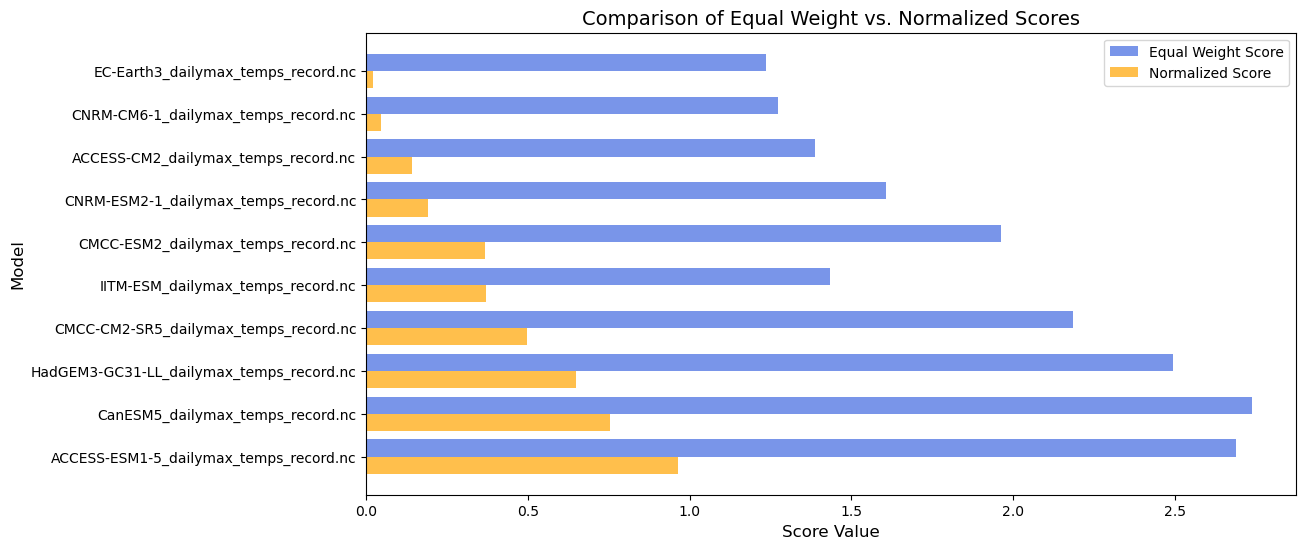

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (update the path if needed)
file_path = "/home/a4wilson/historical_total/model_metrics.csv"  # Ensure this file is in your working directory
full_df = pd.read_csv(file_path)

# Compute the mean RMSE, Bias, and R² for each model
aggregated_full_df = full_df.groupby("Model")[["RMSE", "Bias", "R²"]].mean().reset_index()

# Define Min-Max normalization function
def min_max_norm(series):
    return (series - series.min()) / (series.max() - series.min())

# Compute equally weighted combined score (without normalization)
aggregated_full_df["Equal Weight Score"] = (
    aggregated_full_df["RMSE"] + aggregated_full_df["Bias"] + (1 - aggregated_full_df["R²"])
) / 3

# Compute (1 - R²) since R² is a goodness-of-fit metric
aggregated_full_df["1 - R²"] = 1 - aggregated_full_df["R²"]

# Perform Min-Max Normalization for RMSE, Bias, and (1 - R²)
aggregated_full_df["RMSE_norm"] = min_max_norm(aggregated_full_df["RMSE"])
aggregated_full_df["Bias_norm"] = min_max_norm(aggregated_full_df["Bias"])
aggregated_full_df["R2_norm"] = min_max_norm(aggregated_full_df["1 - R²"])  # Normalize inverted R²

# Compute the final Normalized Score
aggregated_full_df["Normalized Score"] = (
    aggregated_full_df["RMSE_norm"] + aggregated_full_df["Bias_norm"] + aggregated_full_df["R2_norm"]
) / 3

# Print the computed scores for reference
print(aggregated_full_df[["Model", "Equal Weight Score", "Normalized Score"]])

# Visualization: Comparison of Equal Weight vs. Normalized Scores
# Sort data by Normalized Score for a clear comparison
comparison_df_sorted = aggregated_full_df.sort_values(by="Normalized Score")

# Set figure size
plt.figure(figsize=(12, 6))

# Bar width for grouped bars
bar_width = 0.4

# X locations for the groups
x = np.arange(len(comparison_df_sorted))

# Plot both scoring methods side by side for comparison
plt.barh(
    x - bar_width / 2,
    comparison_df_sorted["Equal Weight Score"],
    bar_width,
    label="Equal Weight Score",
    color="royalblue",
    alpha=0.7,
)
plt.barh(
    x + bar_width / 2,
    comparison_df_sorted["Normalized Score"],
    bar_width,
    label="Normalized Score",
    color="orange",
    alpha=0.7,
)

# Labels and title
plt.xlabel("Score Value", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.title("Comparison of Equal Weight vs. Normalized Scores", fontsize=14)
plt.yticks(x, comparison_df_sorted["Model"])
plt.legend()

# Invert y-axis so best models are on top
plt.gca().invert_yaxis()

# Show the plot
plt.show()


In [2]:
# Full updated script to compute Variance Ratio along with RMSE, Bias, and R²

import os
import numpy as np
import xarray as xr
import pandas as pd

def preprocess_model(filepath):
    """Preprocess model data ensuring correct longitude and filtering the time range."""
    print(f"Preprocessing model data: {filepath}")
    model_ds = xr.open_dataset(filepath)

    # Convert longitudes to -180–180
    if "lon" in model_ds and model_ds["lon"].max() > 180:
        model_ds = model_ds.assign_coords(lon=((model_ds["lon"] + 180) % 360) - 180)
        model_ds = model_ds.sortby("lon")

    # Filter time range
    if "year" in model_ds:
        model_ds = model_ds.sel(year=slice(1990, 2014))
    elif "time" in model_ds:
        print("Using 'time' instead of 'year'")
        model_ds = model_ds.sel(time=slice("1990-01-01", "2014-12-31"))

    return model_ds

def preprocess_berkeley(filepath, percentile):
    """Load and preprocess Berkeley data."""
    berkeley_ds = xr.open_dataset(filepath)
    variable_name = f"tmax_{percentile.split('_')[-1]}th_percentile"
    berkeley_data = berkeley_ds[variable_name]
    if "latitude" in berkeley_data.dims or "longitude" in berkeley_data.dims:
        berkeley_data = berkeley_data.rename({"latitude": "lat", "longitude": "lon"})
    return berkeley_data

def regrid_to_model(berkeley_data, model_data):
    """Regrid Berkeley data to match the model grid."""
    return berkeley_data.interp(lat=model_data["lat"], lon=model_data["lon"], method="linear")

def calculate_spatial_r2(model_data, obs_data):
    """Calculate spatial R² after removing area-averaged mean."""
    model_flat = model_data.values.flatten()
    obs_flat = obs_data.values.flatten()

    # Mask NaNs
    valid_mask = ~np.isnan(model_flat) & ~np.isnan(obs_flat)
    model_flat, obs_flat = model_flat[valid_mask], obs_flat[valid_mask]

    if len(model_flat) == 0:
        raise ValueError("No valid data left for R² calculation!")

    # Remove mean temperature before calculating covariance and variance
    model_flat -= np.mean(model_flat)
    obs_flat -= np.mean(obs_flat)

    # Calculate spatial correlation using Pearson's R²
    covariance = np.cov(model_flat, obs_flat)[0, 1]
    model_var = np.var(model_flat)
    obs_var = np.var(obs_flat)
    r_squared = (covariance ** 2) / (model_var * obs_var) if model_var > 0 and obs_var > 0 else np.nan
    return r_squared

def calculate_variance_ratio(model_data, obs_data):
    """Calculate the variance ratio between model and observed data."""
    model_var = np.var(model_data.values.flatten())
    obs_var = np.var(obs_data.values.flatten())

    if obs_var == 0:
        return np.nan  # Avoid division by zero

    return model_var / obs_var

def calculate_metrics(model_data, obs_data):
    """Calculate RMSE, Bias, R², and Variance Ratio between model and observed data."""
    assert model_data.shape == obs_data.shape, "Model and observed data must have the same shape!"

    rmse = np.sqrt(((model_data - obs_data) ** 2))
    bias = model_data - obs_data

    # Calculate updated R² (using anomalies) and Variance Ratio
    r_squared = calculate_spatial_r2(model_data, obs_data)
    variance_ratio = calculate_variance_ratio(model_data, obs_data)

    return rmse.mean().item(), bias.mean().item(), r_squared, variance_ratio

def process_and_generate_metrics(model_directory, percentile_files, output_dir="output_metrics"):
    """Process each model in the directory and generate a CSV with revised metrics."""
    os.makedirs(output_dir, exist_ok=True)
    metrics_data = []

    model_files = [os.path.join(model_directory, f) for f in os.listdir(model_directory) if f.endswith("_dailymax_temps_record.nc")]

    for model_file in model_files:
        print(f"\nProcessing model: {model_file}")
        model_ds = preprocess_model(model_file)

        # Identify temperature variable
        if "tasmax" in model_ds:
            model_data = model_ds["tasmax"].mean(dim="year")
        elif "temperature" in model_ds:
            model_data = model_ds["temperature"].mean(dim="time")
        else:
            print(f"Skipping {model_file}: No recognized temperature variable found.")
            continue

        for percentile, berkeley_file in percentile_files.items():
            berkeley_data = preprocess_berkeley(berkeley_file, percentile)

            # Regrid and limit to 45N–45S
            regridded_berkeley = regrid_to_model(berkeley_data, model_data)
            model_data_limited = model_data.sel(lat=slice(-45, 45))
            regridded_berkeley_limited = regridded_berkeley.sel(lat=slice(-45, 45))

            # Calculate updated metrics
            rmse, bias, r_squared, variance_ratio = calculate_metrics(model_data_limited, regridded_berkeley_limited)

            # Save metrics
            metrics_data.append({
                "Model": os.path.basename(model_file),
                "Percentile": percentile,
                "RMSE": rmse,
                "Bias": bias,
                "R²": r_squared,
                "Variance Ratio": variance_ratio
            })

    # Save metrics to CSV
    metrics_df = pd.DataFrame(metrics_data)
    output_path = os.path.join(output_dir, "model_metrics_with_variance.csv")
    metrics_df.to_csv(output_path, index=False)
    print(f"Metrics saved to: {output_path}")

    return output_path

# Example usage:
model_directory = "/home/a4wilson/historical_total"
percentile_files = {
    "percentile_90": "/home/a4wilson/historical_output/tmax_90th_percentile.nc",
    "percentile_98": "/home/a4wilson/historical_output/tmax_98th_percentile.nc",
    "percentile_99": "/home/a4wilson/historical_output/tmax_99th_percentile.nc"
}

# Run updated processing with refined R² and variance ratio
output_csv_path = process_and_generate_metrics(model_directory, percentile_files)

# Provide download link
output_csv_path



Processing model: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-ESM1-5_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CanESM5_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/CMCC-CM2-SR5_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CMCC-CM2-SR5_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/CNRM-CM6-1_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/CNRM-CM6-1_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc
Preprocessing model data: /home/a4wilson/historical_total/ACCESS-CM2_dailymax_temps_record.nc

Processing model: /home/a4wilson/historical_total/HadGEM3-GC31-LL_dailymax_temps_record.nc

'output_metrics/model_metrics_with_variance.csv'

Found 10 historical models.


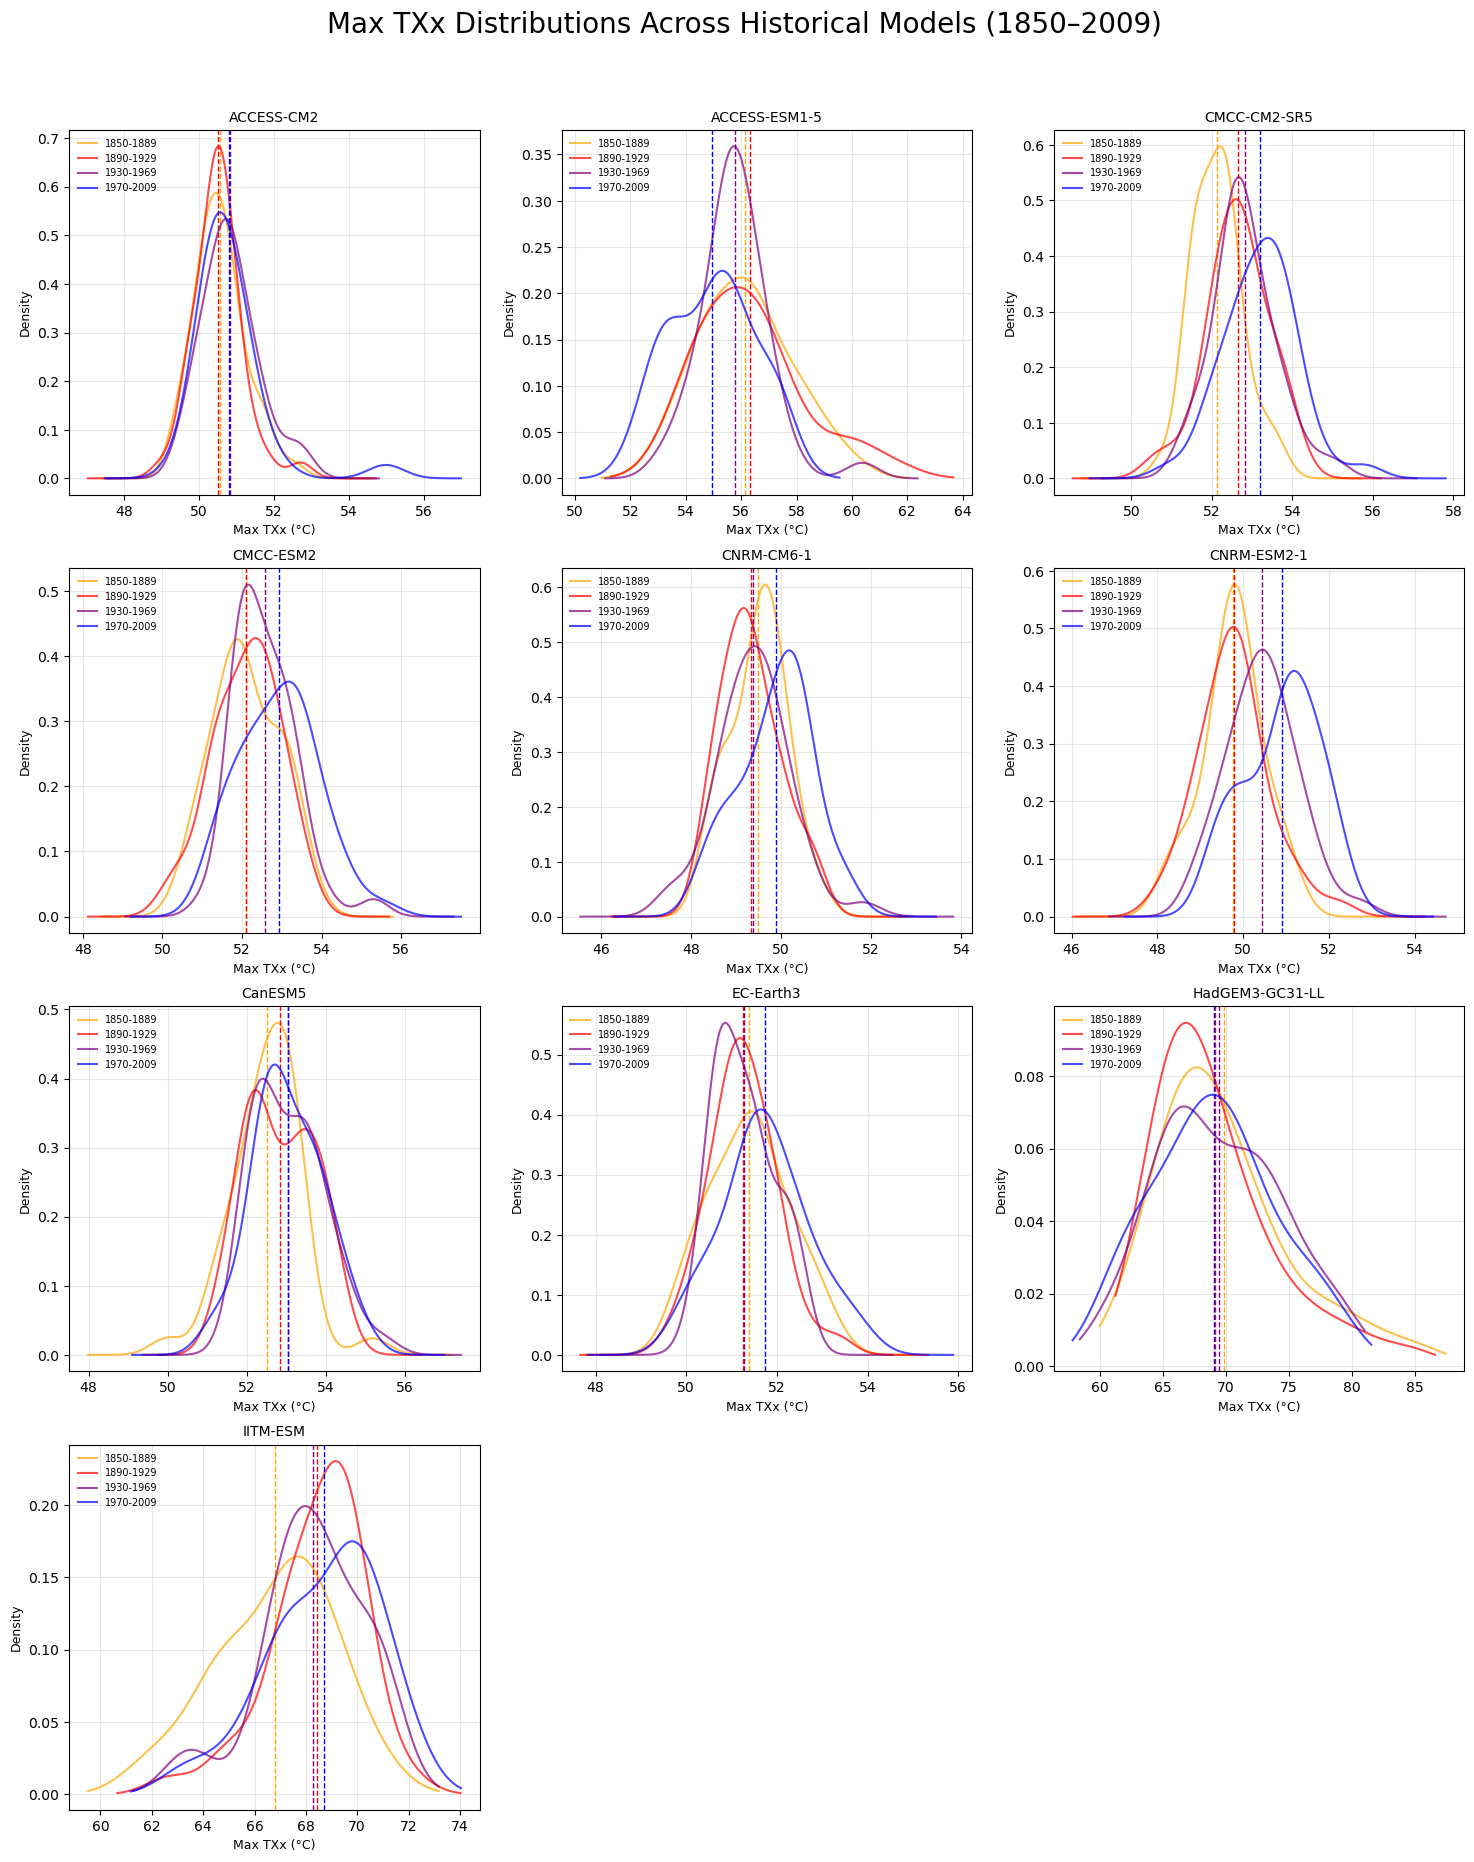

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import xarray as xr
from scipy.stats import gaussian_kde

# Directory for historical data
hist_data_dir = '/home/a4wilson/historical_total/'
model_files_hist = glob.glob(os.path.join(hist_data_dir, '*_dailymax_temps_record.nc'))
model_files_hist.sort()

print(f"Found {len(model_files_hist)} historical models.")

# Set up figure
n_cols = 3
n_rows = (len(model_files_hist) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Define periods and colors
periods_hist = [
    (1850, 1889),
    (1890, 1929),
    (1930, 1969),
    (1970, 2009)
]
colors = ['orange', 'red', 'purple', 'blue']

# Loop through models
for ax, model_path in zip(axes, model_files_hist):
    model_name = os.path.basename(model_path).split('_dailymax_temps_record.nc')[0]

    ds = xr.open_dataset(model_path)
    tasmax = ds['tasmax']

    # Get annual hottest point (TXx)
    if 'time' in tasmax.dims:
        temp_per_year = tasmax.groupby('time.year').max(dim=('lat', 'lon')).values
    elif 'year' in tasmax.dims:
        temp_per_year = tasmax.max(dim=('lat', 'lon')).values

    years = np.arange(1850, 1850 + len(temp_per_year))

    for (start, end), color in zip(periods_hist, colors):
        mask = (years >= start) & (years <= end)
        selected_temp = temp_per_year[mask]

        valid_data = selected_temp[~np.isnan(selected_temp)]

        if len(valid_data) > 5:
            kde = gaussian_kde(valid_data)
            x_grid = np.linspace(valid_data.min()-2, valid_data.max()+2, 300)
            ax.plot(x_grid, kde(x_grid), color=color, alpha=0.7, label=f"{start}-{end}")
            
            mean_val = valid_data.mean()
            ax.axvline(mean_val, color=color, linestyle='--', lw=1)

    ax.set_title(model_name, fontsize=10)
    ax.set_xlabel('Max TXx (°C)', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=7, loc='upper left', frameon=False)  # <-- now legend inside each subplot

# Hide unused subplots
for ax in axes[len(model_files_hist):]:
    ax.axis('off')

# Adjust spacing for clean layout
fig.subplots_adjust(top=0.92, bottom=0.08)  # Closer overall title, but still enough space

fig.suptitle('Max TXx Distributions Across Historical Models (1850–2009)', fontsize=20)

# Save and show
plt.savefig('historical_models_kde_subplots_final_version.png', dpi=300)
plt.show()



Found 23 projection models.


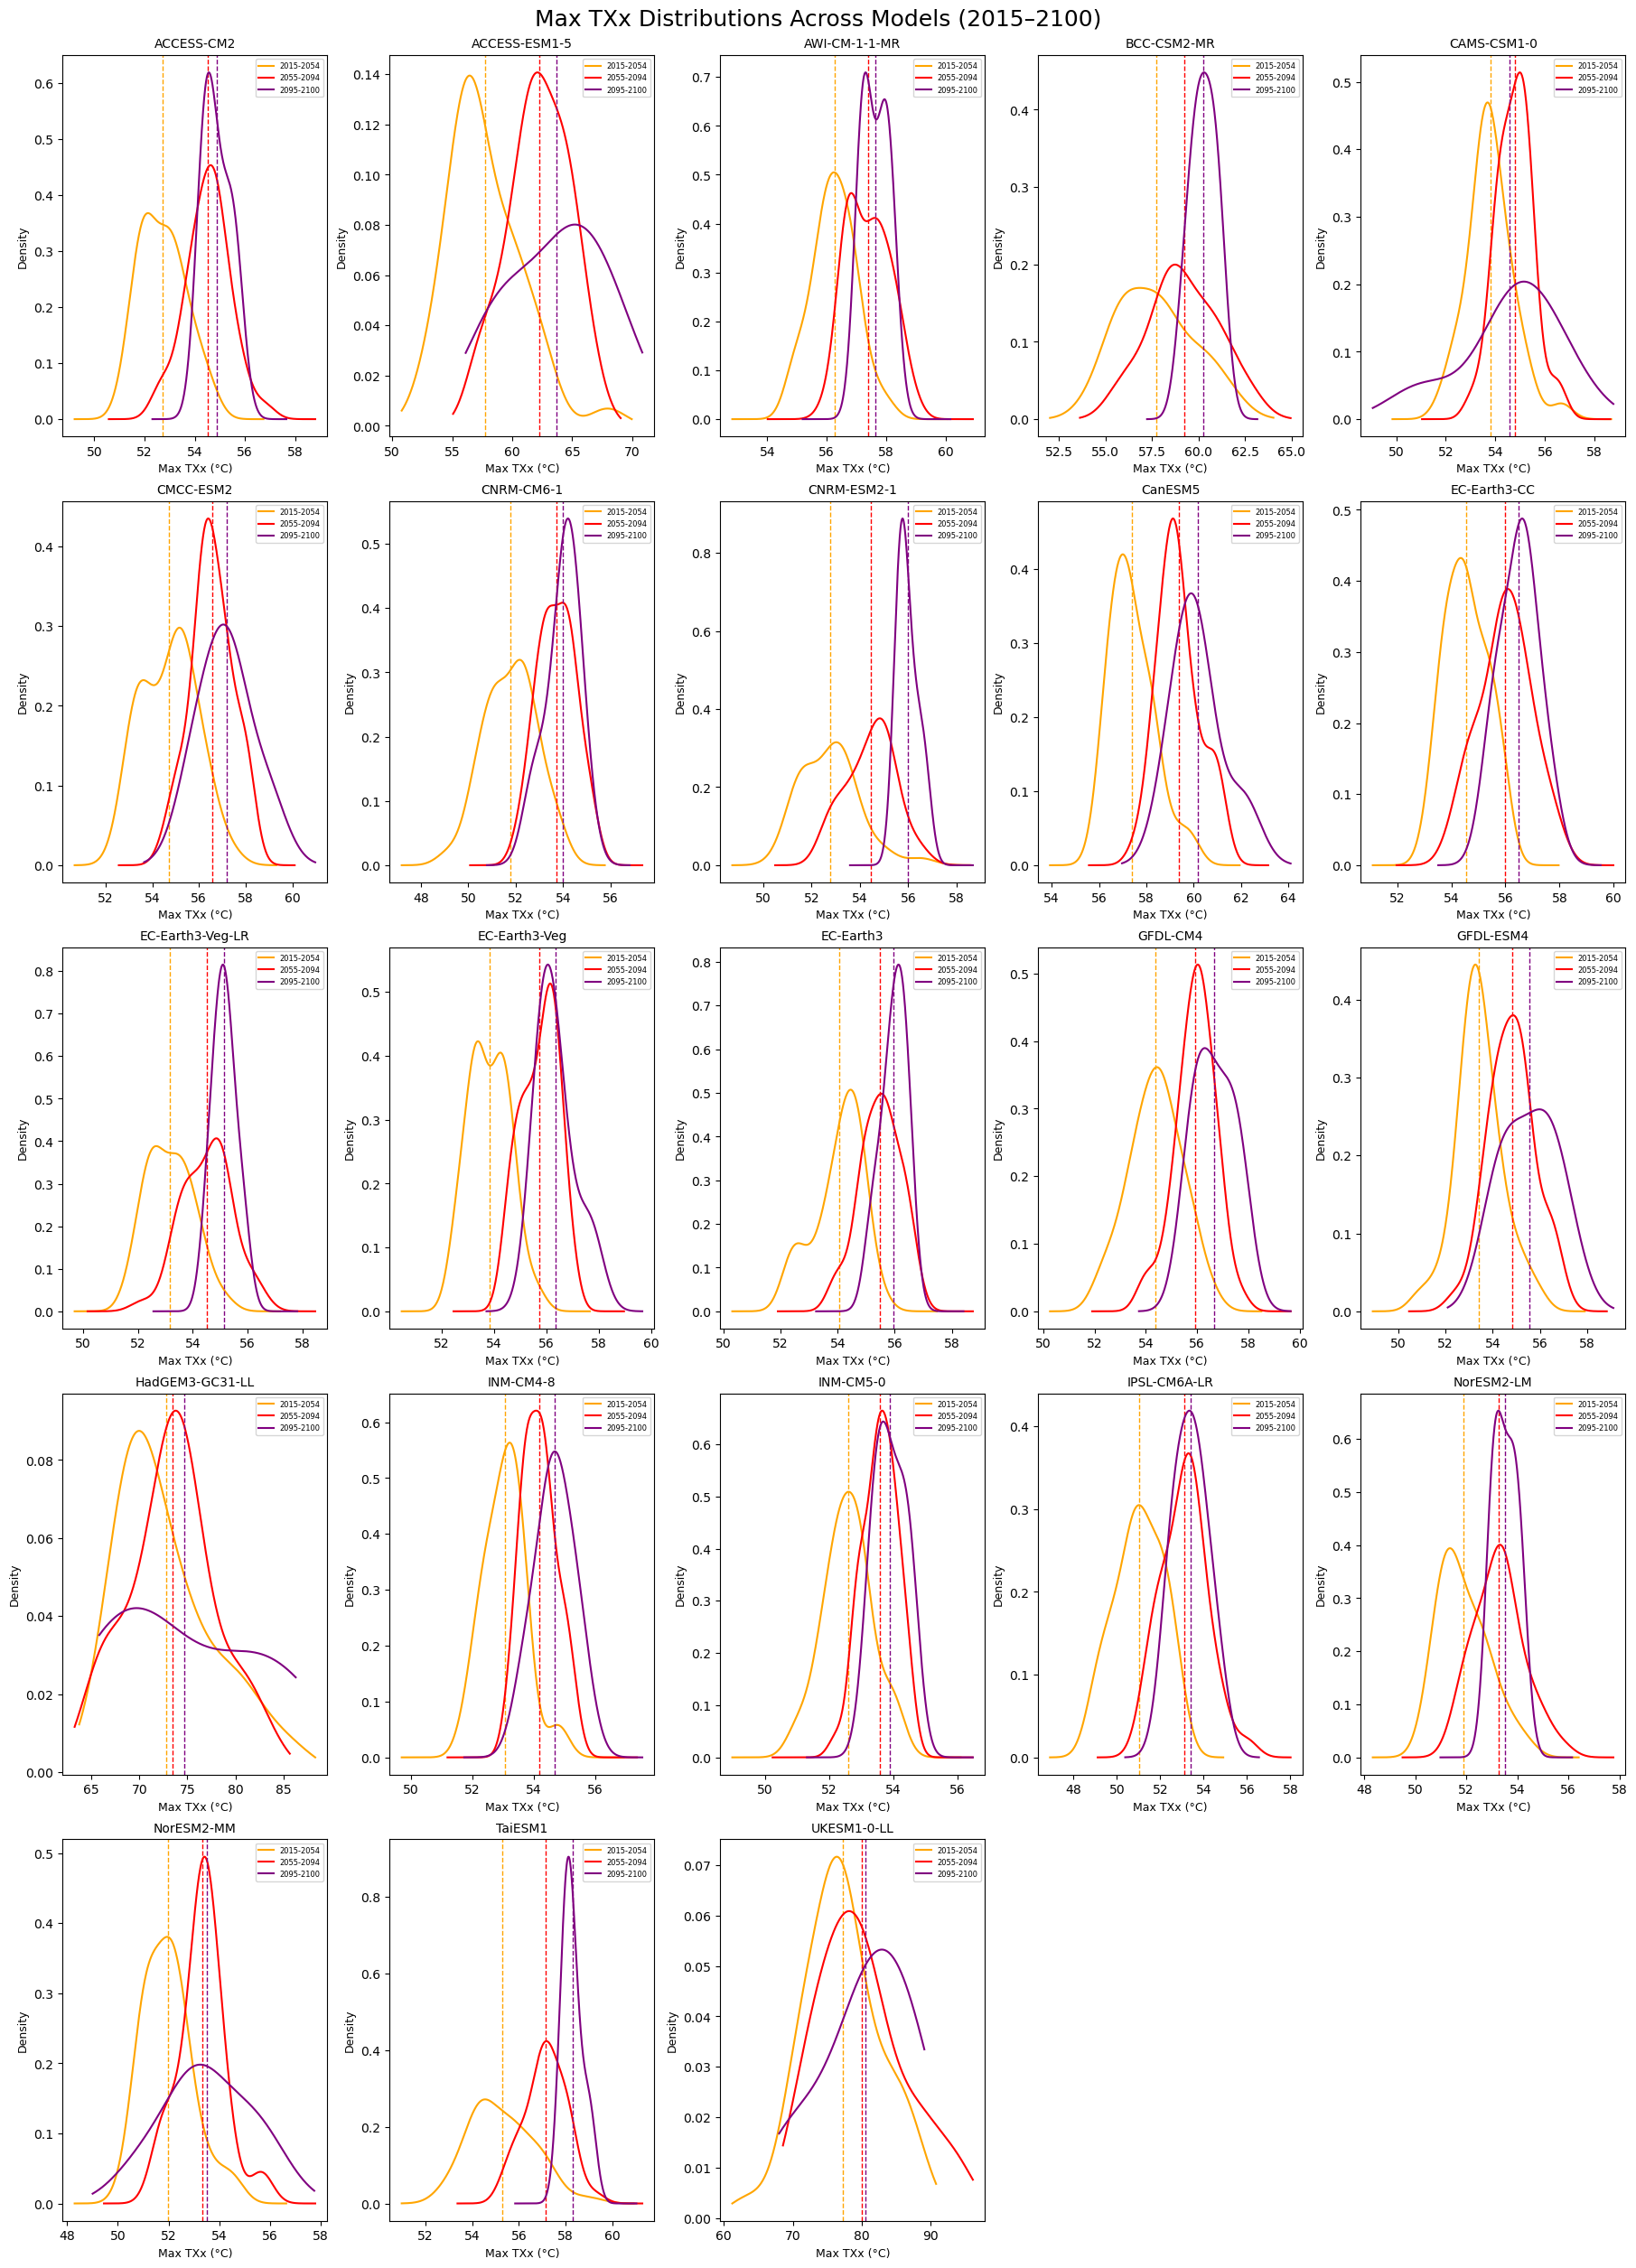

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy.stats import gaussian_kde

# Directory and file setup
proj_data_dir = '/home/a4wilson/historical_total/projections_data/'
model_files_proj = glob.glob(os.path.join(proj_data_dir, '*_dailymax_temp.npy'))
model_files_proj.sort()

print(f"Found {len(model_files_proj)} projection models.")

# Set up figure
n_cols = 5
n_rows = (len(model_files_proj) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Define periods and colors
periods_proj = [
    (2015, 2054),
    (2055, 2094),
    (2095, 2100)  # smaller last window
]
colors = ['orange', 'red', 'purple']

# Loop through models
for ax, model_path in zip(axes, model_files_proj):
    model_name = os.path.basename(model_path).split('_dailymax_temp.npy')[0]

    # Load and process data
    temp = np.load(model_path)
    
    # Convert Kelvin to Celsius
    temp_celsius = temp - 273.15

    n_years = temp_celsius.shape[0]
    years = np.arange(2015, 2015 + n_years)

    for (start, end), color in zip(periods_proj, colors):
        mask = (years >= start) & (years <= end)
        selected_temp = temp_celsius[mask]

        # Use max value (already the daily max)
        valid_data = selected_temp[~np.isnan(selected_temp)]

        if len(valid_data) > 0:
            kde = gaussian_kde(valid_data)
            x_grid = np.linspace(valid_data.min()-2, valid_data.max()+2, 500)
            ax.plot(x_grid, kde(x_grid), label=f"{start}-{end}", color=color)
            
            # Mean line
            mean_val = valid_data.mean()
            ax.axvline(mean_val, color=color, linestyle='--', lw=1)

    ax.set_title(model_name, fontsize=10)
    ax.set_xlabel('Max TXx (°C)', fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.legend(fontsize=6)

# Hide unused subplots
for ax in axes[len(model_files_proj):]:
    ax.axis('off')

fig.suptitle('Max TXx Distributions Across Models (2015–2100)', fontsize=18)
plt.savefig('/home/a4wilson/historical_total/projections_data/all_model_kde_projections.png', dpi=300)
plt.show()


Found 10 historical models.


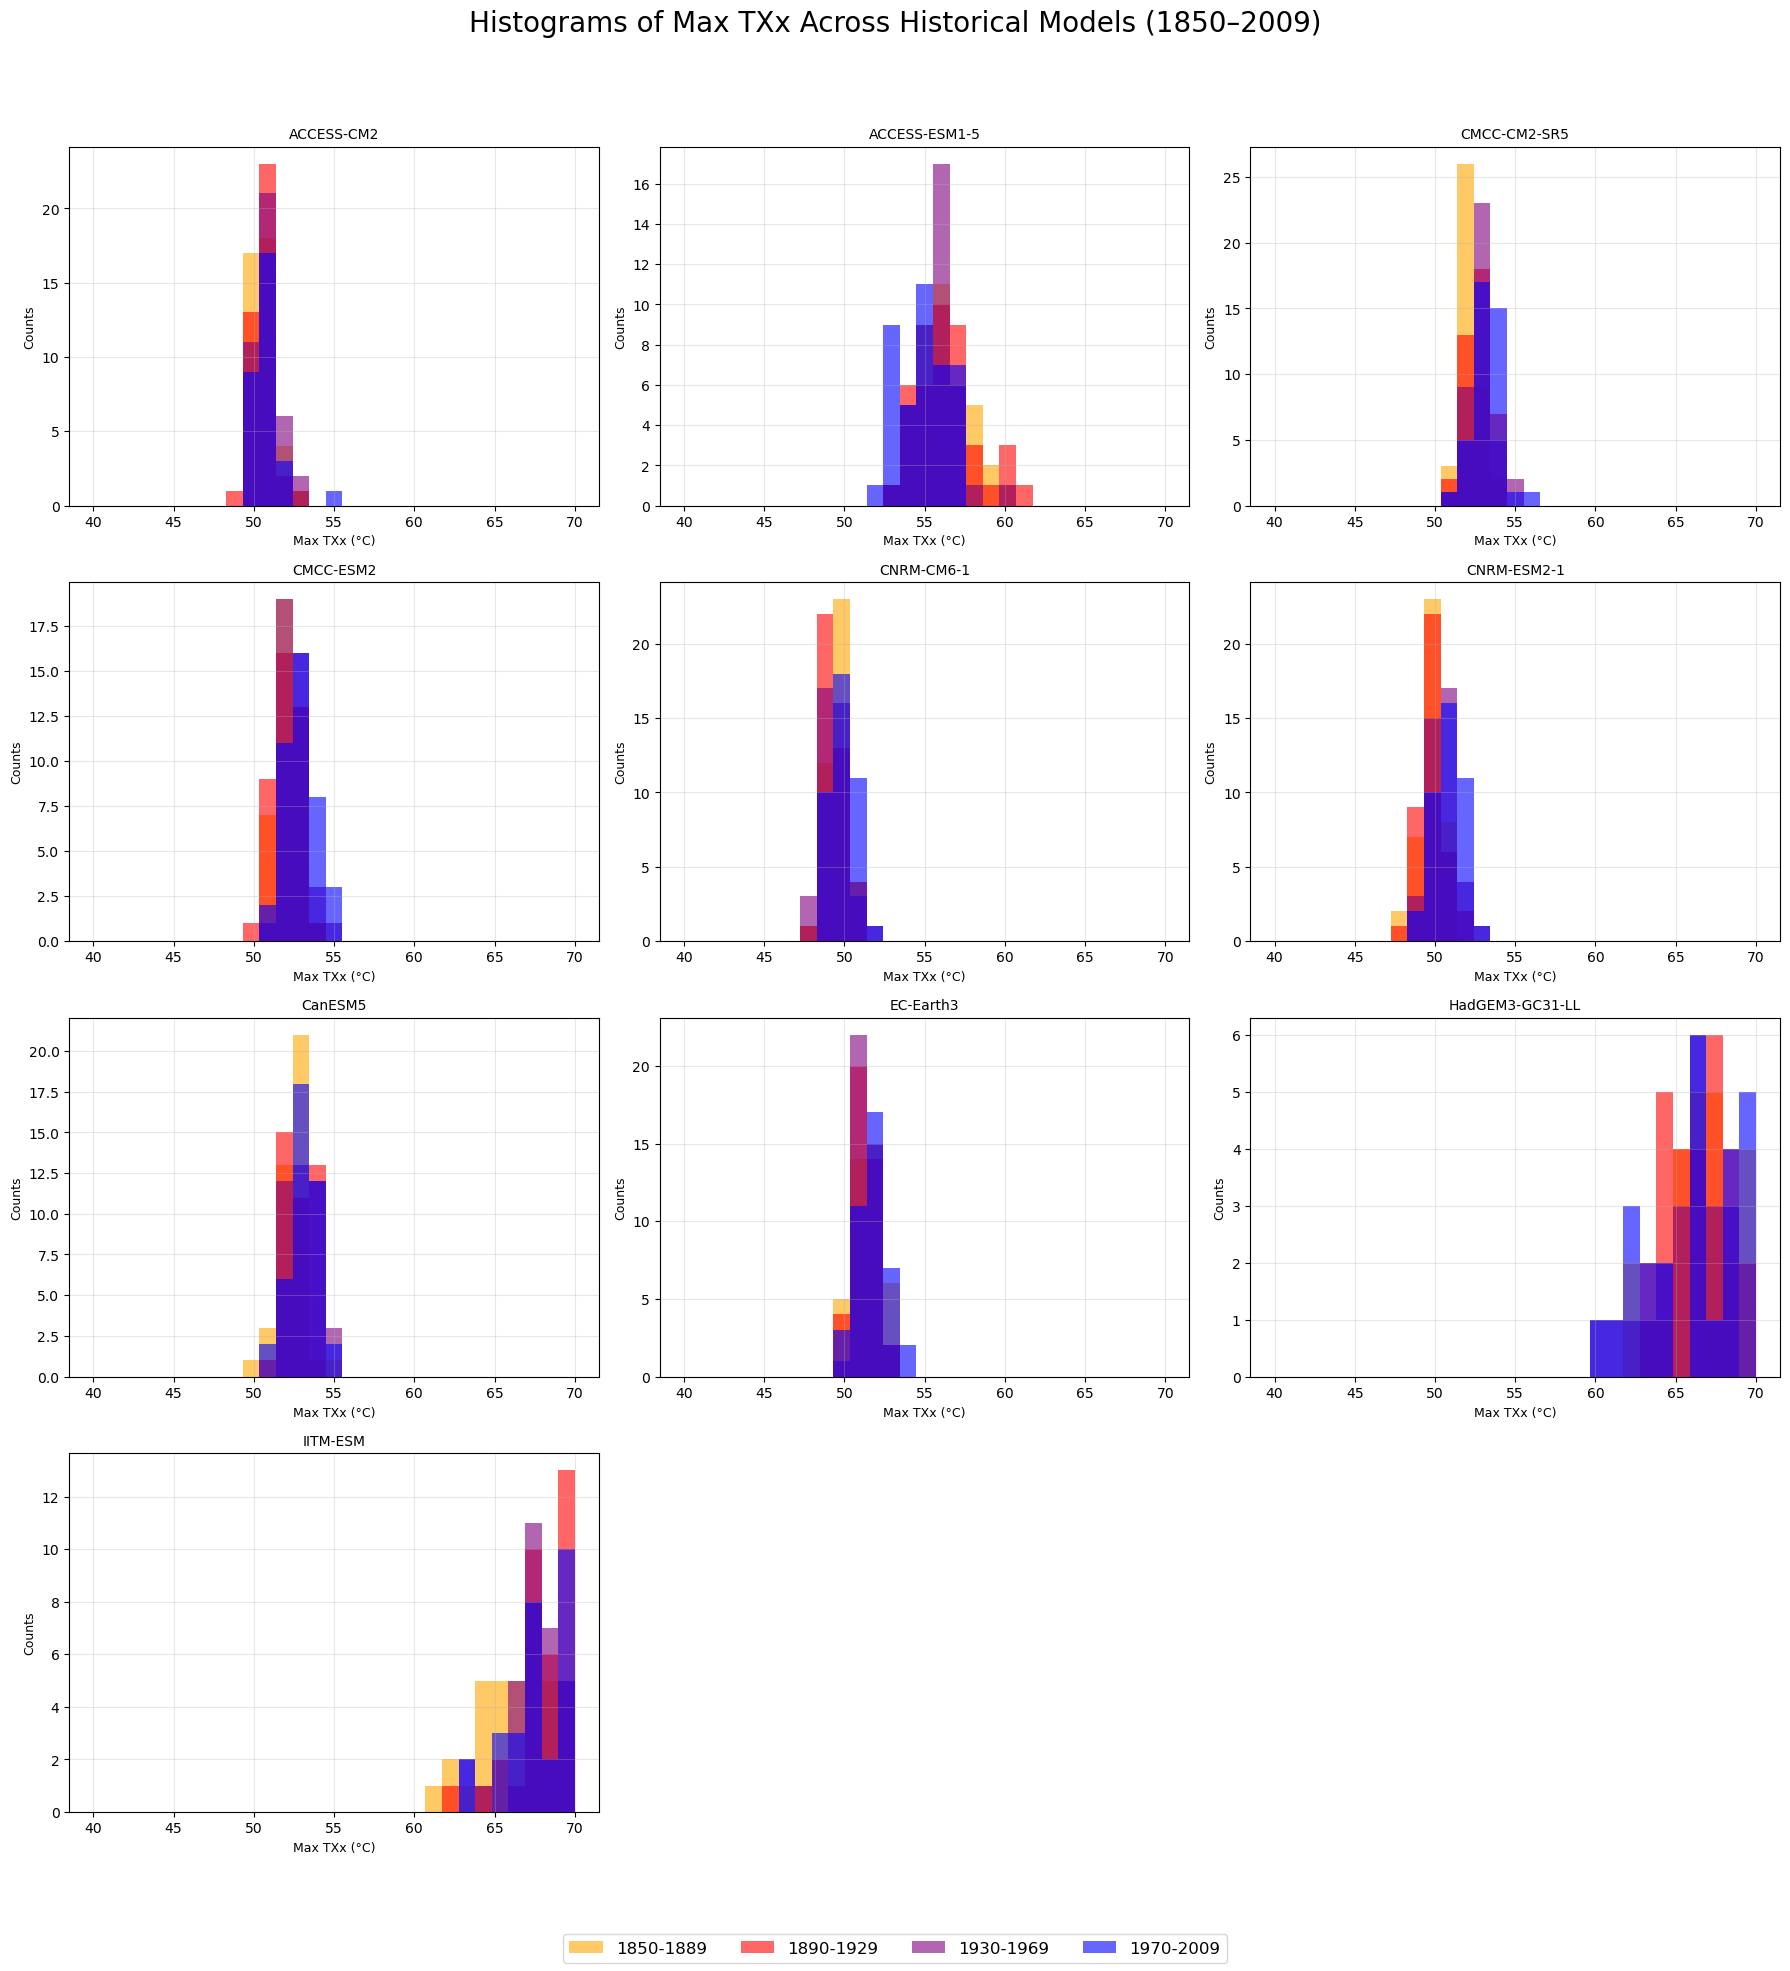

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import xarray as xr

# Directory for historical data
hist_data_dir = '/home/a4wilson/historical_total/'
model_files_hist = glob.glob(os.path.join(hist_data_dir, '*_dailymax_temps_record.nc'))
model_files_hist.sort()

print(f"Found {len(model_files_hist)} historical models.")

# Set up figure
n_cols = 3
n_rows = (len(model_files_hist) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

# Define periods and colors
periods_hist = [
    (1850, 1889),
    (1890, 1929),
    (1930, 1969),
    (1970, 2009)
]
colors = ['orange', 'red', 'purple', 'blue']

# Define consistent bins
bins = np.linspace(40, 70, 30)  # Adjust if needed based on your TXx values

# Loop through models
for ax_idx, (ax, model_path) in enumerate(zip(axes, model_files_hist)):
    model_name = os.path.basename(model_path).split('_dailymax_temps_record.nc')[0]

    ds = xr.open_dataset(model_path)
    tasmax = ds['tasmax']

    if 'time' in tasmax.dims:
        temp_per_year = tasmax.groupby('time.year').max(dim=('lat', 'lon')).values
    elif 'year' in tasmax.dims:
        temp_per_year = tasmax.max(dim=('lat', 'lon')).values

    years = np.arange(1850, 1850 + len(temp_per_year))

    for i, ((start, end), color) in enumerate(zip(periods_hist, colors)):
        mask = (years >= start) & (years <= end)
        selected_temp = temp_per_year[mask]

        valid_data = selected_temp[~np.isnan(selected_temp)]

        if len(valid_data) > 0:
            label = f"{start}-{end}" if ax_idx == 0 else None
            ax.hist(valid_data, bins=bins, color=color, alpha=0.6, label=label, histtype='stepfilled')

    ax.set_title(model_name, fontsize=10)
    ax.set_xlabel('Max TXx (°C)', fontsize=9)
    ax.set_ylabel('Counts', fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for ax in axes[len(model_files_hist):]:
    ax.axis('off')

# Global title
fig.suptitle('Histograms of Max TXx Across Historical Models (1850–2009)', fontsize=20)

# Add global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(periods_hist), fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # leave space at bottom for legend
plt.savefig('historical_models_histograms_subplots_final.png', dpi=300)
plt.show()



Found 23 projection models.
Processing ACCESS-CM2...
Processing ACCESS-ESM1-5...
Processing AWI-CM-1-1-MR...
Processing BCC-CSM2-MR...
Processing CAMS-CSM1-0...
Processing CMCC-ESM2...
Processing CNRM-CM6-1...
Processing CNRM-ESM2-1...
Processing CanESM5...
Processing EC-Earth3-CC...
Processing EC-Earth3-Veg-LR...
Processing EC-Earth3-Veg...
Processing EC-Earth3...
Processing GFDL-CM4...
Processing GFDL-ESM4...
Processing HadGEM3-GC31-LL...
Processing INM-CM4-8...
Processing INM-CM5-0...
Processing IPSL-CM6A-LR...
Processing NorESM2-LM...
Processing NorESM2-MM...
Processing TaiESM1...
Processing UKESM1-0-LL...


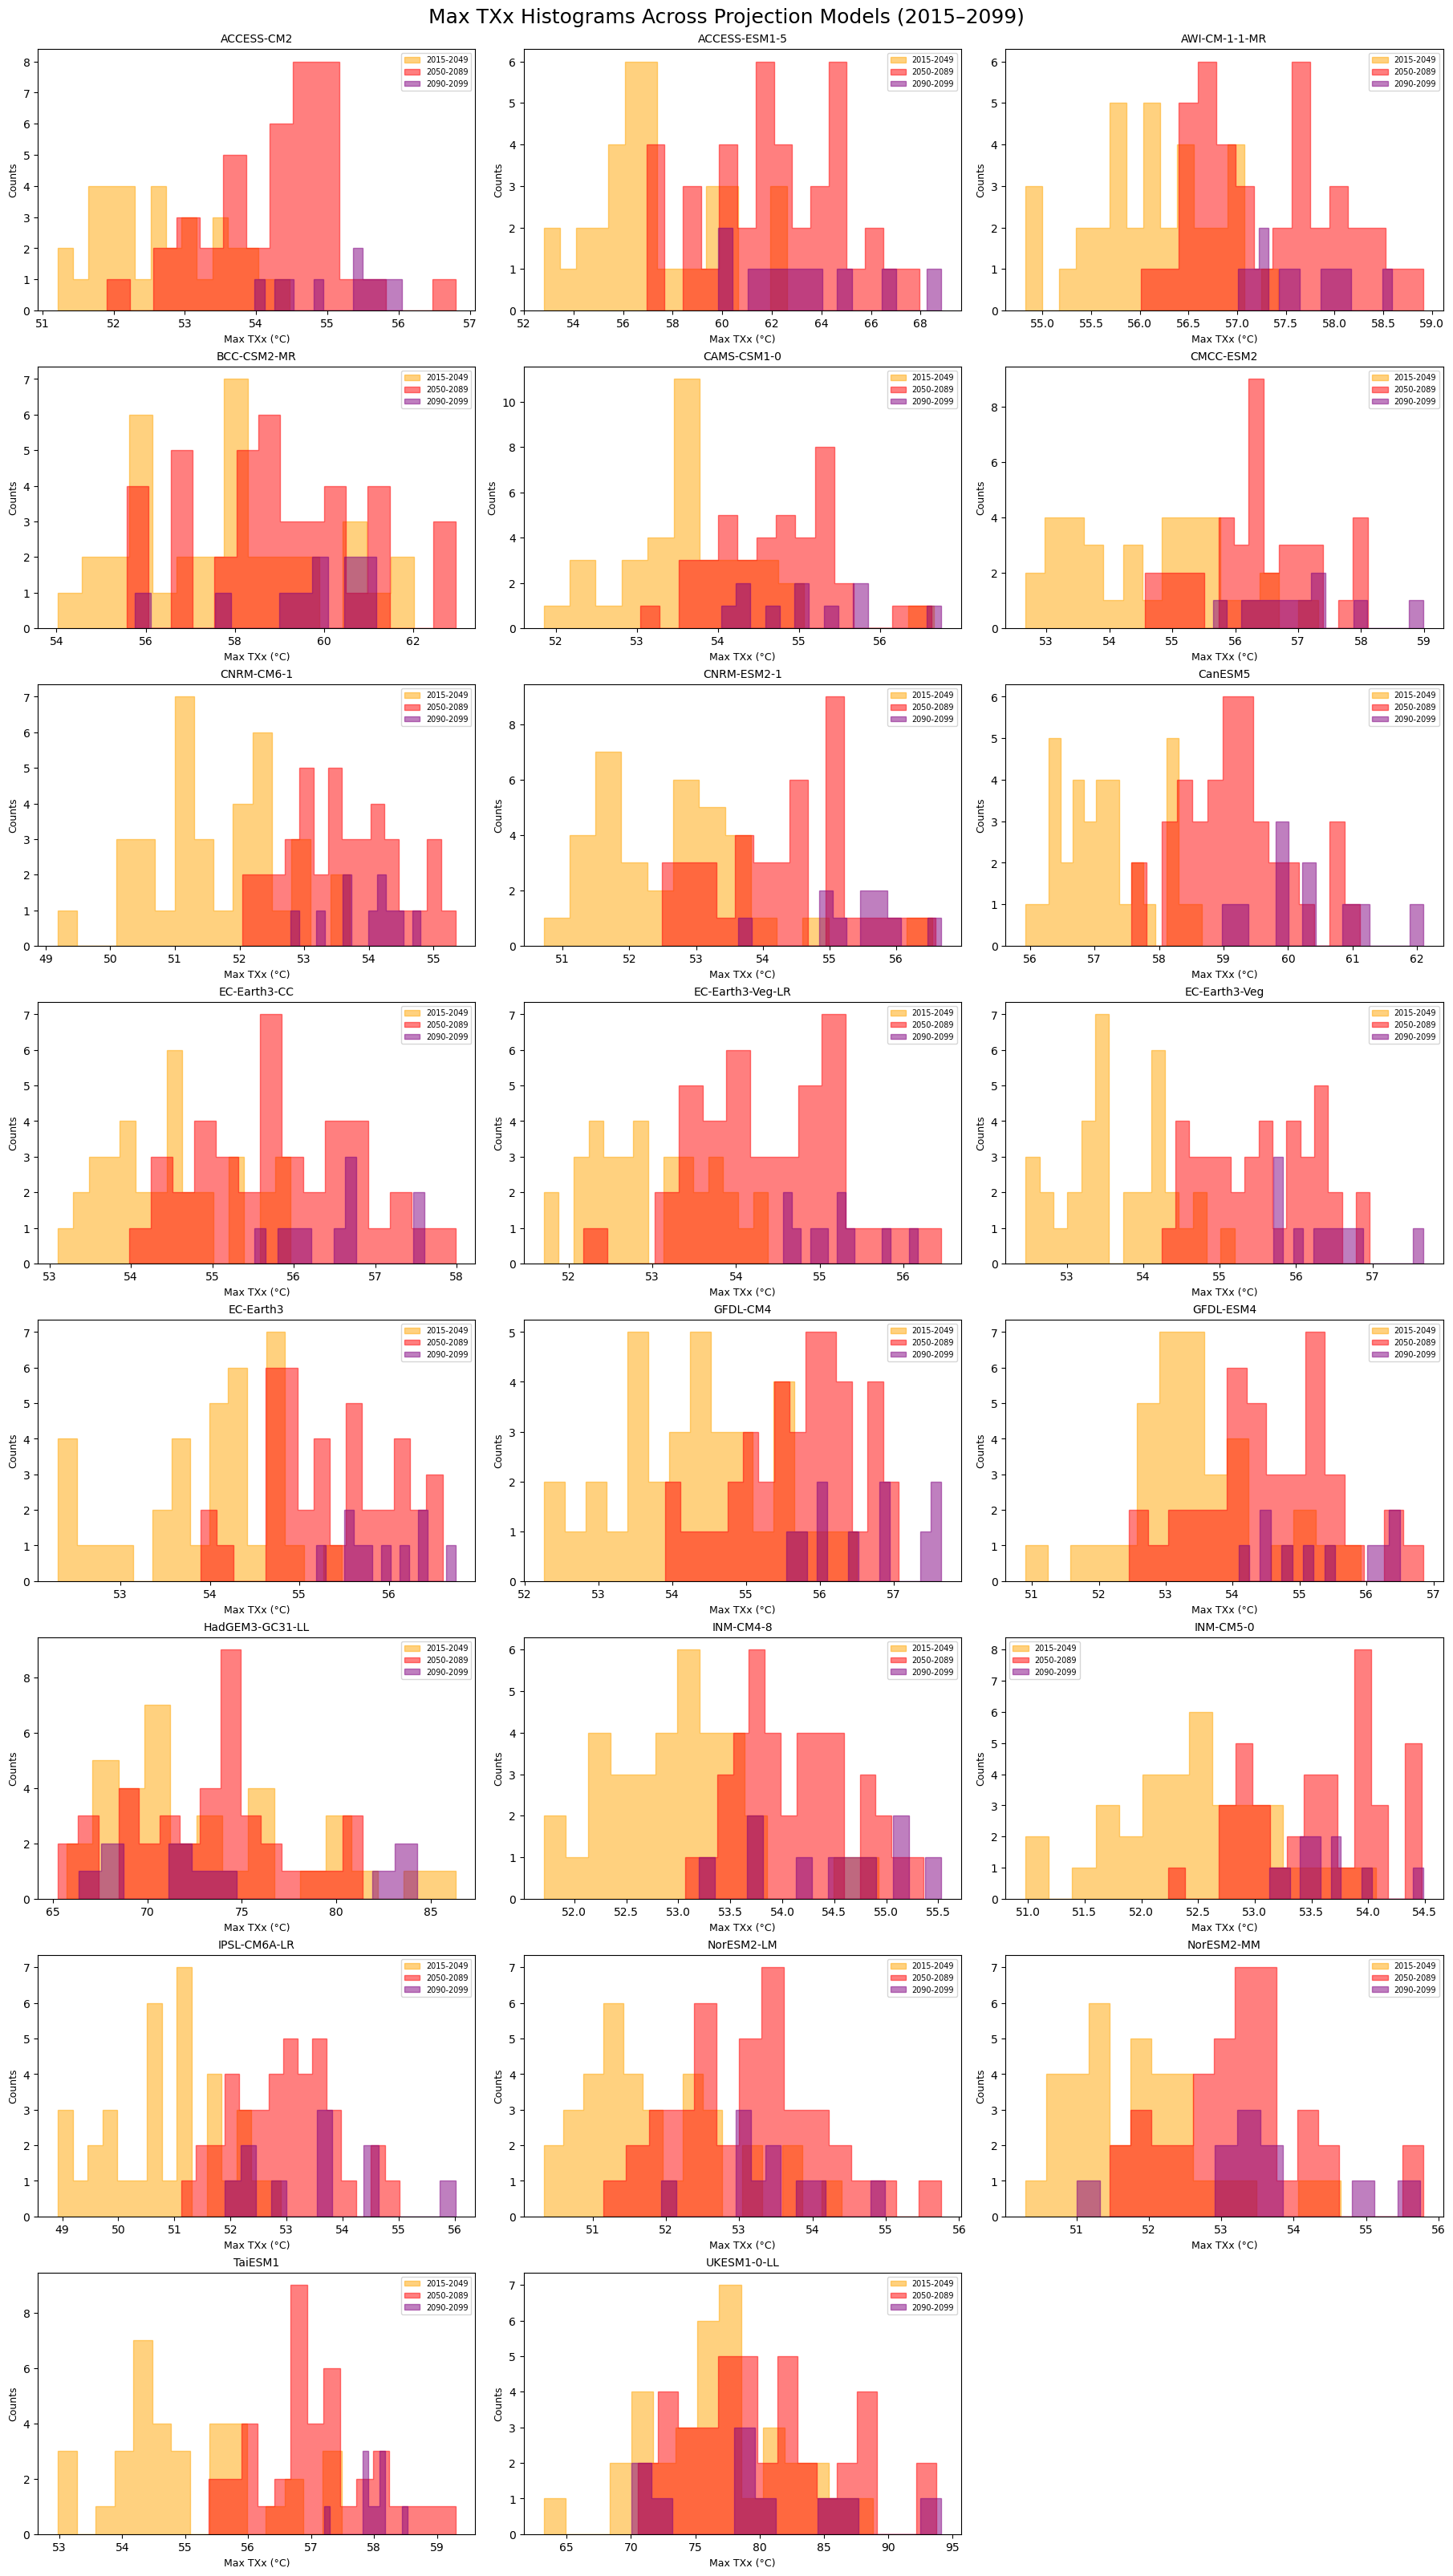

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# --- Setup ---
proj_data_dir = '/home/a4wilson/historical_total/projections_data/'
model_files_proj = glob.glob(os.path.join(proj_data_dir, '*_dailymax_temp.npy'))
model_files_proj.sort()

print(f"Found {len(model_files_proj)} projection models.")

# --- Set up figure ---
n_cols = 3
n_rows = (len(model_files_proj) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

# --- Colors and periods ---
colors = ['orange', 'red', 'purple']
periods = [
    (2015, 2049),
    (2050, 2089),
    (2090, 2099)
]

# --- Loop through models ---
for ax, model_path in zip(axes, model_files_proj):
    model_name = os.path.basename(model_path).replace('_dailymax_temp.npy', '')
    print(f"Processing {model_name}...")

    data = np.load(model_path)  # shape = (time, lat, lon)
    n_years = data.shape[0]
    years = np.arange(2015, 2015 + n_years)

    # Get hottest daily temperature globally each year
    hottest_each_year = data.reshape(n_years, -1).max(axis=1)

    # Convert from Kelvin to Celsius
    hottest_each_year = hottest_each_year - 273.15

    # Plot histogram overlays by period
    for (start, end), color in zip(periods, colors):
        mask = (years >= start) & (years <= end)
        if np.sum(mask) == 0:
            continue
        period_data = hottest_each_year[mask]

        ax.hist(period_data, bins=15, histtype='stepfilled', alpha=0.5,
                label=f"{start}-{end}", color=color, edgecolor=color)

    ax.set_title(model_name, fontsize=10)
    ax.set_xlabel('Max TXx (°C)', fontsize=9)
    ax.set_ylabel('Counts', fontsize=9)
    ax.legend(fontsize=7)

# Hide unused subplots
for i in range(len(model_files_proj), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Max TXx Histograms Across Projection Models (2015–2099)', fontsize=18)
plt.savefig('projection_model_histograms_counts.png', dpi=300)
plt.show()


Found 23 projection models.


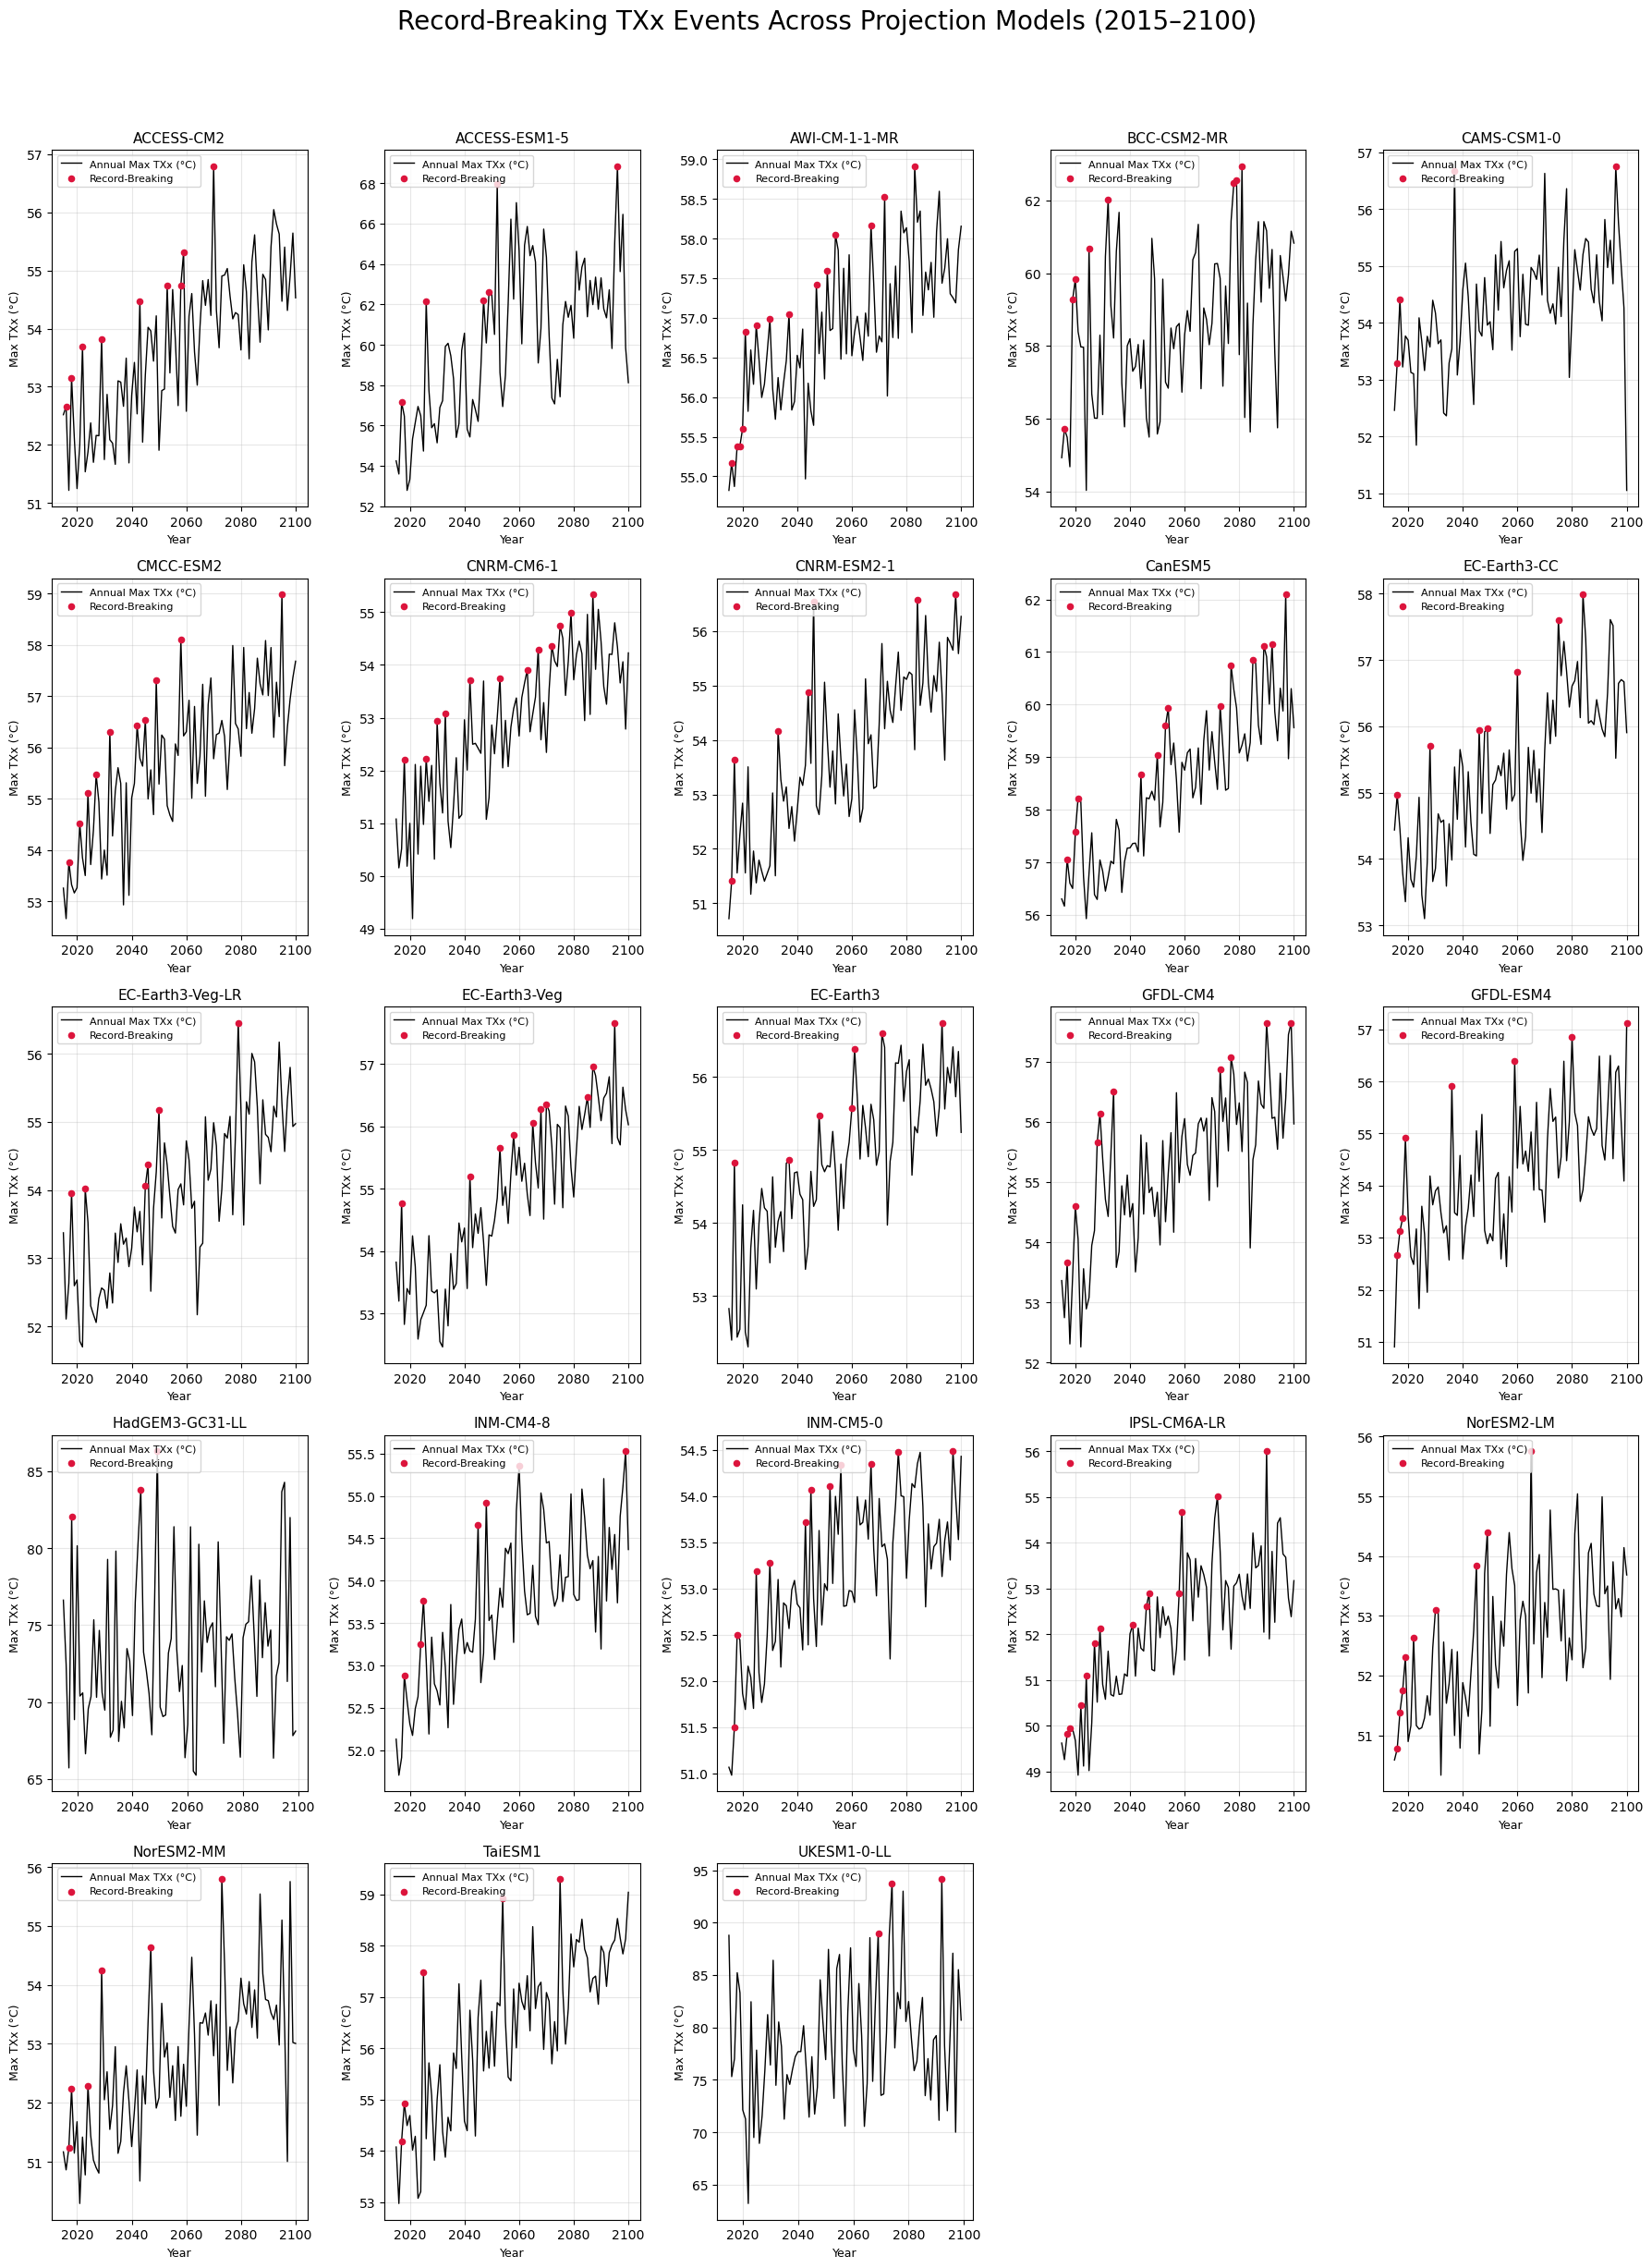

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Directory for projection data
proj_data_dir = '/home/a4wilson/historical_total/projections_data/'
model_files_proj = glob.glob(os.path.join(proj_data_dir, '*_dailymax_temp.npy'))
model_files_proj.sort()

print(f"Found {len(model_files_proj)} projection models.")

# Set up subplots
n_cols = 5
n_rows = (len(model_files_proj) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

start_year = 2015

for ax, model_file in zip(axes, model_files_proj):
    model_name = os.path.basename(model_file).replace('_dailymax_temp.npy', '')

    # Load hottest temperature per year (already 1D)
    hottest_each_year = np.load(model_file)

    # Convert from Kelvin to Celsius
    hottest_each_year_celsius = hottest_each_year - 273.15

    years = np.arange(start_year, start_year + len(hottest_each_year))

    # Identify record-breaking events
    current_record = -np.inf
    is_record = []

    for temp in hottest_each_year_celsius:
        if temp > current_record:
            is_record.append(True)
            current_record = temp
        else:
            is_record.append(False)

    # Exclude the first year from being counted as a record
    is_record[0] = False

    # Plot line
    ax.plot(years, hottest_each_year_celsius, label='Annual Max TXx (°C)', color='black', lw=1)
    # Plot red dots for record-breaking years
    ax.scatter(years[is_record], hottest_each_year_celsius[is_record], color='crimson', label='Record-Breaking', zorder=5, s=20)

    ax.set_title(model_name, fontsize=11)
    ax.set_xlabel('Year', fontsize=9)
    ax.set_ylabel('Max TXx (°C)', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='upper left')

# Hide unused subplots
for ax in axes[len(model_files_proj):]:
    ax.axis('off')

fig.suptitle('Record-Breaking TXx Events Across Projection Models (2015–2100)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.savefig('projection_models_record_breaking_lineplots_celsius.png', dpi=300)
plt.show()


Found 10 historical models.


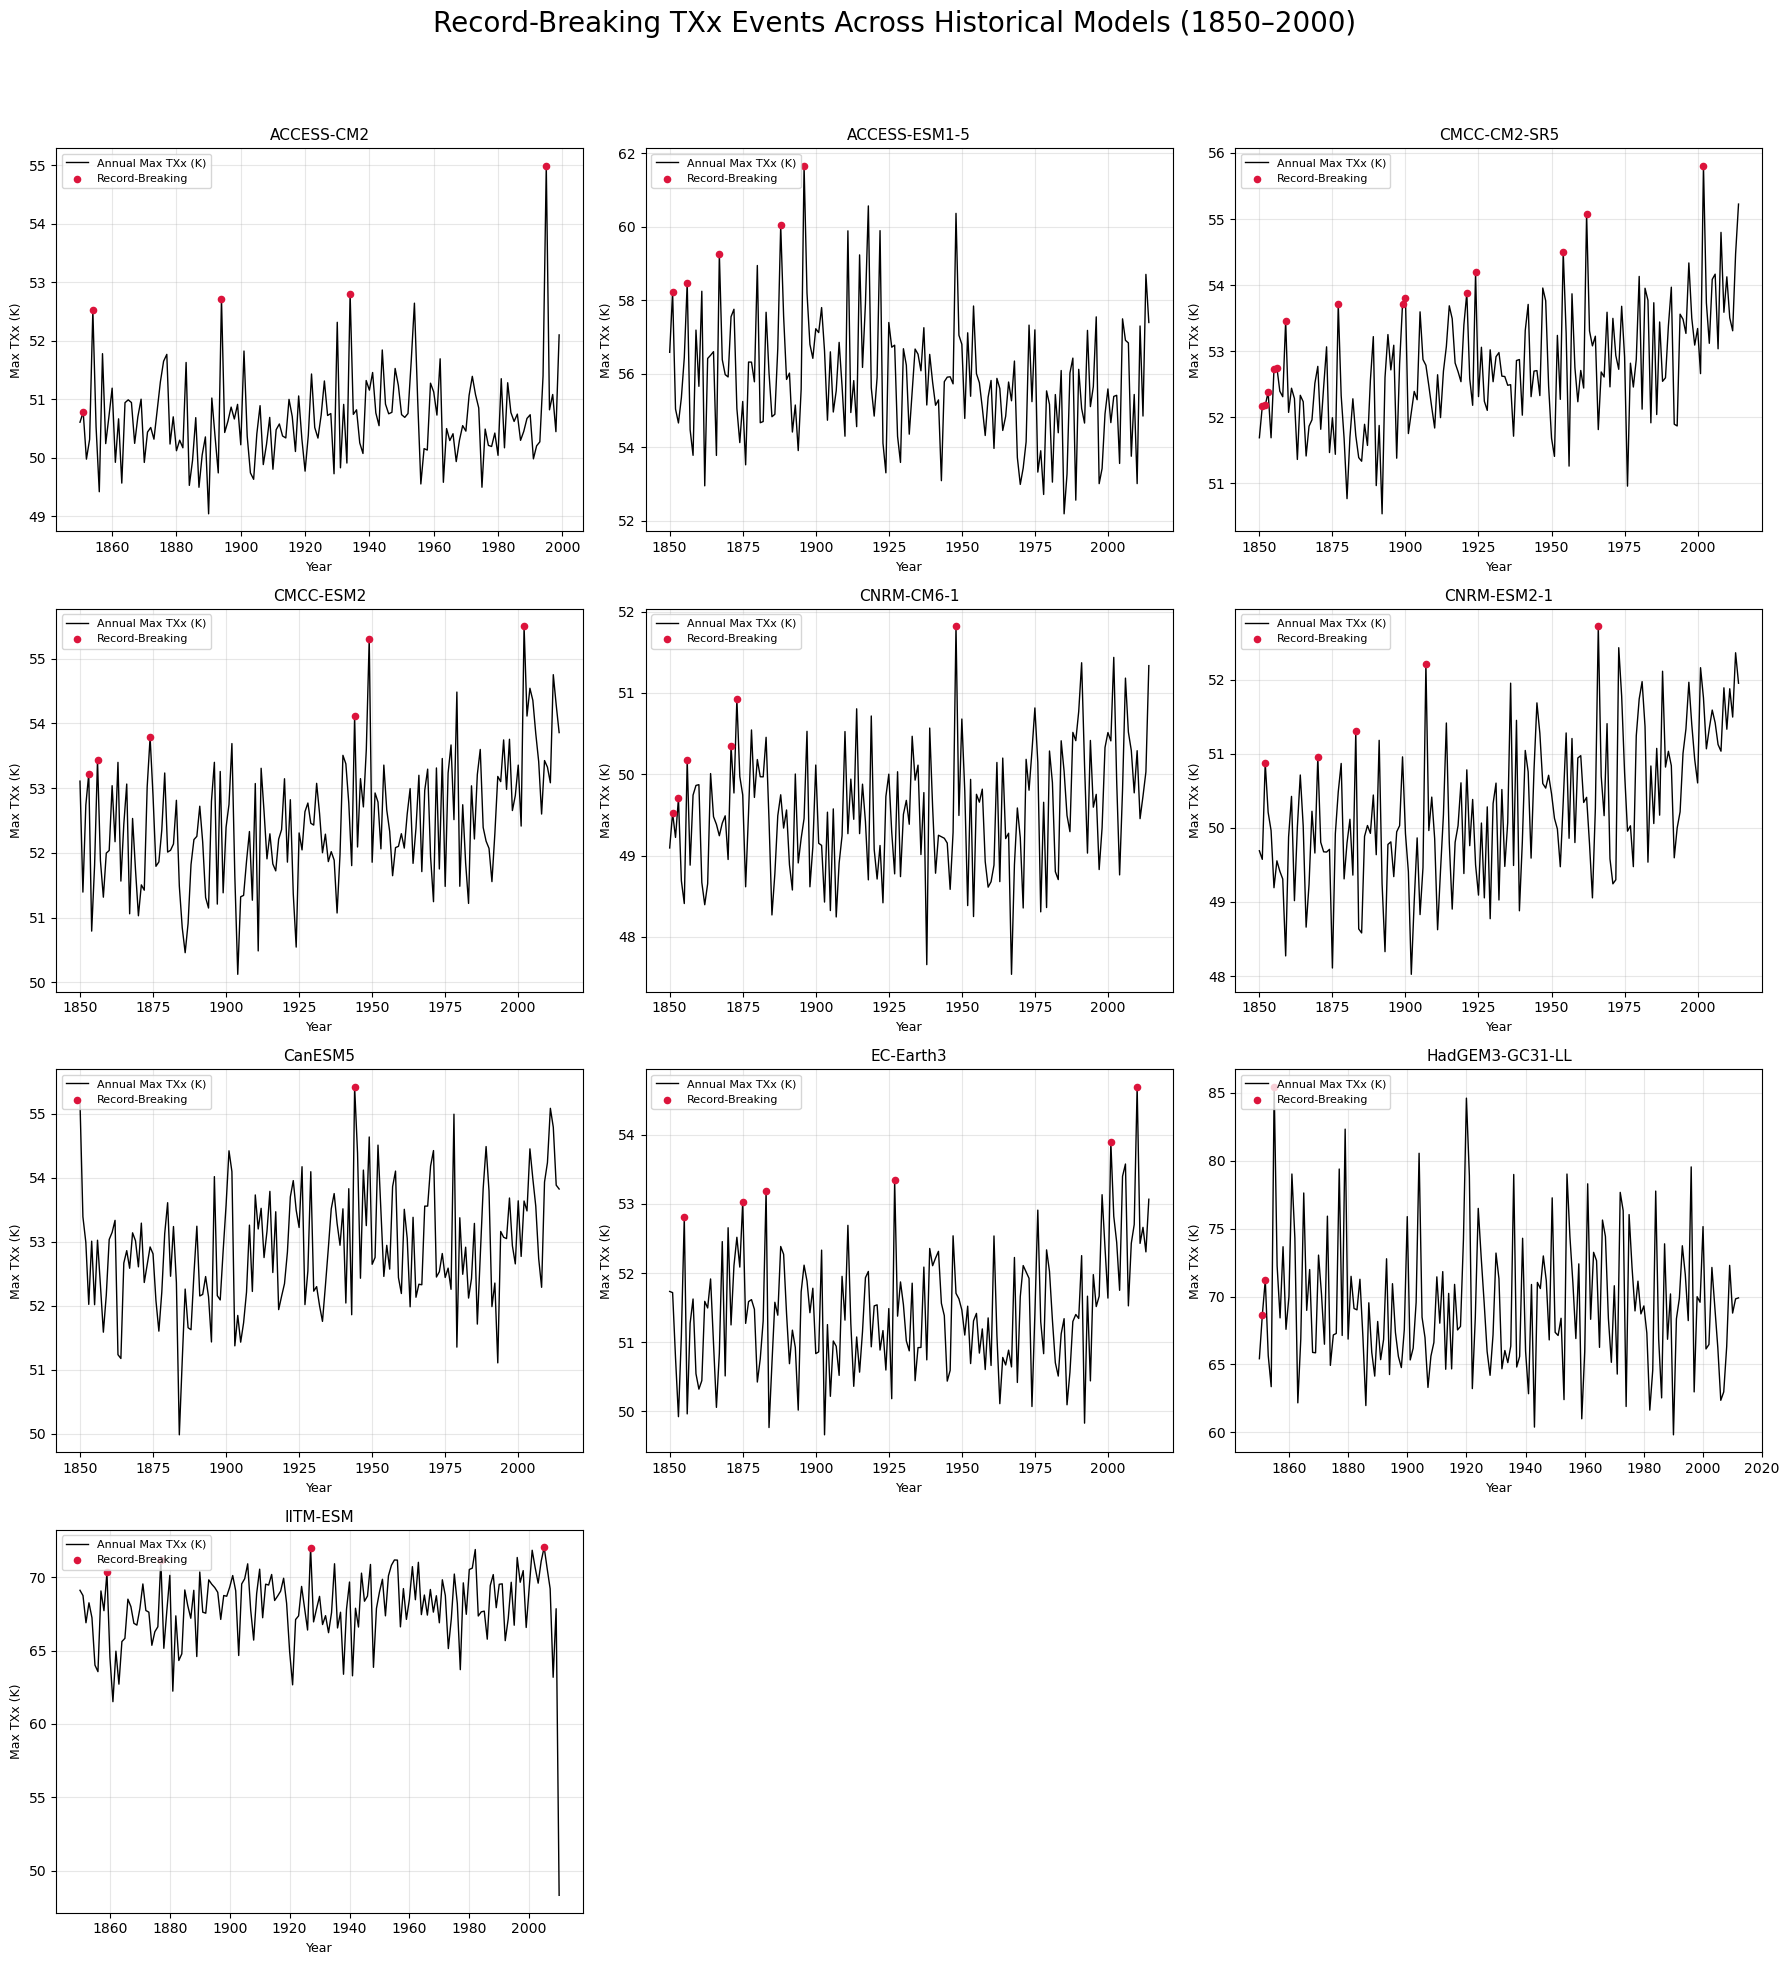

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import xarray as xr

# Directory for historical model data
hist_data_dir = '/home/a4wilson/historical_total/'
model_files_hist = glob.glob(os.path.join(hist_data_dir, '*_dailymax_temps_record.nc'))
model_files_hist.sort()

print(f"Found {len(model_files_hist)} historical models.")

# Set up subplots
n_cols = 3
n_rows = (len(model_files_hist) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten()

start_year_hist = 1850

for ax, model_file in zip(axes, model_files_hist):
    model_name = os.path.basename(model_file).replace('_dailymax_temps_record.nc', '')

    ds = xr.open_dataset(model_file)

    if 'tasmax' not in ds:
        print(f"tasmax not found for {model_name}, skipping...")
        continue

    tasmax = ds['tasmax']

    # Get hottest daily maximum per year
    if 'time' in tasmax.dims:
        hottest_each_year = tasmax.groupby('time.year').max(dim=('lat', 'lon')).values
    elif 'year' in tasmax.dims:
        hottest_each_year = tasmax.max(dim=('lat', 'lon')).values
    else:
        print(f"Unknown time dimension for {model_name}, skipping...")
        continue

    years = np.arange(start_year_hist, start_year_hist + len(hottest_each_year))

    # Identify record-breaking events
    current_record = -np.inf
    is_record = []

    for temp in hottest_each_year:
        if temp > current_record:
            is_record.append(True)
            current_record = temp
        else:
            is_record.append(False)

    # Exclude the first year
    if len(is_record) > 0:
        is_record[0] = False

    # Plot line
    ax.plot(years, hottest_each_year, label='Annual Max TXx (K)', color='black', lw=1)
    # Plot red dots for record-breaking years
    ax.scatter(years[is_record], hottest_each_year[is_record], color='crimson', label='Record-Breaking', zorder=5, s=20)

    ax.set_title(model_name, fontsize=11)
    ax.set_xlabel('Year', fontsize=9)
    ax.set_ylabel('Max TXx (K)', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8, loc='upper left')

# Hide unused subplots
for ax in axes[len(model_files_hist):]:
    ax.axis('off')

fig.suptitle('Record-Breaking TXx Events Across Historical Models (1850–2000)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.savefig('historical_models_record_breaking_lineplots_kelvin.png', dpi=300)
plt.show()


Found 10 historical models.
Found 23 projection models.


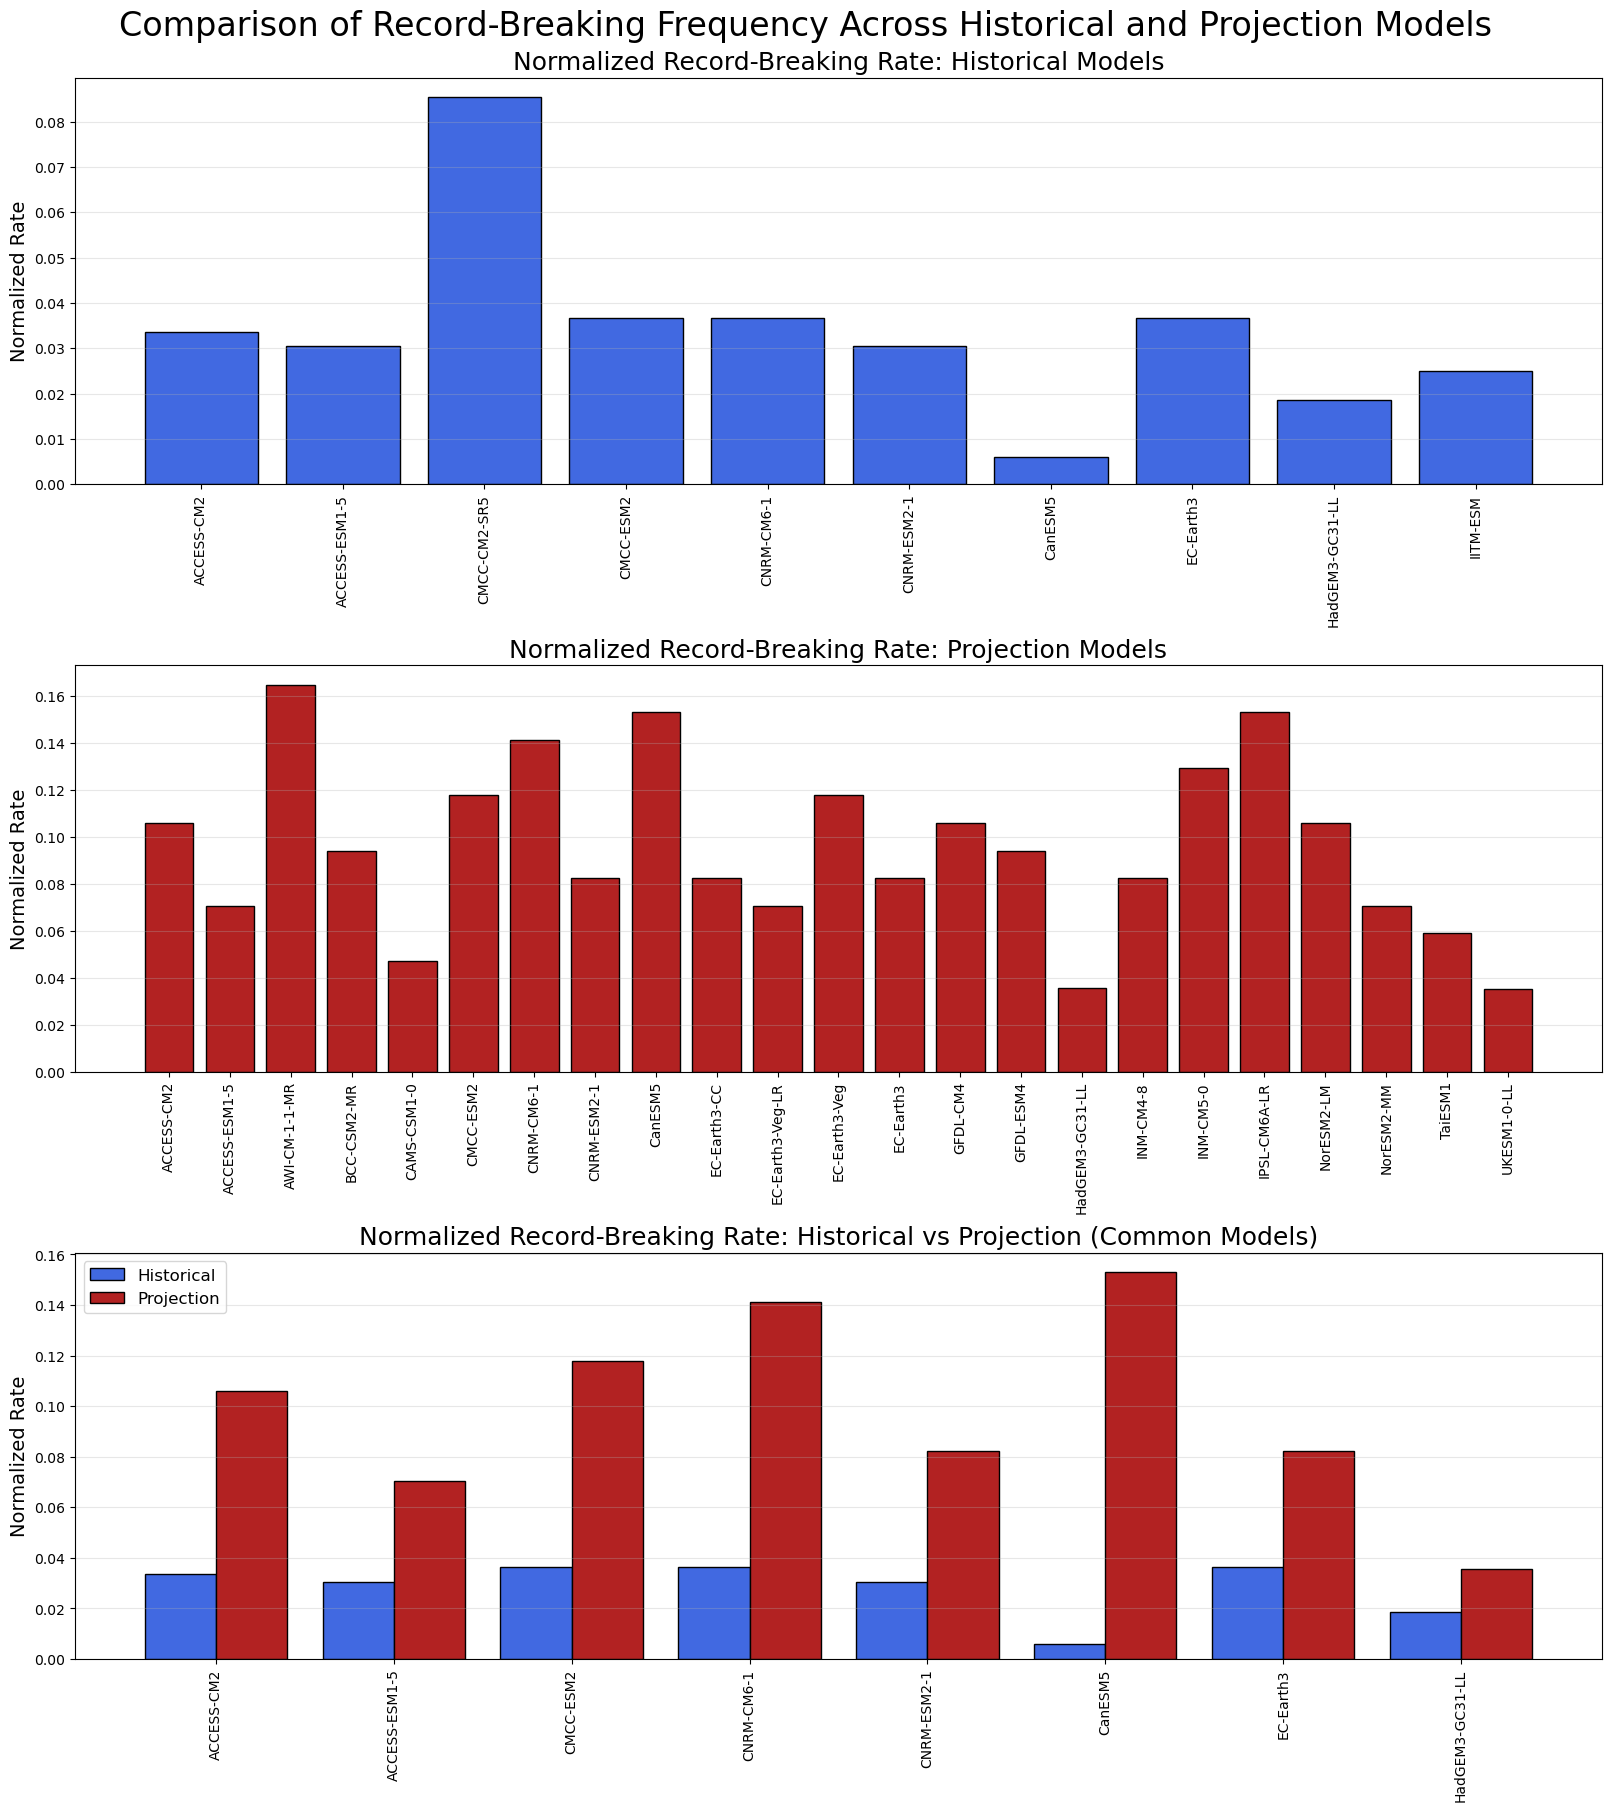

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import xarray as xr

# === Paths ===
hist_data_dir = '/home/a4wilson/historical_total/'
proj_data_dir = '/home/a4wilson/historical_total/projections_data/'

# === Collect files ===
model_files_hist = glob.glob(os.path.join(hist_data_dir, '*_dailymax_temps_record.nc'))
model_files_hist.sort()

model_files_proj = glob.glob(os.path.join(proj_data_dir, '*_dailymax_temp.npy'))
model_files_proj.sort()

print(f"Found {len(model_files_hist)} historical models.")
print(f"Found {len(model_files_proj)} projection models.")

# === Storage lists ===
norm_rates_hist = []
norm_rates_proj = []
hist_model_names = []
proj_model_names = []

# === Process Historical Models ===
for model_file in model_files_hist:
    model_name = os.path.basename(model_file).replace('_dailymax_temps_record.nc', '')
    hist_model_names.append(model_name)

    ds = xr.open_dataset(model_file)

    if 'tasmax' not in ds:
        continue

    tasmax = ds['tasmax']

    # Extract hottest value each year
    if 'time' in tasmax.dims:
        hottest_each_year = tasmax.groupby('time.year').max(dim=('lat', 'lon')).values
    elif 'year' in tasmax.dims:
        hottest_each_year = tasmax.max(dim=('lat', 'lon')).values
    else:
        continue

    # Count record-breaking events
    current_record = -np.inf
    record_breaks = []

    for temp in hottest_each_year:
        if temp > current_record:
            record_breaks.append(True)
            current_record = temp
        else:
            record_breaks.append(False)

    record_breaks[0] = False  # Exclude first year
    normalized_rate = np.sum(record_breaks) / (len(hottest_each_year) - 1)
    norm_rates_hist.append(normalized_rate)

# === Process Projection Models ===
for model_file in model_files_proj:
    model_name = os.path.basename(model_file).replace('_dailymax_temp.npy', '').strip()

    if model_name == '':
        continue  # Skip files without a proper model name

    proj_model_names.append(model_name)

    hottest_each_year = np.load(model_file)

    # Count record-breaking events
    current_record = -np.inf
    record_breaks = []

    for temp in hottest_each_year:
        if temp > current_record:
            record_breaks.append(True)
            current_record = temp
        else:
            record_breaks.append(False)

    record_breaks[0] = False  # Exclude first year
    normalized_rate = np.sum(record_breaks) / (len(hottest_each_year) - 1)
    norm_rates_proj.append(normalized_rate)

# === Match models available in both ===
hist_dict = dict(zip(hist_model_names, norm_rates_hist))
proj_dict = dict(zip(proj_model_names, norm_rates_proj))

common_models = sorted(set(hist_dict.keys()) & set(proj_dict.keys()))
hist_common_rates = [hist_dict[m] for m in common_models]
proj_common_rates = [proj_dict[m] for m in common_models]

# === Plotting ===
fig, axes = plt.subplots(3, 1, figsize=(16, 18), constrained_layout=True)

# --- Historical Models ---
axes[0].bar(hist_model_names, norm_rates_hist, color='royalblue', edgecolor='black')
axes[0].set_title('Normalized Record-Breaking Rate: Historical Models', fontsize=18)
axes[0].set_ylabel('Normalized Rate', fontsize=14)
axes[0].set_xticks(range(len(hist_model_names)))
axes[0].set_xticklabels(hist_model_names, rotation=90, fontsize=10)
axes[0].grid(True, axis='y', alpha=0.3)

# --- Projection Models ---
axes[1].bar(proj_model_names, norm_rates_proj, color='firebrick', edgecolor='black')
axes[1].set_title('Normalized Record-Breaking Rate: Projection Models', fontsize=18)
axes[1].set_ylabel('Normalized Rate', fontsize=14)
axes[1].set_xticks(range(len(proj_model_names)))
axes[1].set_xticklabels(proj_model_names, rotation=90, fontsize=10)
axes[1].grid(True, axis='y', alpha=0.3)

# --- Side-by-Side Comparison for Common Models ---
bar_width = 0.4
x = np.arange(len(common_models))

axes[2].bar(x - bar_width/2, hist_common_rates, width=bar_width, color='royalblue', edgecolor='black', label='Historical')
axes[2].bar(x + bar_width/2, proj_common_rates, width=bar_width, color='firebrick', edgecolor='black', label='Projection')

axes[2].set_title('Normalized Record-Breaking Rate: Historical vs Projection (Common Models)', fontsize=18)
axes[2].set_ylabel('Normalized Rate', fontsize=14)
axes[2].set_xticks(x)
axes[2].set_xticklabels(common_models, rotation=90, fontsize=10)
axes[2].grid(True, axis='y', alpha=0.3)
axes[2].legend(fontsize=12, loc='upper left')

# --- Overall Figure ---
fig.suptitle('Comparison of Record-Breaking Frequency Across Historical and Projection Models', fontsize=24)

# Save the figure
plt.savefig('normalized_record_breaking_rate_comparison_3plots.png', dpi=300)
plt.show()
